In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import h5py
import scipy

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed





In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size=8, image_size=128):
        print("INITING")
        self.batch_size = batch_size
        self.image_size = image_size
        
        
        h5f = h5py.File(images_path,'r')
        images = h5f['all_data'][:]
        h5f.close()



        h5f = h5py.File(masks_path,'r')
        masks = h5f['all_data'][:]
        h5f.close()

        self.data_size = images.shape[0]
        

        channeled_images = []
        channeled_masks = []
        
        for n,image in enumerate(images):
            image = np.stack([image[:,:,:,0],image[:,:,:,1],image[:,:,:,2]],axis=-1)
            #image[:,:,:,3] = 0
            #image[:,:,:,3][np.argmax(masks[n],axis=-1) > 0] = 1
            channeled_images.append(image)


        for mask in masks:
            '''blub = np.argmax(mask,axis=-1)
            blub[blub>0] = 1
            channeled_masks.append(np.array(np.stack([blub],axis=-1),dtype="float32"))'''
            channeled_masks.append(mask)

        
        self.images = np.array(channeled_images)
        self.masks = np.array(channeled_masks)

        self.on_epoch_end()
    def append(self, images_path, masks_path, batch_size=8, image_size=128):
        print("APPENDING")
        self.batch_size = batch_size
        self.image_size = image_size
        
        
        h5f = h5py.File(images_path,'r')
        images = h5f['all_data'][:]
        h5f.close()



        h5f = h5py.File(masks_path,'r')
        masks = h5f['all_data'][:]
        h5f.close()

        self.data_size = images.shape[0]
        

        channeled_images = []
        channeled_masks = []
        
        for n,image in enumerate(images):
            image = np.stack([image[:,:,:,0],image[:,:,:,1],image[:,:,:,2]],axis=-1)
            #image[:,:,:,3] = 0
            #image[:,:,:,3][np.argmax(masks[n],axis=-1) > 0] = 1
            channeled_images.append(image)


        for mask in masks:
            channeled_masks.append(mask)

        new_images = []
        for image in self.images:
          new_images.append(image)
        for thing in channeled_images:
          new_images.append(thing)

        new_masks = []
        for mask in self.masks:
          new_masks.append(mask)
        for thing in channeled_masks:
          new_masks.append(thing)

        self.images = np.array(new_images)
        self.masks = np.array(new_masks)
        print(self.images.shape)
        print(self.masks.shape) 
        
    def shuffle_da_set(self):
          new_indexes = []
          for i in range(0,len(self.images)):
              index = random.randint(0,len(self.images)-1)
              while index in new_indexes:
                  index = random.randint(0,len(self.images)-1)
              new_indexes.append(index)

          new_images = []
          new_masks = []
          for index in new_indexes:
              print(index)
              new_images.append(self.images[index])
              new_masks.append(self.masks[index])


          self.images = np.array(new_images)
          self.masks = np.array(new_masks)       
             
     
    def __getitem__(self, index):
        BUFFER_SIZE = 1000
        if(index+1)*self.batch_size > self.images.shape[0]:
            self.batch_size = self.images.shape[0] - index*self.batch_size
        
        images = []
        masks  = []

        for image in self.images[index*self.batch_size : (index+1)*self.batch_size]:
            images.append(image)
        for mask in self.masks[index*self.batch_size : (index+1)*self.batch_size]:
            masks.append(mask)
            


        

        images = np.array(images)
        masks  = np.array(masks)
        return images, masks

    def get_array(self, index):
        return np.stack([self.images[index]]), np.stack([self.masks[index]])


    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(self.data_size/float(self.batch_size)))




In [ ]:

def down_block(x, filters, dropout, kernel_size=(3, 3, 3), padding="same", strides=1):
    print(x.shape)
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="elu", input_shape = x.shape[1:], kernel_initializer='he_normal')(x)
    c = keras.layers.Dropout(dropout)(c)
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="elu", input_shape = c.shape[1:], kernel_initializer='he_normal')(c)
    p = keras.layers.MaxPool3D(pool_size = (2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, dropout,kernel_size=(3, 3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling3D((2, 2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="elu", input_shape = concat.shape[1:], kernel_initializer='he_normal')(concat)
    c = keras.layers.Dropout(dropout)(c)
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="elu", input_shape = c.shape[1:], kernel_initializer='he_normal')(c)
    return c

def bottleneck(x, filters, dropout, kernel_size=(3, 3, 3), padding="same", strides=1):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="elu", input_shape = x.shape[1:], kernel_initializer='he_normal')(x)
    c = keras.layers.Dropout(dropout) (c)
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="elu", input_shape = c.shape[1:], kernel_initializer='he_normal')(c)
    return c

def ConvNet(x,y,z):
    inputs = keras.layers.Input((x,y,z, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, 16, 0.1) #128 -> 64
    print(p1.shape)
    c2, p2 = down_block(p1, 32, 0.1) #64 -> 32
    c3, p3 = down_block(p2, 64, 0.2) #32 -> 16
    c4, p4 = down_block(p3, 128, 0.2) #16->8
    
    bn = bottleneck(p4, 256, 0.3)
    print(bn.shape)
    
    u1 = up_block(bn, c4, 128, 0.2) #8 -> 16
    u2 = up_block(u1, c3, 64, 0.2) #16 -> 32
    u3 = up_block(u2, c2, 32, 0.1) #32 -> 64
    u4 = up_block(u3, c1, 16, 0.1) #64 -> 128
    
    outputs = tf.keras.layers.Conv3D(4, (1, 1, 1),padding='same', activation="softmax")(u4)
    #outputs = keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="relu")(u4)
    print("out")
    print(outputs.shape)
    model = keras.models.Model(inputs, outputs)
    return model

def ConvNet5(x,y,z):
    inputs = keras.layers.Input((x,y,z, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, 16, 0.1) #128 -> 64
    print(p1.shape)
    c2, p2 = down_block(p1, 32, 0.1) #64 -> 32
    c3, p3 = down_block(p2, 64, 0.2) #32 -> 16
    c4, p4 = down_block(p3, 128, 0.3) #16->8
    c5, p5 = down_block(p4, 256, 0.3) #16->8
    c6, p6 = down_block(p5, 512, 0.3) #16->8
    
    bn = bottleneck(p6, 1024, 0.4)
    print(bn.shape)
    
    u1 = up_block(bn, c6, 512, 0.3) #8 -> 16
    u2 = up_block(u1, c5, 256, 0.2) #16 -> 32
    u3 = up_block(u2, c4, 128, 0.1) #32 -> 64
    u4 = up_block(u3, c3, 64, 0.1) #64 -> 128
    u5 = up_block(u4, c2, 32, 0.1) #64 -> 128
    u6 = up_block(u5, c1, 16, 0.1) #64 -> 128
    
    outputs = tf.keras.layers.Conv3D(4, (1, 1, 1),padding='same', activation="softmax")(u6)
    #outputs = keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="relu")(u4)
    print("out")
    print(outputs.shape)
    model = keras.models.Model(inputs, outputs)
    return model


def gdc_loss(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    dice = 0
    num_classes = y_pred.shape[-1]
    for l in range(0,num_classes):
      numerator = y_true[:,:,:,l]*y_pred[:,:,:,l]
      numerator = K.sum(numerator)
      
      denominator = y_true[:,:,:,l]+y_pred[:,:,:,l]
      denominator = K.sum(denominator)
      dice+=2*numerator/denominator
    
    return num_classes-dice

def gdc_loss(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    Ncl = y_pred.shape[-1]
    w = []
    for l in range(0,Ncl):
        w.append(K.sum(tf.cast(y_true[:,:,:,:,l]==1, tf.float32)))
    w = tf.convert_to_tensor(w)
    w = 1/(w+0.00001)

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)
    
    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)
    
    gen_dice_coef = numerator/denominator
    
    return 1-2*gen_dice_coef

def gdc_loss2(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = K.sum(numerator)
    
    denominator = y_true+y_pred
    denominator = K.sum(denominator)
    
    gen_dice_coef = numerator/denominator
    
    return 10*(1-2*gen_dice_coef)

def iou_loss(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = K.sum(numerator)
    
    denominator = y_true+y_pred
    denominator = K.sum(denominator)
    
    gen_dice_coef = numerator/(denominator-numerator)
    
    return 10*(1-gen_dice_coef)

def tversky_loss(y_true, y_pred):
    alpha = 0.8 ##false positives
    beta  = 0.2 ##false negatives
    
    ones = tf.cast(tf.cast(y_true != -123123,dtype=tf.int32),dtype=tf.float32)
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = 0.5*K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce(y_true, y_pred):    
    actual_true = tf.cast(tf.cast(y_true == 1,dtype=tf.int32),dtype=tf.float32)
    bce = K.binary_crossentropy(actual_true, y_pred)

    everything = tf.cast(tf.cast(y_true != -1,dtype=tf.int32),dtype=tf.float32)
    total_size = K.sum(everything)

    zeros = tf.cast(tf.cast(y_true == 0,dtype=tf.int32),dtype=tf.float32)
    zeros_count = K.sum(zeros)
    current_fraction = zeros_count/total_size
    zero_weight = 0.33/current_fraction 
    print("zero weight:", zero_weight)
    weighted_zeros = zeros * zero_weight

    ones = tf.cast(tf.cast(y_true == 1,dtype=tf.int32),dtype=tf.float32)
    ones_count = K.sum(ones)
    current_fraction = ones_count/total_size
    ones_weight = 0.33/current_fraction 
    print("ones weight:", ones_weight) 
    weighted_ones = ones * ones_weight

    '''twos = tf.cast(tf.cast(y_true == 2,dtype=tf.int32),dtype=tf.float32)
    twos_count = K.sum(twos)
    current_fraction = twos_count/total_size
    twos_weight = 0.33/current_fraction
    print("twos weight:", twos_weight)
    weighted_twos = twos * twos_weight'''

    total_weights = weighted_zeros + weighted_ones #+ weighted_twos

    weighted_bce = K.mean(bce * total_weights)
    return weighted_bce


(None, 64, 64, 64, 3)
(None, 32, 32, 32, 16)
(None, 32, 32, 32, 16)
(None, 16, 16, 16, 32)
(None, 8, 8, 8, 64)
(None, 4, 4, 4, 128)
(None, 2, 2, 2, 256)
(None, 1, 1, 1, 1024)
out
(None, 64, 64, 64, 4)
INITING
INITING
INITING
x shape (2, 64, 64, 64, 3)
0.0
y shape (2, 64, 64, 64, 4)
0.0
119
196
217
53
54
90
131
167
25
35
48
37
126
47
223
32
70
60
140
178
24
200
29
180
227
161
33
105
132
61
74
30
168
145
19
22
98
11
109
134
203
10
154
159
130
103
191
115
86
66
104
125
136
52
99
63
112
205
162
204
108
88
222
158
87
68
173
58
110
14
218
127
182
6
189
51
143
186
107
166
93
42
185
135
46
89
38
155
75
226
188
233
170
96
41
8
80
184
224
160
208
156
215
4
174
100
40
44
219
114
206
34
106
199
113
157
221
152
50
146
72
201
150
43
211
76
232
82
120
137
163
123
23
18
71
78
171
118
84
124
210
9
129
59
45
31
62
194
175
102
0
73
231
81
5
117
179
212
225
229
20
192
28
183
195
230
216
56
121
85
65
79
177
198
164
57
101
172
214
97
64
3
202
21
176
209
142
213
165
95
77
111
91
144
27
49
2
15
1
55
190
220
1

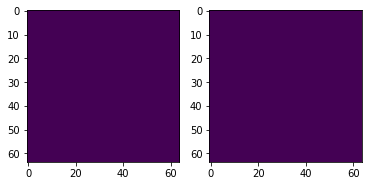

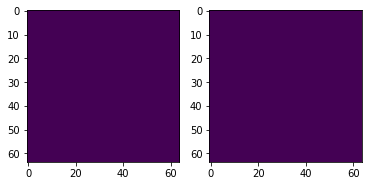

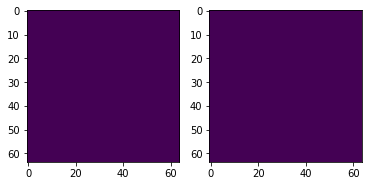

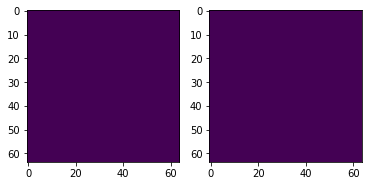

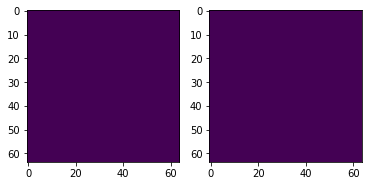

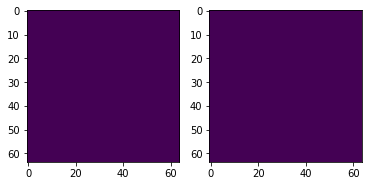

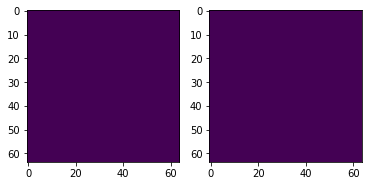

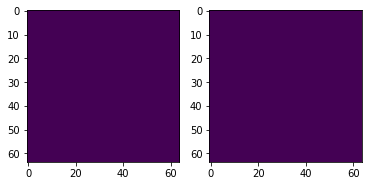

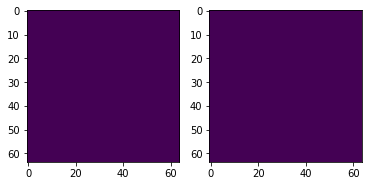

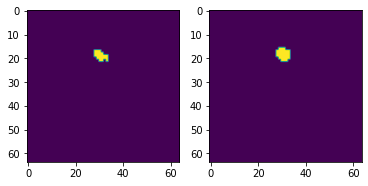

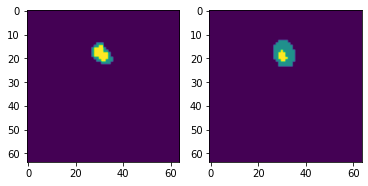

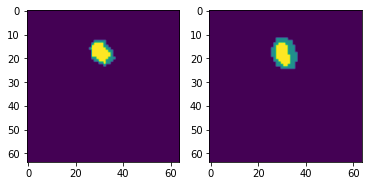

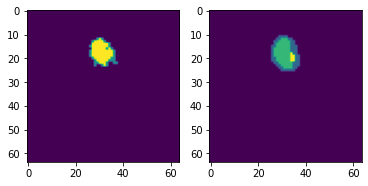

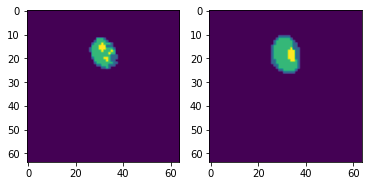

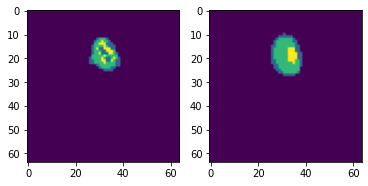

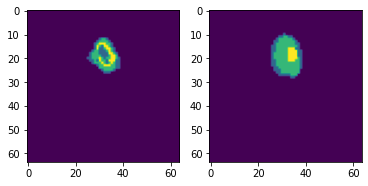

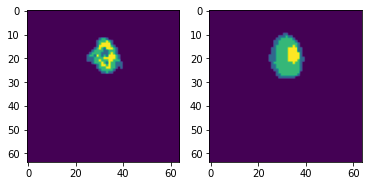

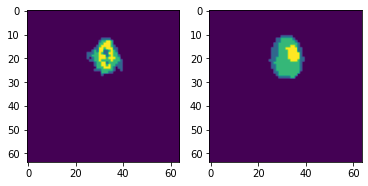

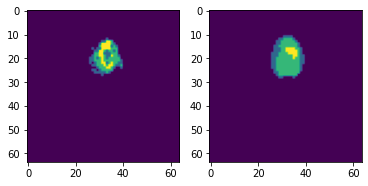

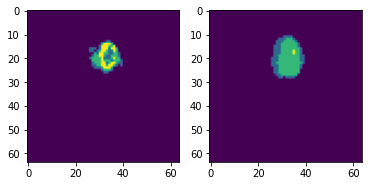

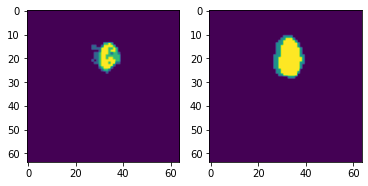

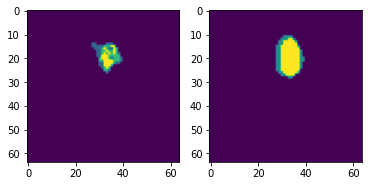

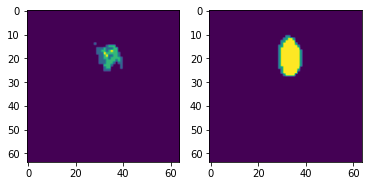

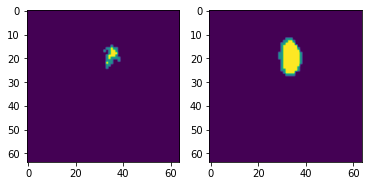

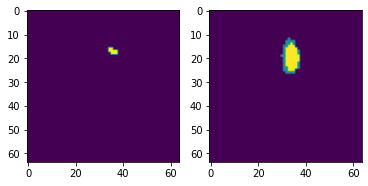

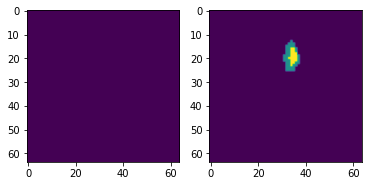

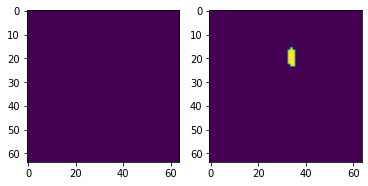

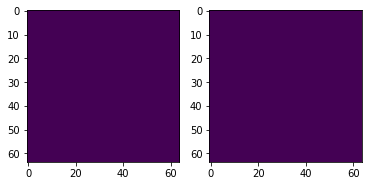

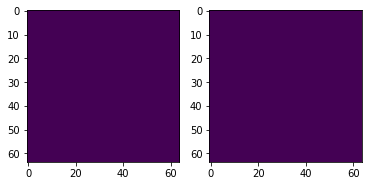

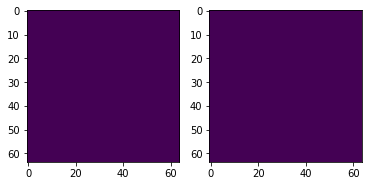

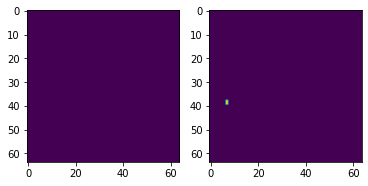

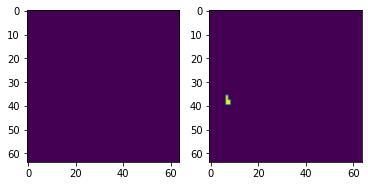

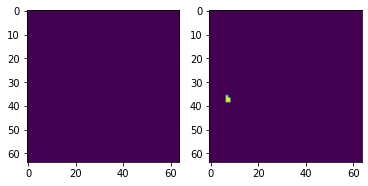

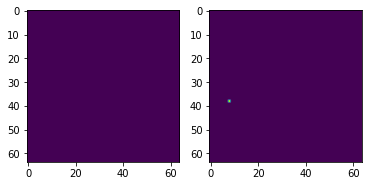

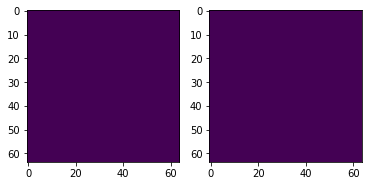

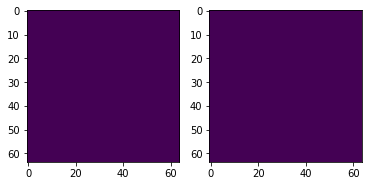

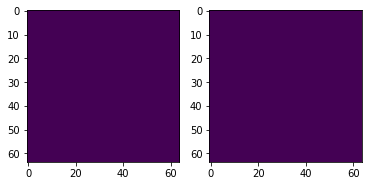

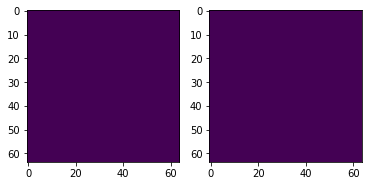

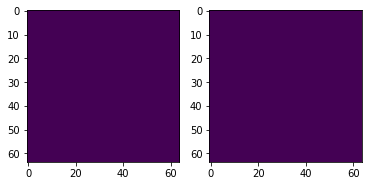

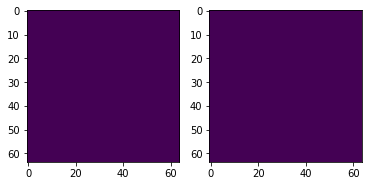

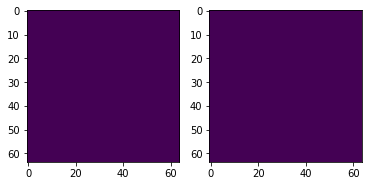

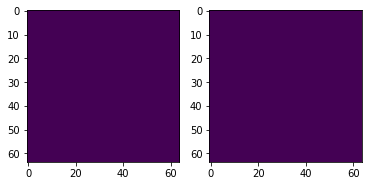

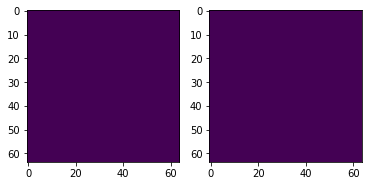

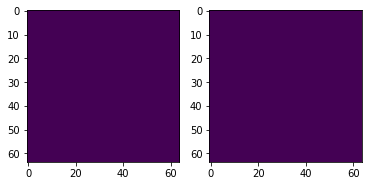

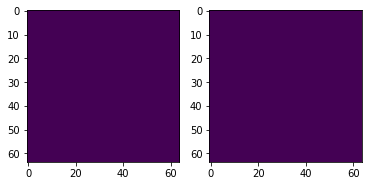

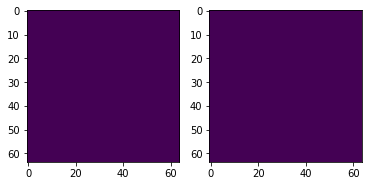

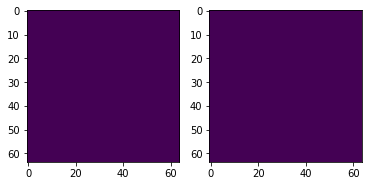

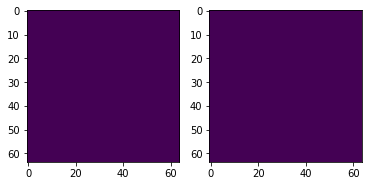

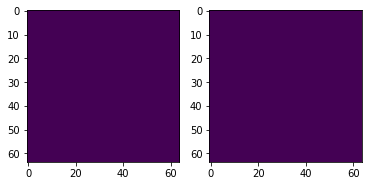

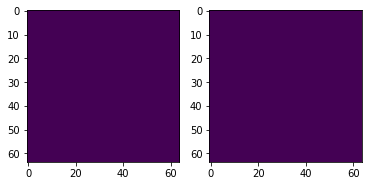

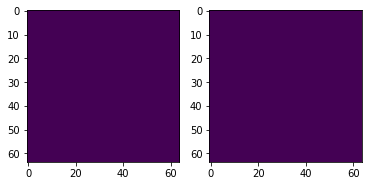

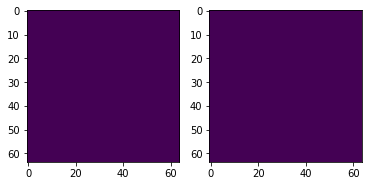

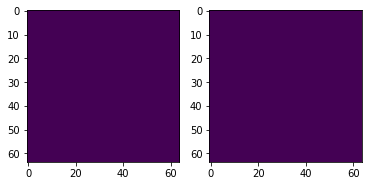

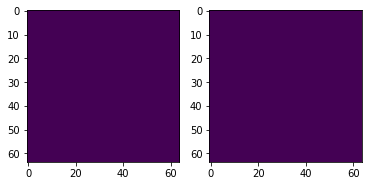

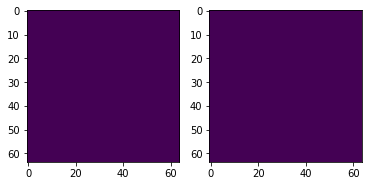

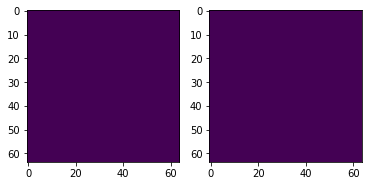

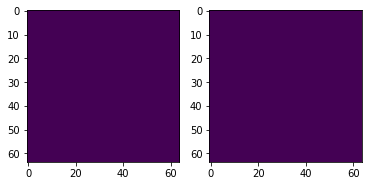

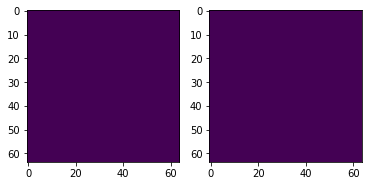

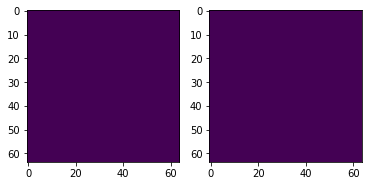

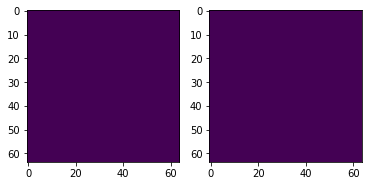

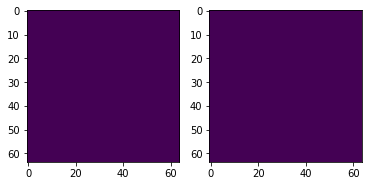

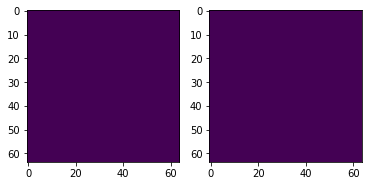

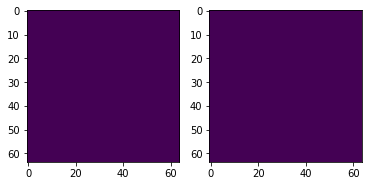

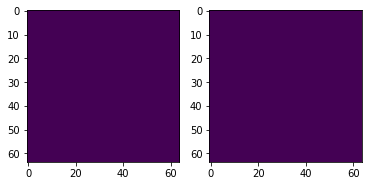

59
218
72
169
53
96
120
15
196
147
45
205
162
55
11
67
16
219
33
91
0
38
42
129
4
37
225
73
62
106
61
116
68
64
139
133
36
142
110
103
217
143
224
65
34
175
100
6
7
12
227
216
49
14
176
198
27
195
79
10
19
177
111
178
101
134
166
183
81
173
172
46
232
127
114
161
136
1
213
56
13
188
80
181
57
20
122
170
164
98
150
131
86
210
228
223
148
70
113
8
40
125
192
184
154
54
203
197
39
51
123
82
137
128
156
118
174
171
159
78
44
167
186
18
85
47
97
163
60
155
3
52
31
189
206
87
182
149
63
230
88
208
201
84
222
221
151
94
153
211
220
66
160
190
140
69
22
185
135
24
75
231
48
212
28
130
229
199
187
17
105
50
109
200
193
168
95
146
144
5
25
32
117
233
76
58
89
35
194
226
112
214
99
115
158
43
90
207
126
145
71
202
180
191
102
157
204
121
209
2
119
104
74
41
30
152
179
26
77
21
29
141
107
93
9
124
215
165
132
83
108
138
23
92
28
5
1
48
26
35
14
0
40
39
33
47
21
7
20
43
23
45
6
36
4
42
9
34
31
30
2
50
37
3
49
46
38
41
24
15
13
17
16
29
12
25
22
44
27
8
10
19
32
11
18
34
48
16
25
7
5
31
12
6
15
38
1

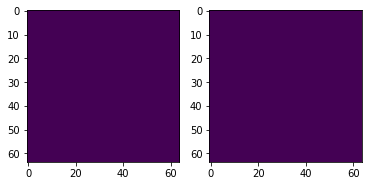

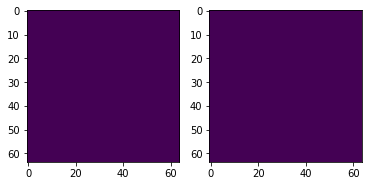

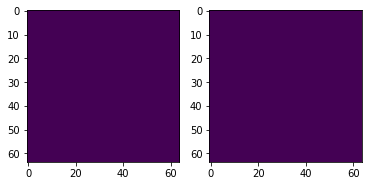

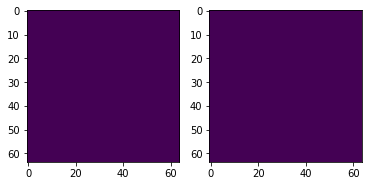

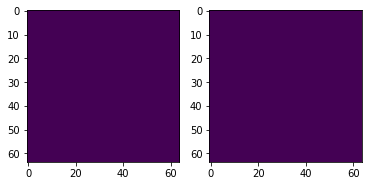

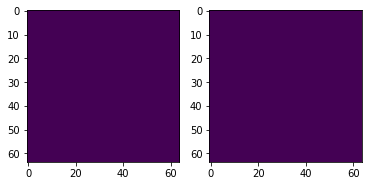

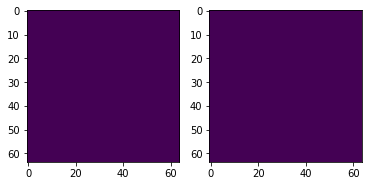

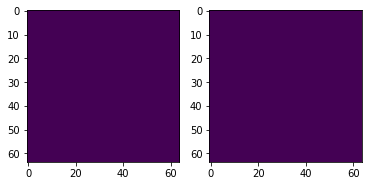

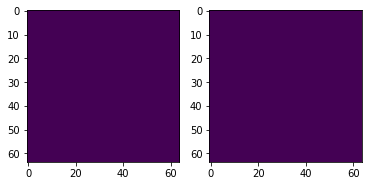

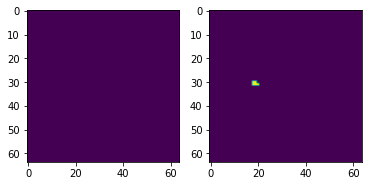

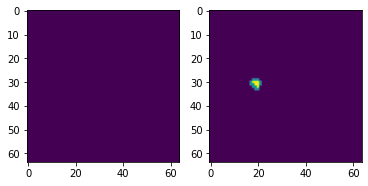

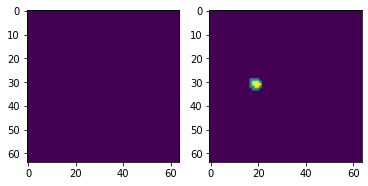

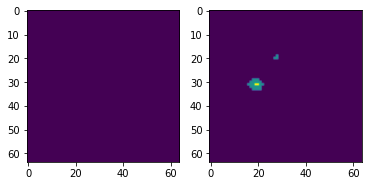

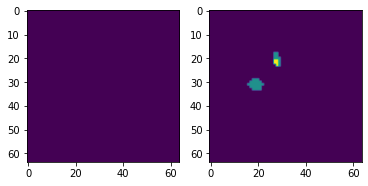

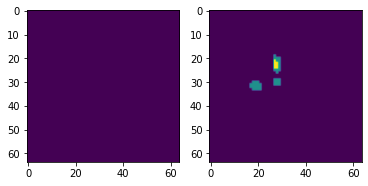

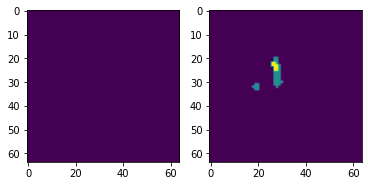

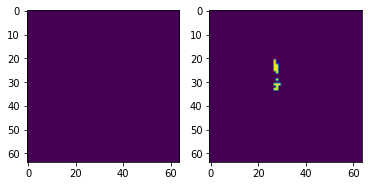

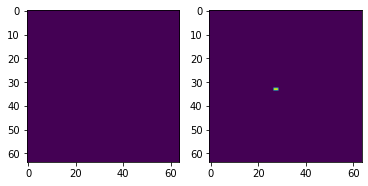

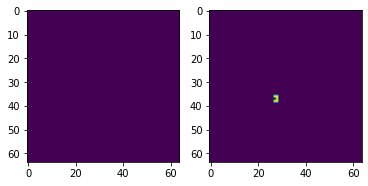

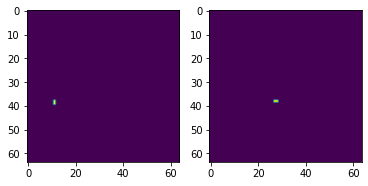

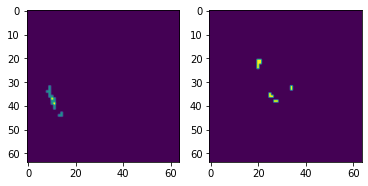

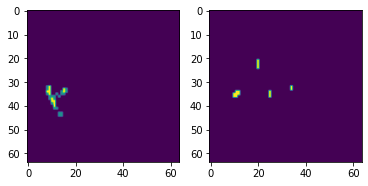

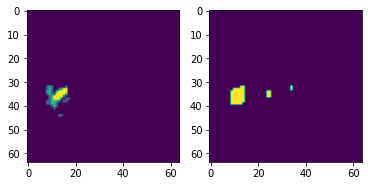

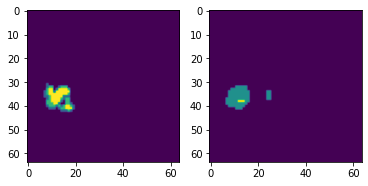

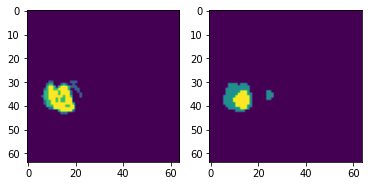

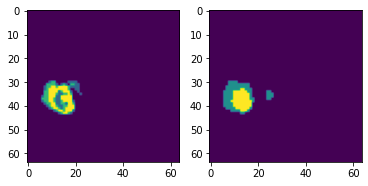

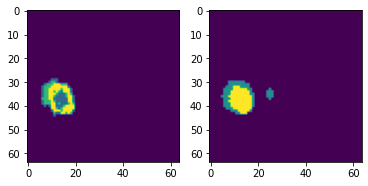

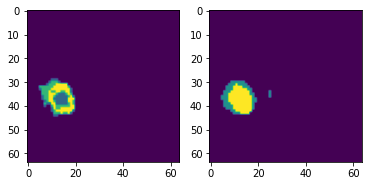

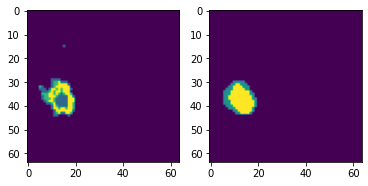

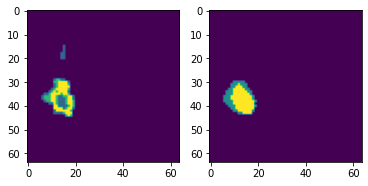

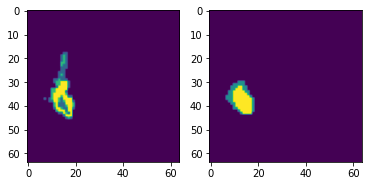

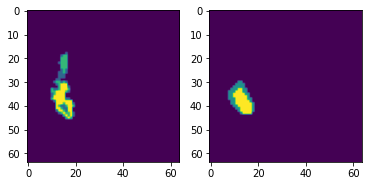

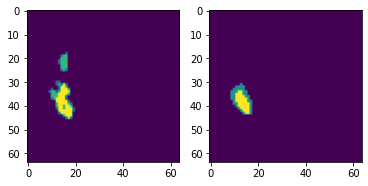

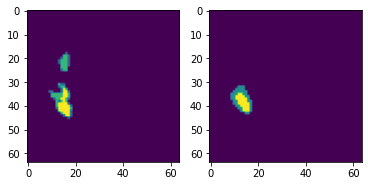

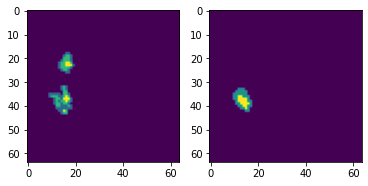

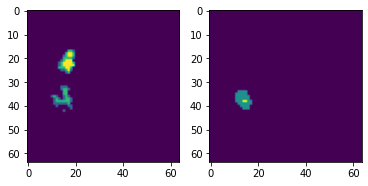

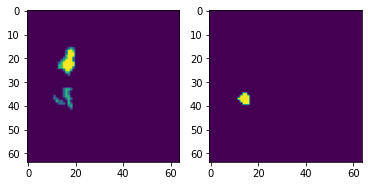

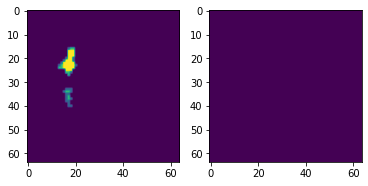

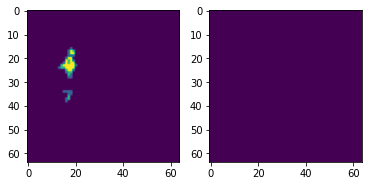

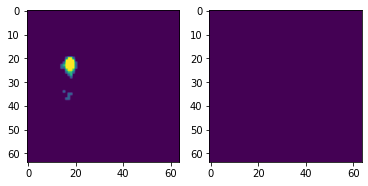

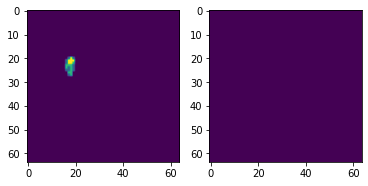

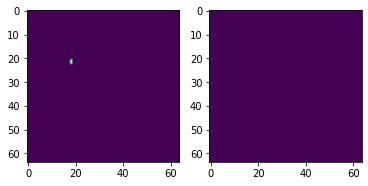

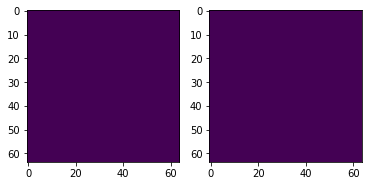

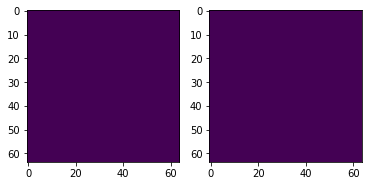

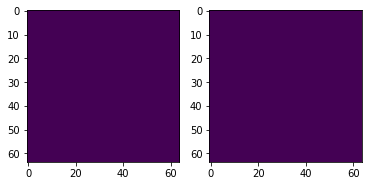

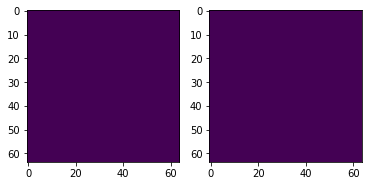

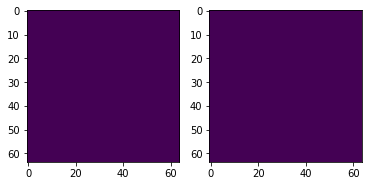

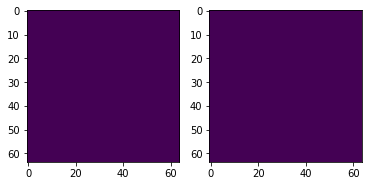

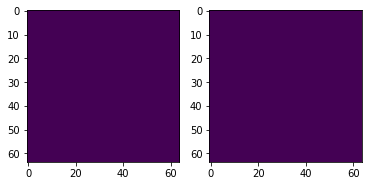

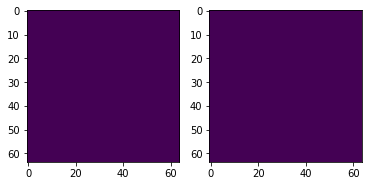

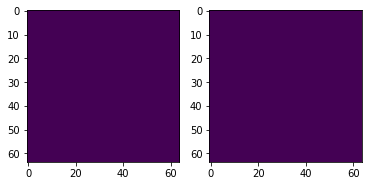

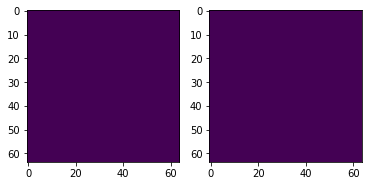

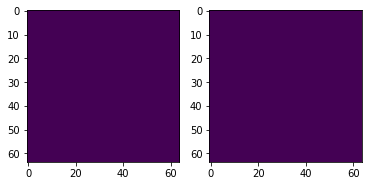

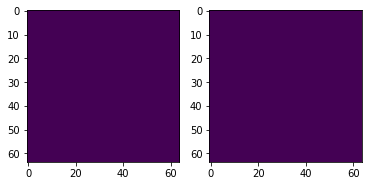

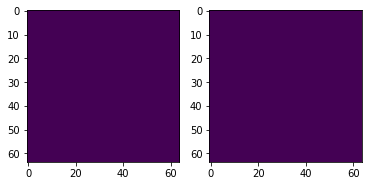

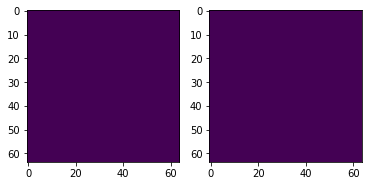

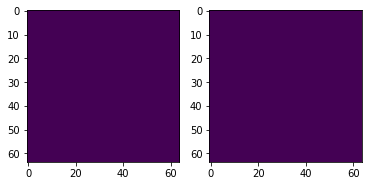

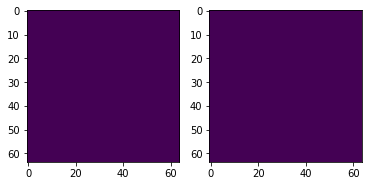

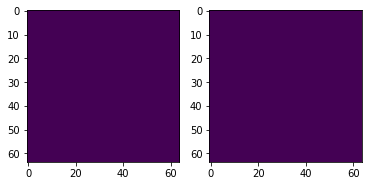

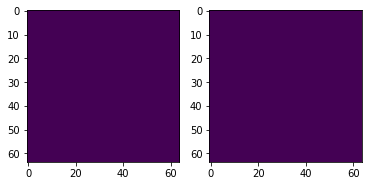

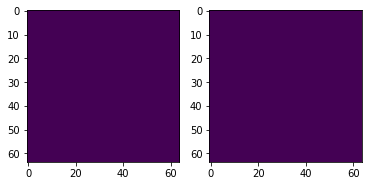

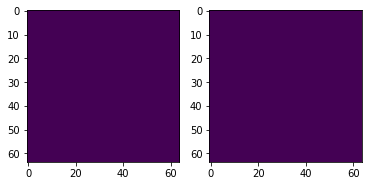

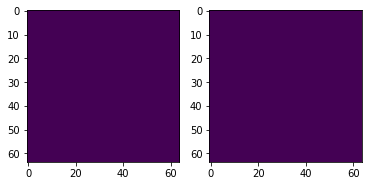

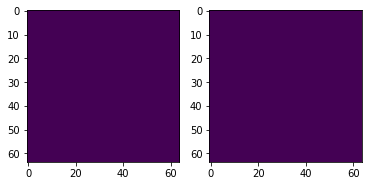

209
7
105
65
187
162
60
22
5
201
31
86
76
26
184
15
95
207
177
62
153
140
231
134
1
68
160
228
47
73
16
104
59
181
93
215
124
74
103
172
58
114
202
3
118
219
100
25
50
151
186
192
199
20
133
71
210
88
35
83
37
33
136
28
64
200
155
36
154
12
96
137
41
216
170
226
53
224
130
18
82
101
0
21
123
91
129
29
148
108
117
80
182
171
230
222
69
227
173
17
34
10
144
125
97
109
84
52
19
203
142
159
90
176
57
139
191
161
30
51
193
221
195
196
212
85
141
233
185
55
49
75
183
145
102
150
106
40
89
164
11
120
232
45
166
111
213
204
179
78
163
116
72
169
113
44
206
46
131
158
156
8
23
14
165
167
190
135
122
81
157
146
38
218
223
225
189
63
132
79
87
220
42
217
178
94
67
138
70
127
9
2
92
174
211
110
54
4
24
119
13
126
115
48
180
107
229
147
112
188
98
27
66
32
205
194
39
6
143
168
77
56
208
43
128
61
197
149
152
121
175
214
99
198
22
10
21
40
44
23
18
41
47
35
14
13
19
26
33
49
36
32
6
48
45
31
7
29
4
12
8
15
27
17
16
11
1
2
46
25
39
28
43
0
24
42
20
9
37
50
30
5
3
34
38
25
46
3
29
41
8
21
24
18
1
5
10

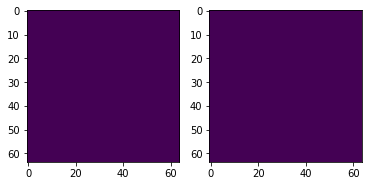

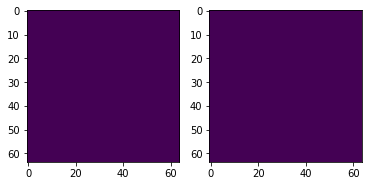

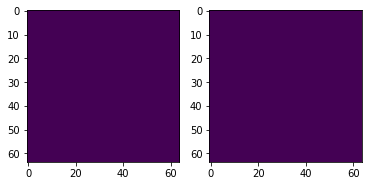

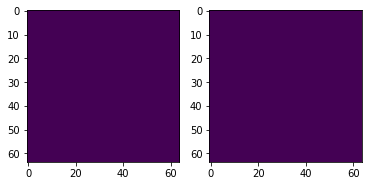

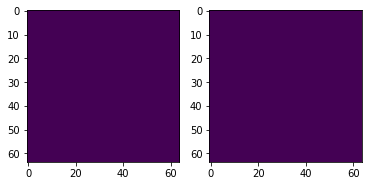

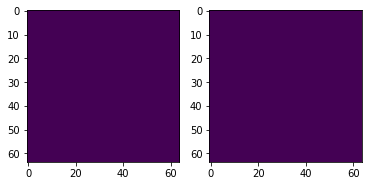

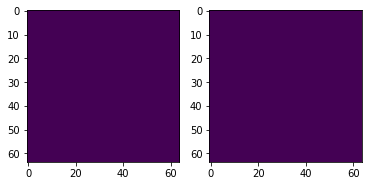

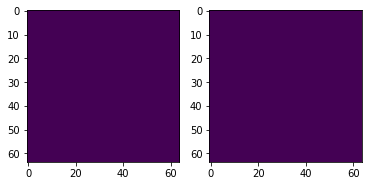

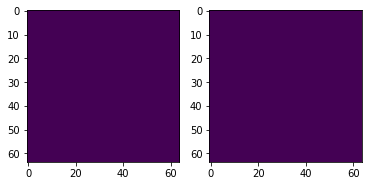

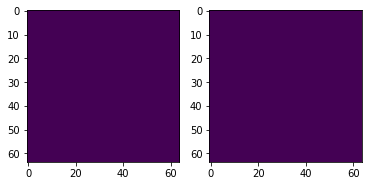

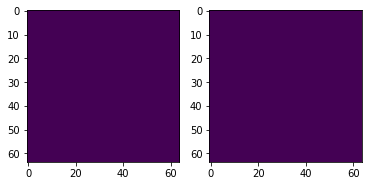

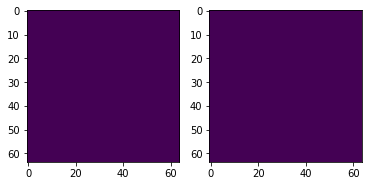

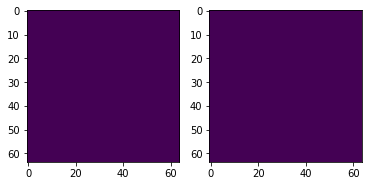

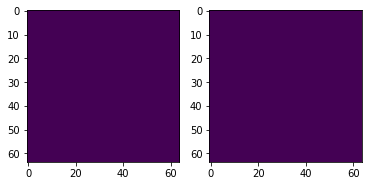

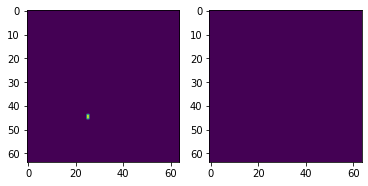

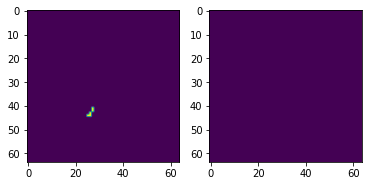

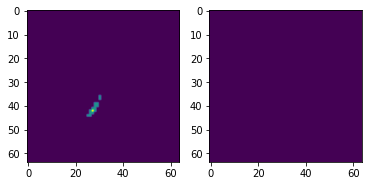

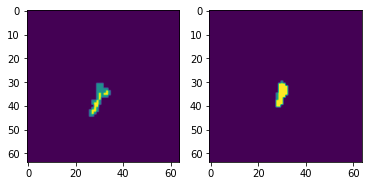

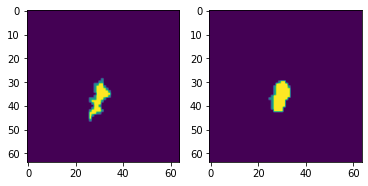

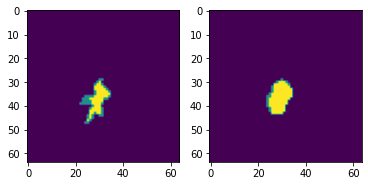

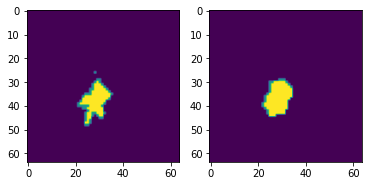

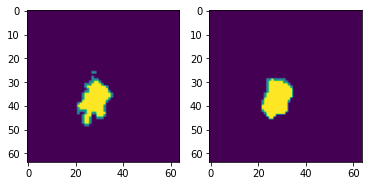

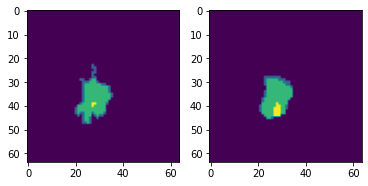

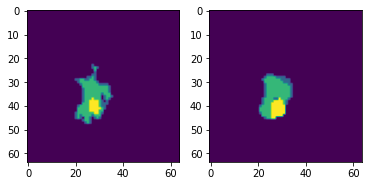

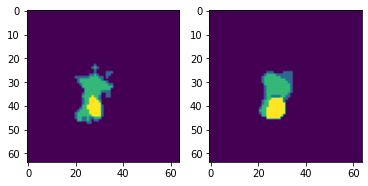

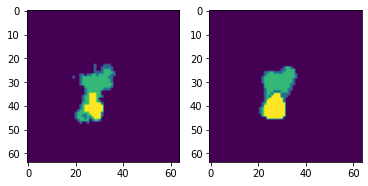

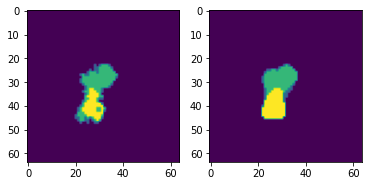

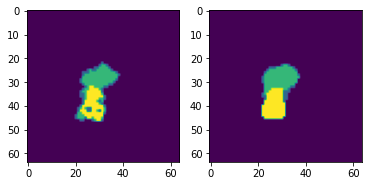

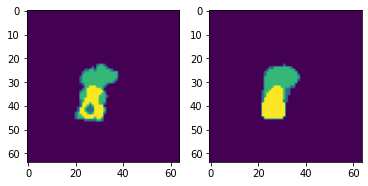

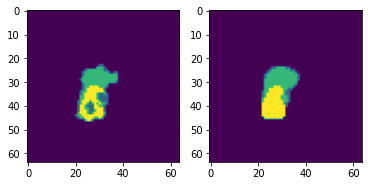

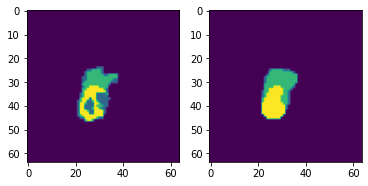

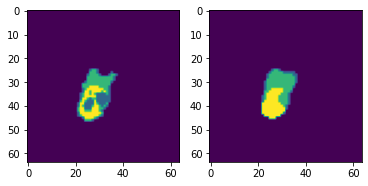

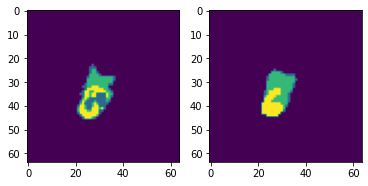

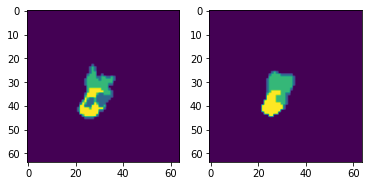

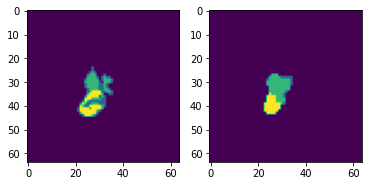

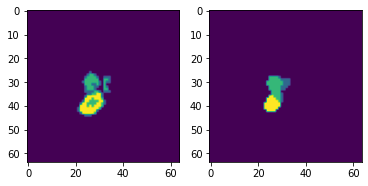

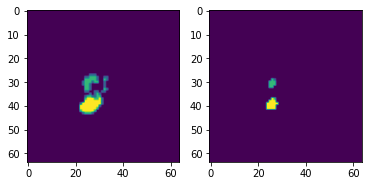

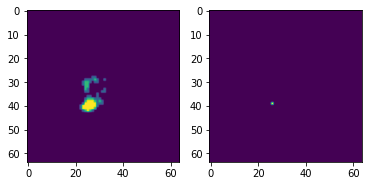

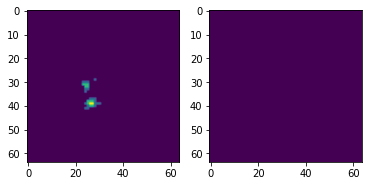

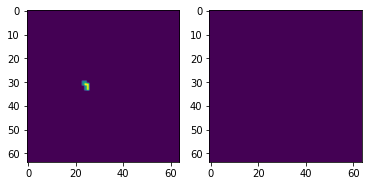

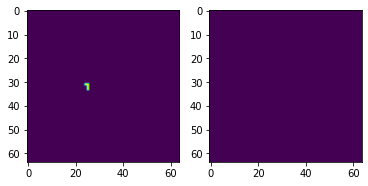

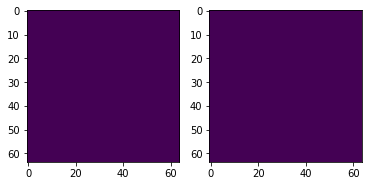

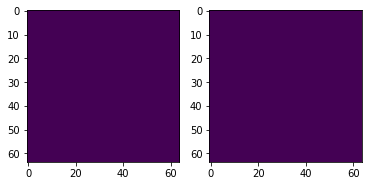

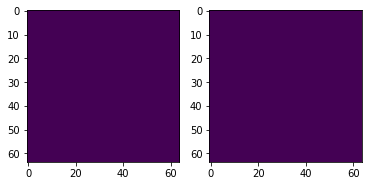

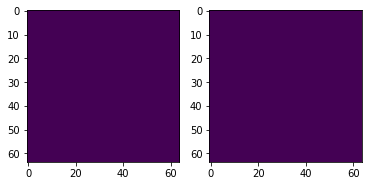

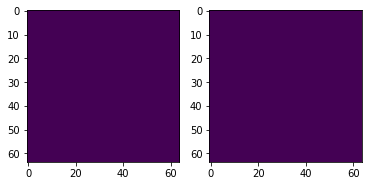

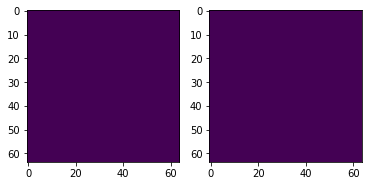

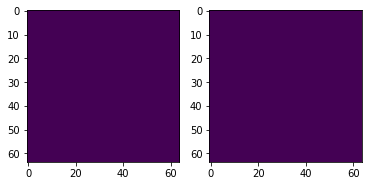

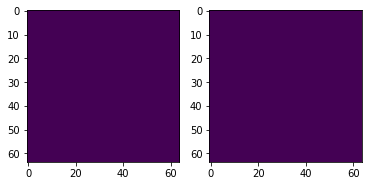

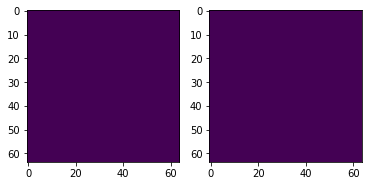

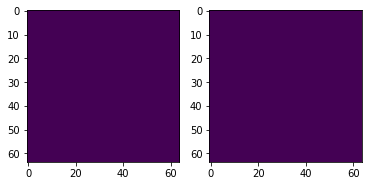

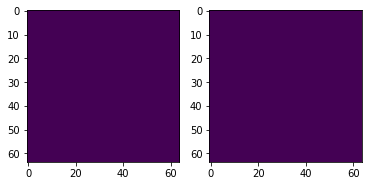

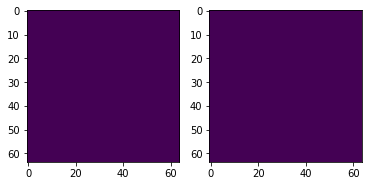

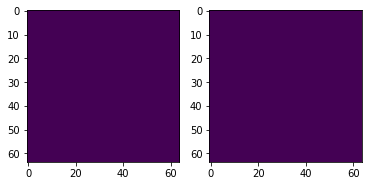

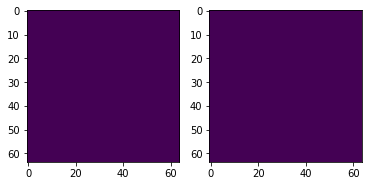

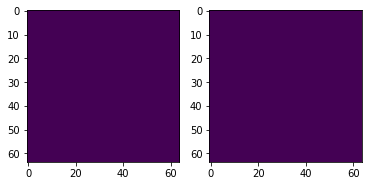

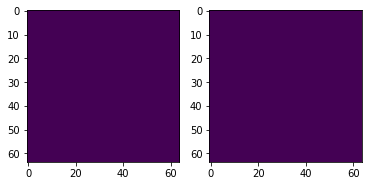

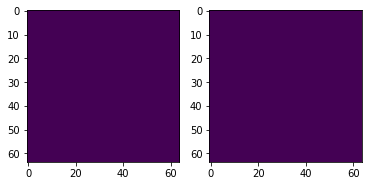

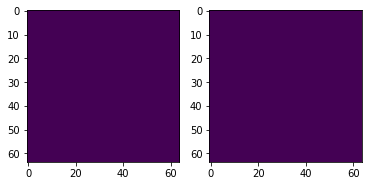

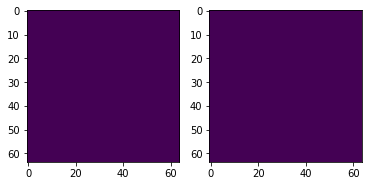

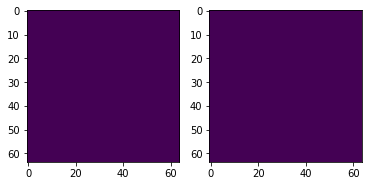

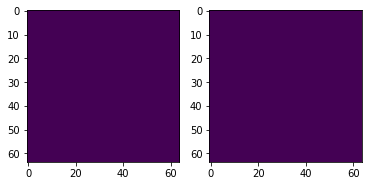

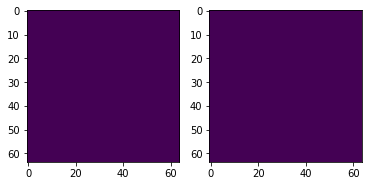

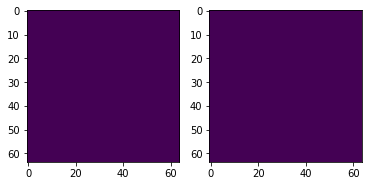

137
219
151
69
59
179
216
10
33
168
71
28
158
161
162
169
117
163
70
232
23
78
125
52
48
18
63
79
156
49
132
101
109
47
133
25
8
145
138
46
211
182
199
72
139
153
87
174
186
64
32
193
3
1
136
152
67
102
214
35
195
29
223
175
208
55
62
31
75
91
73
121
144
16
74
176
65
189
111
183
140
192
122
217
38
96
177
114
83
76
205
196
41
149
203
66
85
206
94
68
19
115
165
191
30
135
229
129
198
157
213
220
181
37
60
146
40
231
120
100
171
166
148
172
184
159
226
187
13
202
56
150
90
154
119
143
43
218
104
36
105
4
77
27
123
44
86
11
178
224
188
20
45
42
53
209
200
107
99
0
225
39
93
222
127
124
98
61
141
215
190
103
50
88
110
2
142
210
185
167
95
131
204
112
118
26
14
155
9
164
197
170
160
126
81
201
57
15
228
84
80
24
7
180
54
89
34
6
106
221
92
233
194
230
22
82
207
147
108
212
130
21
227
113
116
97
134
51
12
128
17
173
58
5
39
26
44
7
35
37
42
36
24
3
23
50
46
27
47
2
18
10
49
41
6
13
48
22
30
11
4
19
32
28
33
14
15
34
1
8
12
20
43
17
45
9
21
5
0
31
38
16
25
29
40
11
45
26
42
5
33
9
10
39
22
23


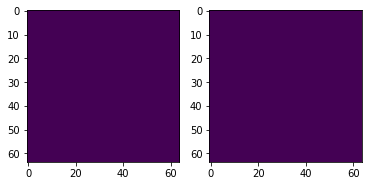

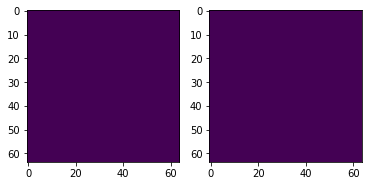

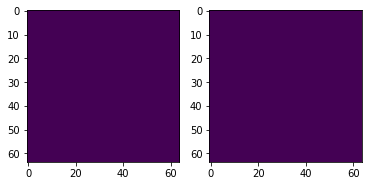

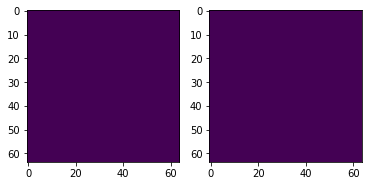

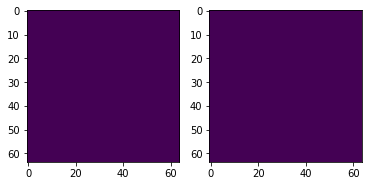

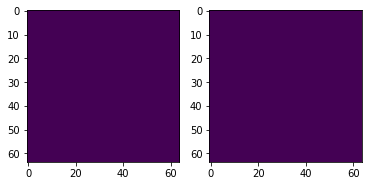

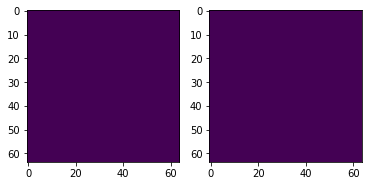

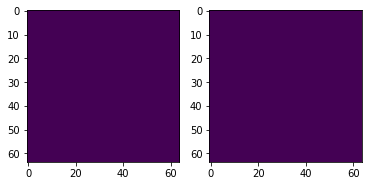

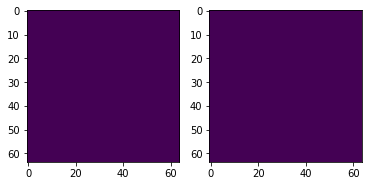

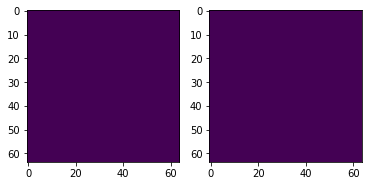

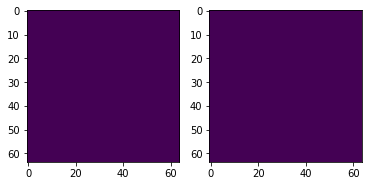

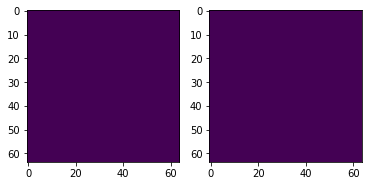

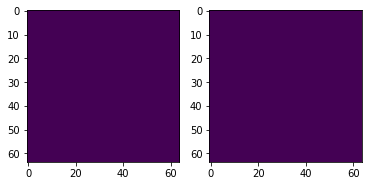

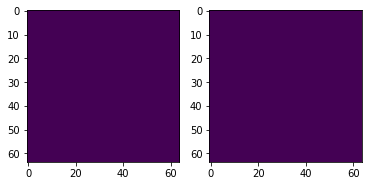

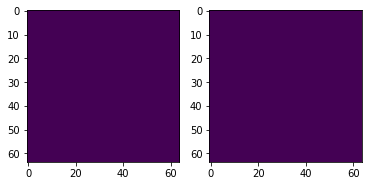

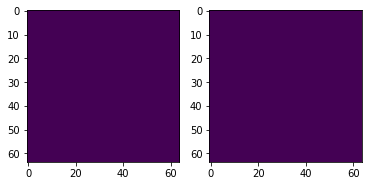

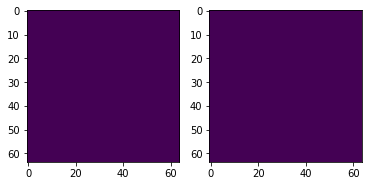

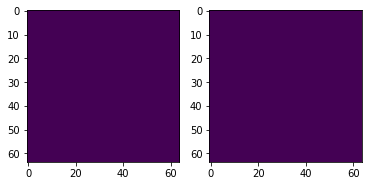

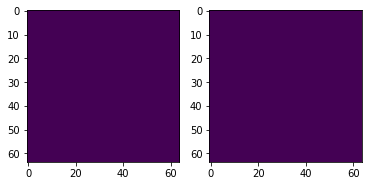

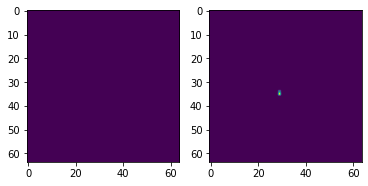

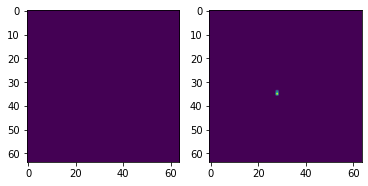

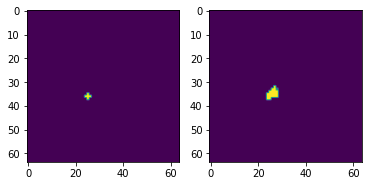

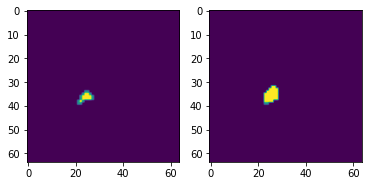

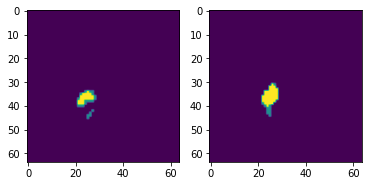

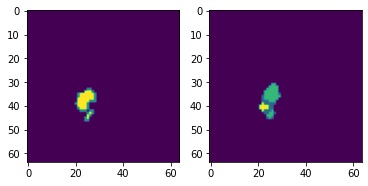

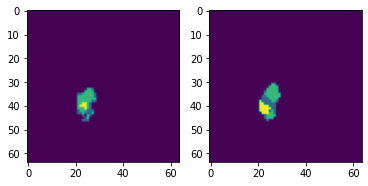

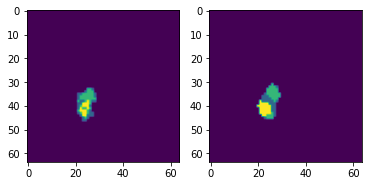

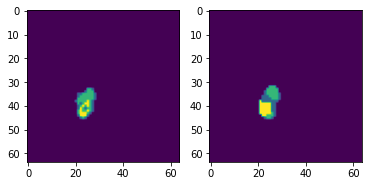

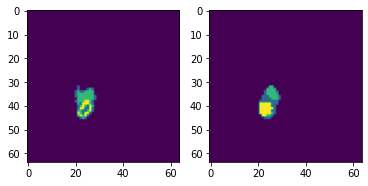

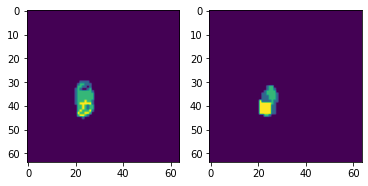

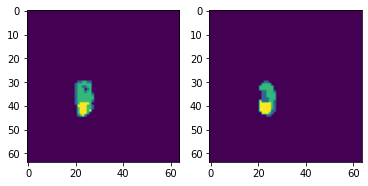

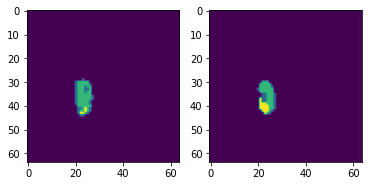

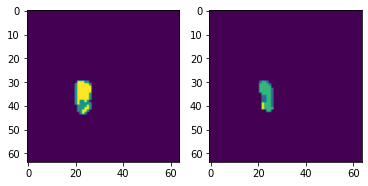

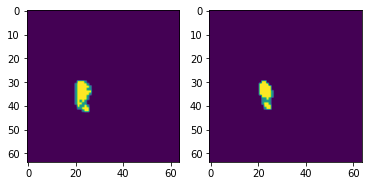

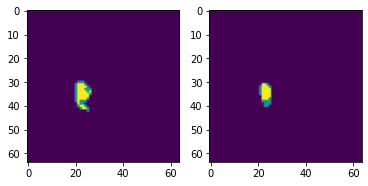

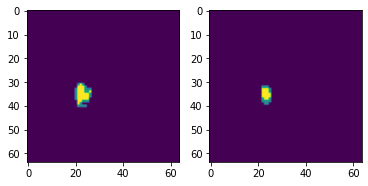

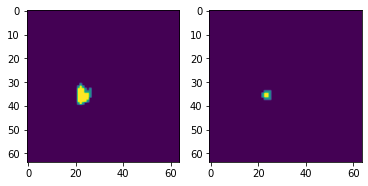

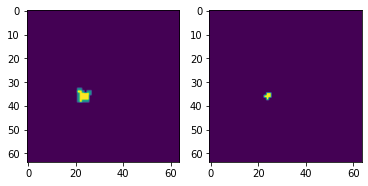

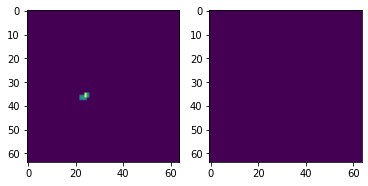

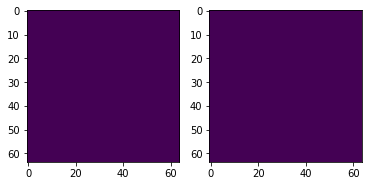

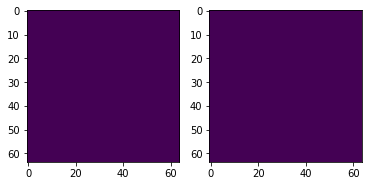

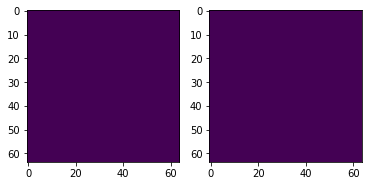

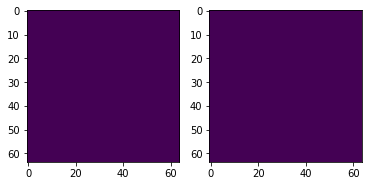

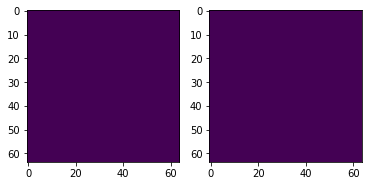

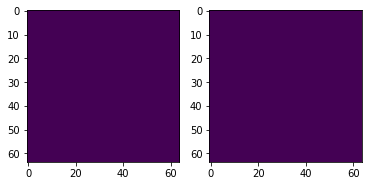

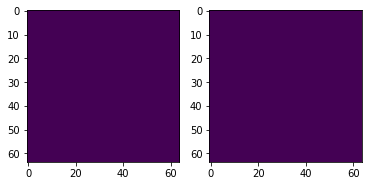

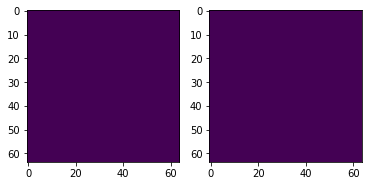

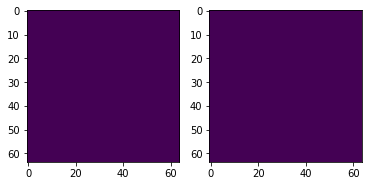

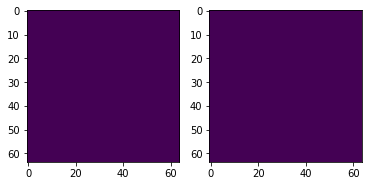

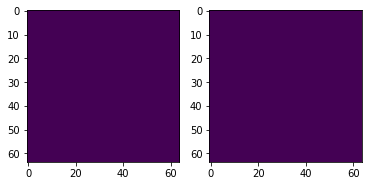

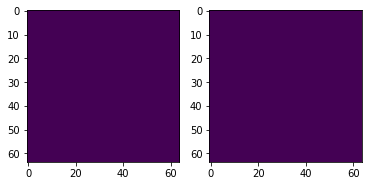

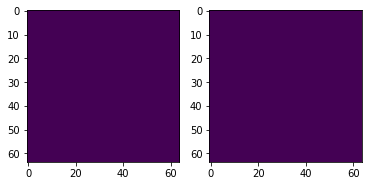

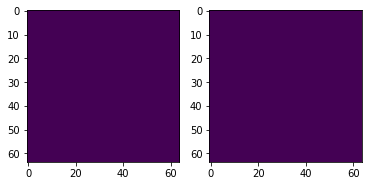

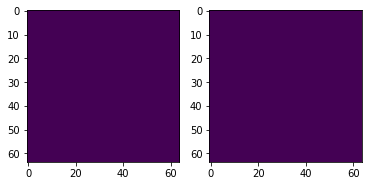

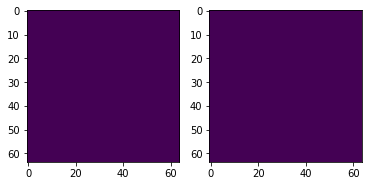

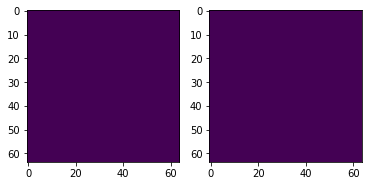

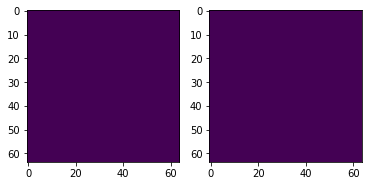

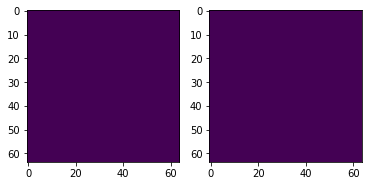

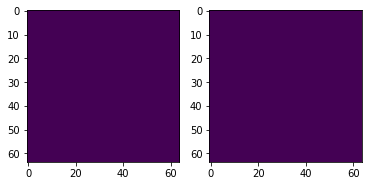

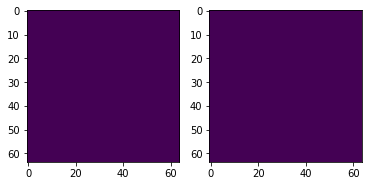

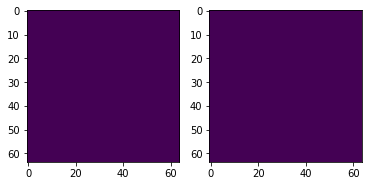

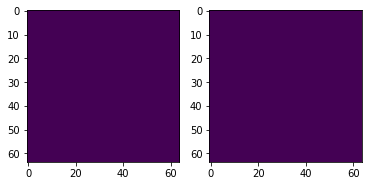

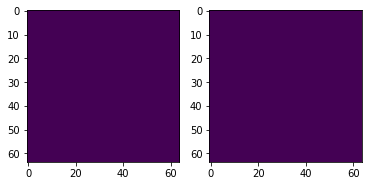

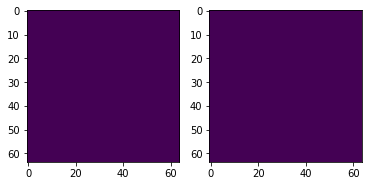

144
57
230
206
194
149
107
112
88
193
165
22
25
51
171
208
190
168
93
159
186
105
113
132
147
43
115
91
117
207
85
138
126
62
30
45
121
136
198
14
220
189
129
151
185
28
81
87
9
183
156
125
152
72
8
174
210
96
82
114
222
175
1
226
135
200
196
172
59
155
124
179
218
160
31
153
133
209
120
219
34
110
79
148
187
29
75
64
139
188
181
56
6
89
192
223
204
176
162
35
184
142
60
52
83
16
154
119
5
141
178
166
122
74
33
50
41
128
80
146
3
191
15
84
38
202
197
39
143
4
102
229
103
90
44
98
167
140
77
180
233
19
217
21
42
86
69
0
137
131
61
40
26
201
101
92
17
104
36
195
78
199
157
71
20
116
221
211
63
37
134
170
212
228
182
73
177
11
214
161
23
215
163
67
216
54
53
99
12
70
27
109
46
231
100
18
32
49
2
205
169
106
24
164
145
68
227
213
232
127
225
118
58
123
66
55
10
7
111
48
94
158
13
47
150
76
224
130
65
203
108
97
95
173
3
28
25
43
42
18
21
5
29
48
32
23
11
34
35
24
26
38
22
33
8
31
15
4
1
7
30
14
44
41
49
27
12
47
50
9
13
36
19
37
39
40
16
2
0
17
46
20
10
6
45
42
5
29
14
36
16
33
6
37
9
7
1


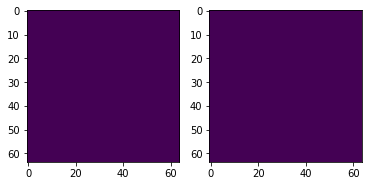

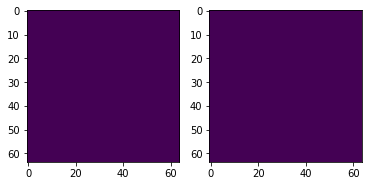

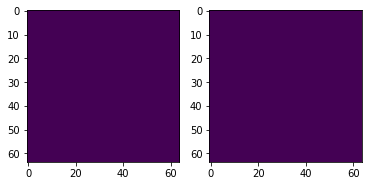

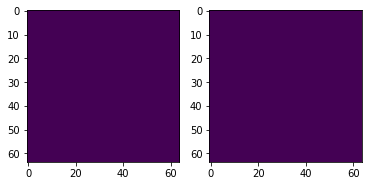

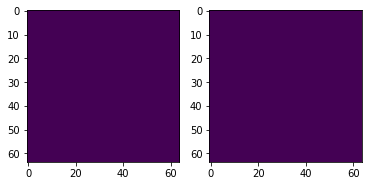

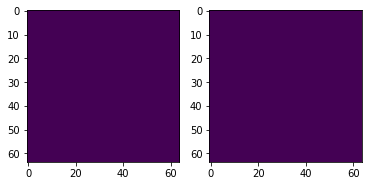

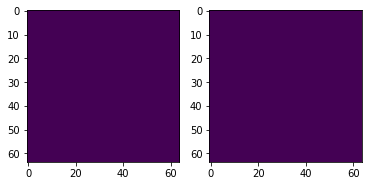

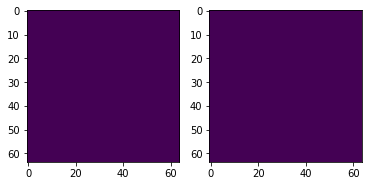

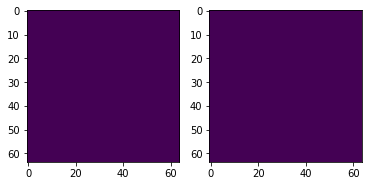

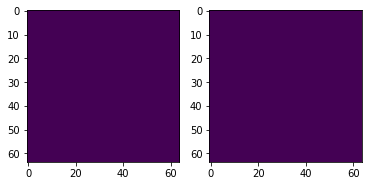

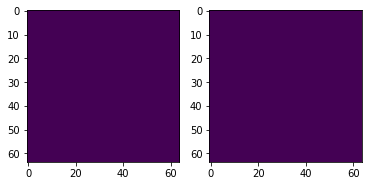

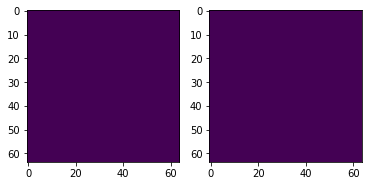

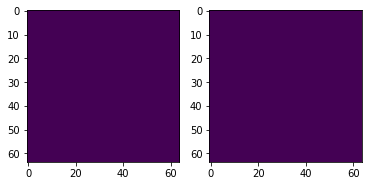

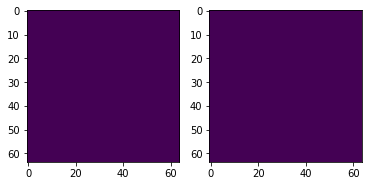

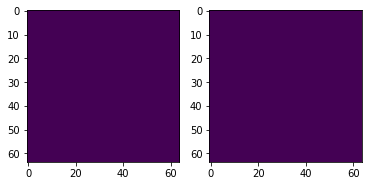

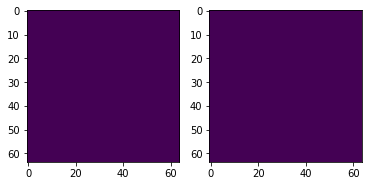

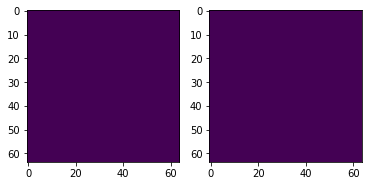

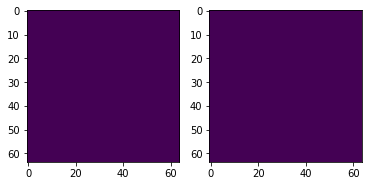

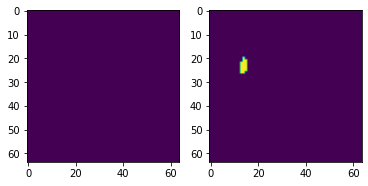

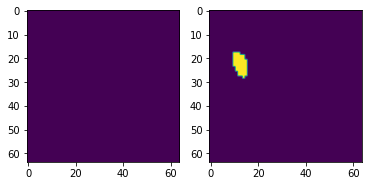

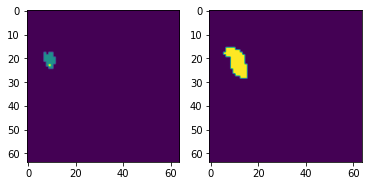

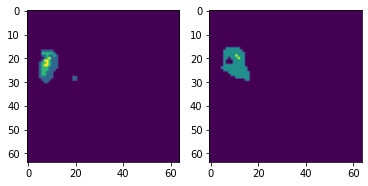

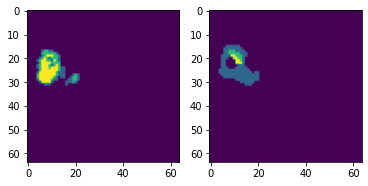

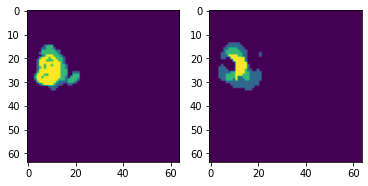

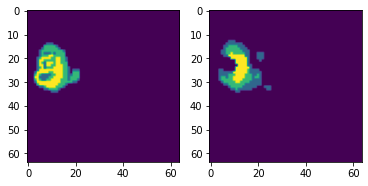

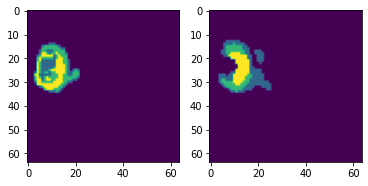

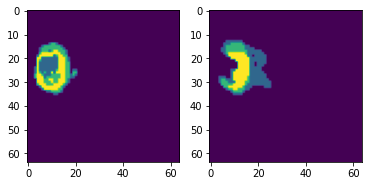

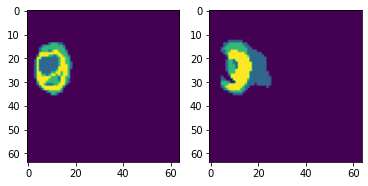

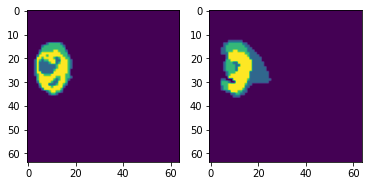

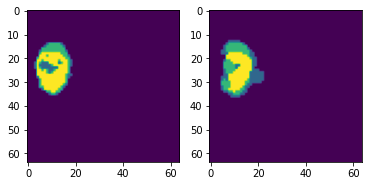

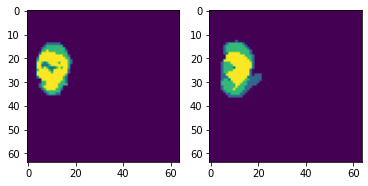

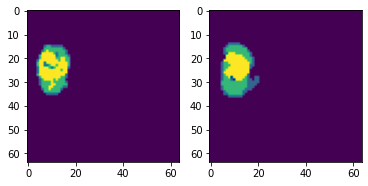

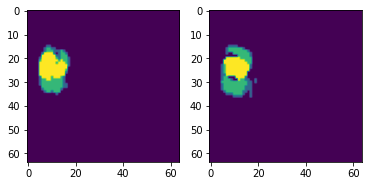

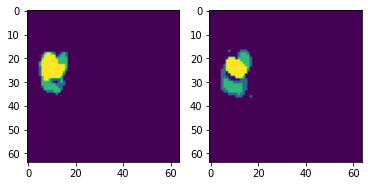

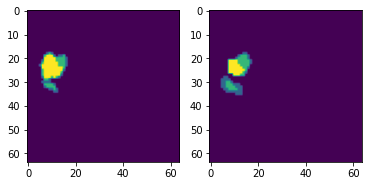

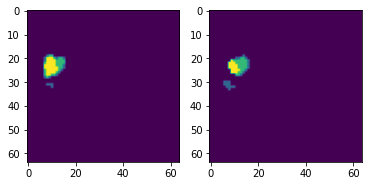

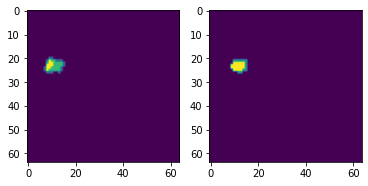

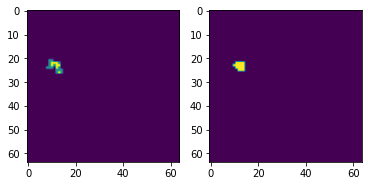

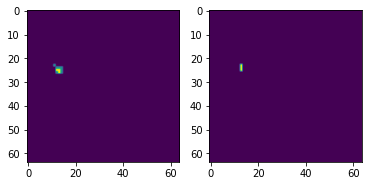

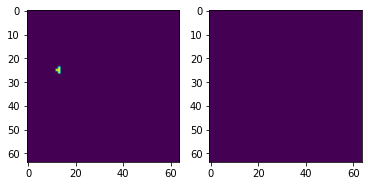

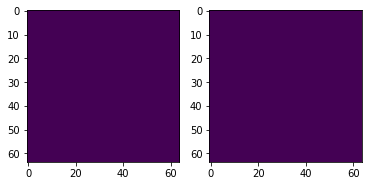

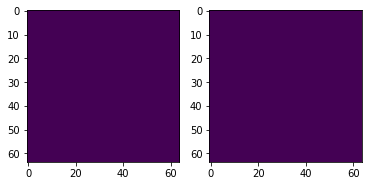

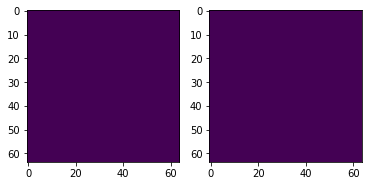

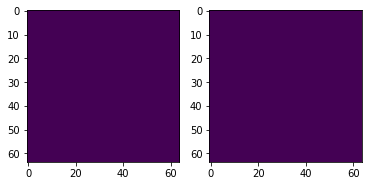

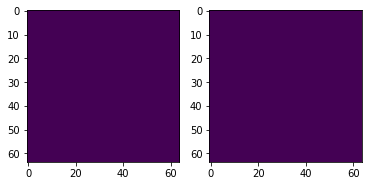

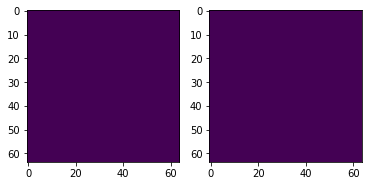

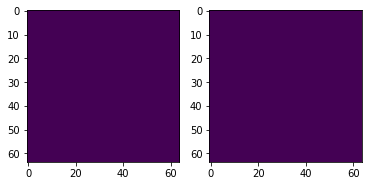

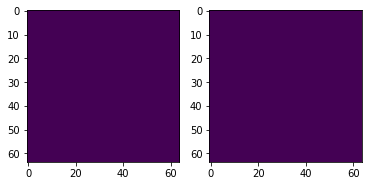

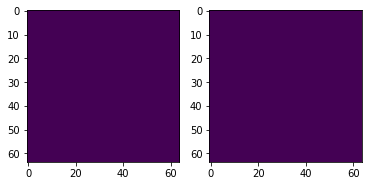

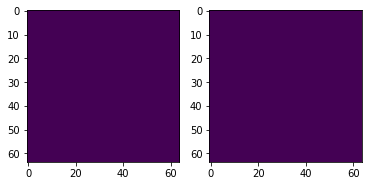

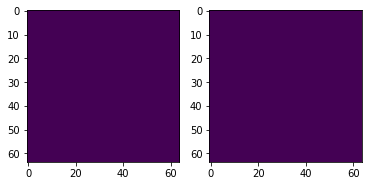

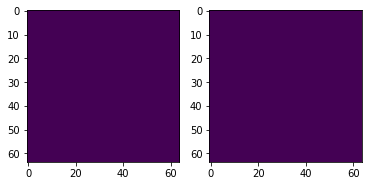

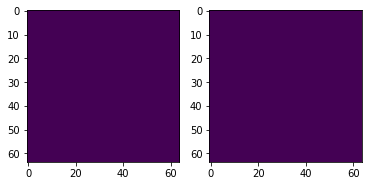

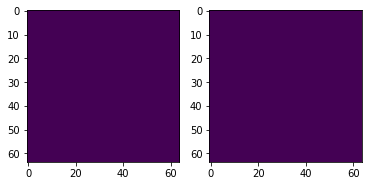

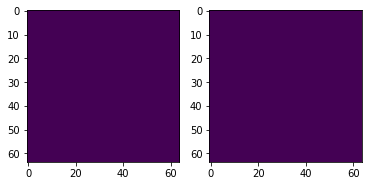

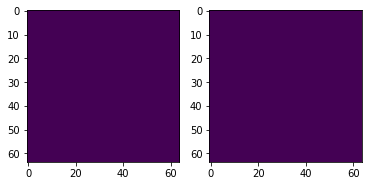

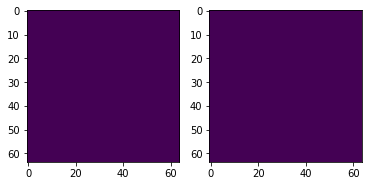

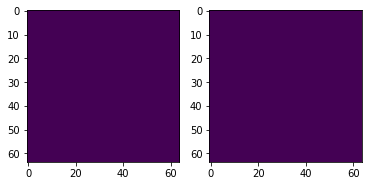

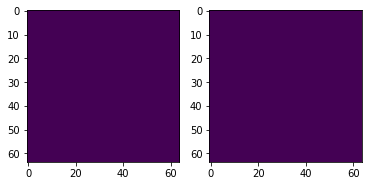

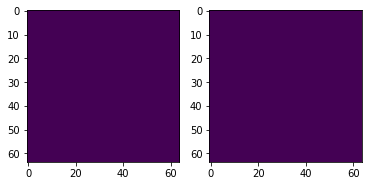

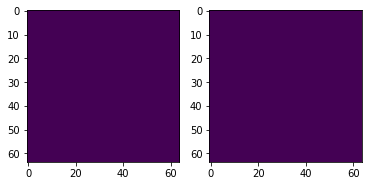

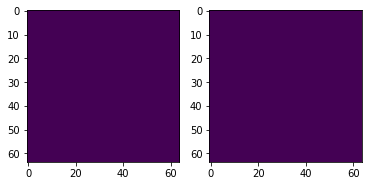

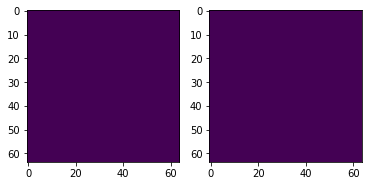

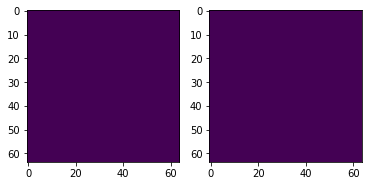

58
223
95
91
142
130
122
139
34
215
87
230
65
125
174
85
10
118
227
112
143
29
111
219
94
200
192
124
209
63
77
185
207
62
220
120
152
66
50
64
210
128
180
48
23
222
57
22
13
211
76
156
189
206
178
59
33
188
203
37
18
140
161
157
216
148
191
68
109
102
213
115
3
224
181
170
27
75
90
4
26
55
42
81
225
164
218
182
46
5
205
123
39
30
153
44
199
106
25
121
19
194
198
80
31
163
160
134
108
150
52
190
82
186
0
202
17
7
137
92
119
67
28
171
176
79
208
144
8
168
24
45
133
97
70
167
83
141
61
2
51
117
89
99
36
32
11
98
116
105
12
135
233
103
93
136
6
21
165
204
35
145
126
221
104
158
88
217
86
53
40
184
175
169
41
197
107
232
166
71
38
113
74
20
228
179
226
60
1
49
129
212
47
183
177
56
187
14
149
146
147
201
195
72
16
69
132
172
229
54
151
84
96
110
127
114
193
131
73
159
101
231
214
43
78
15
154
138
9
162
196
173
155
100
4
44
35
19
46
47
24
45
12
37
11
9
3
13
43
32
14
40
49
20
0
34
16
31
1
2
33
26
22
10
30
25
23
48
42
27
38
28
8
50
15
41
39
21
17
6
36
5
18
7
29
22
46
14
18
32
49
41
21
26
20
0

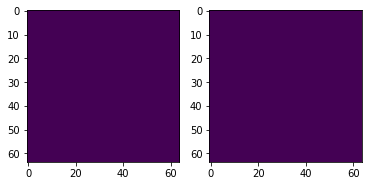

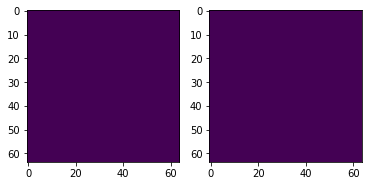

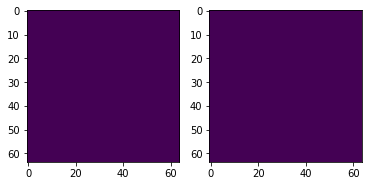

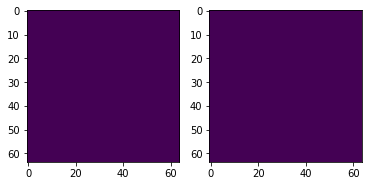

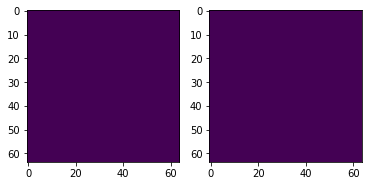

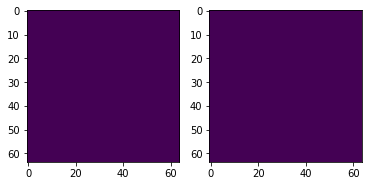

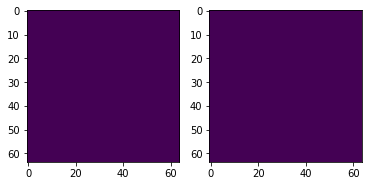

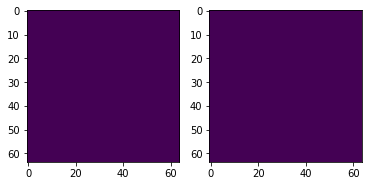

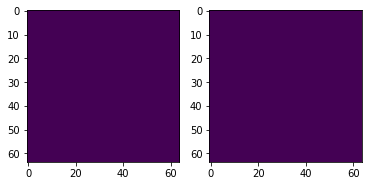

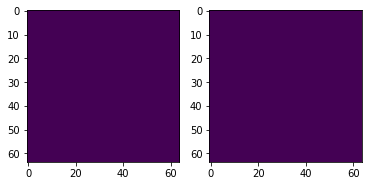

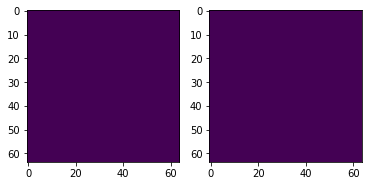

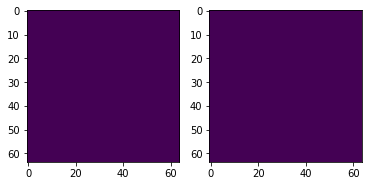

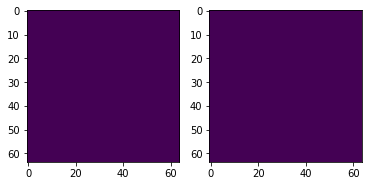

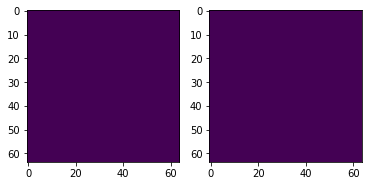

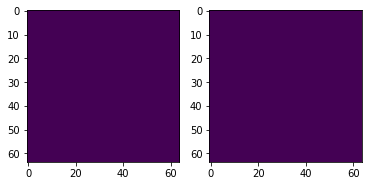

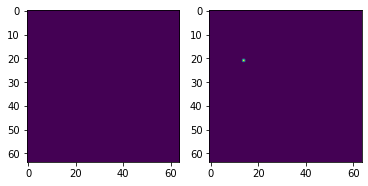

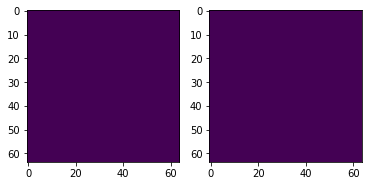

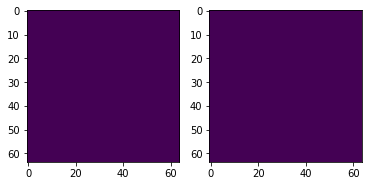

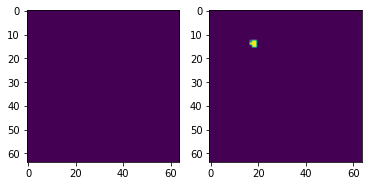

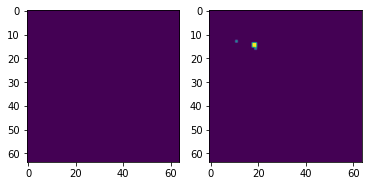

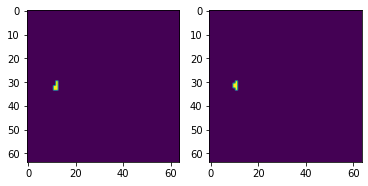

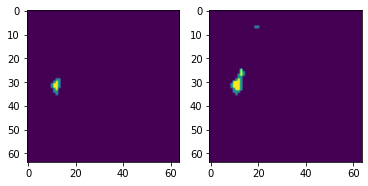

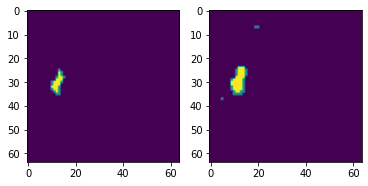

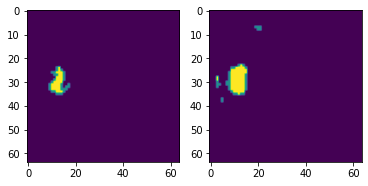

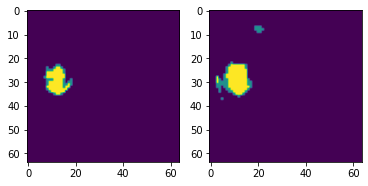

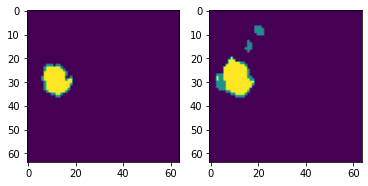

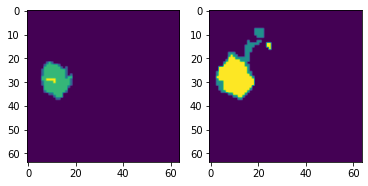

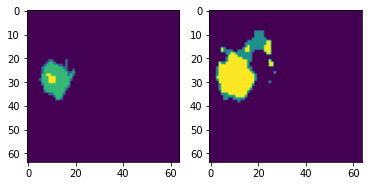

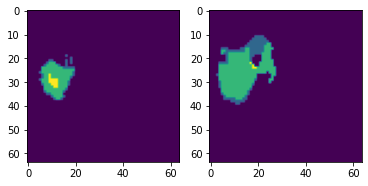

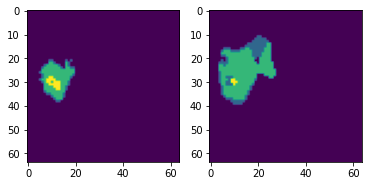

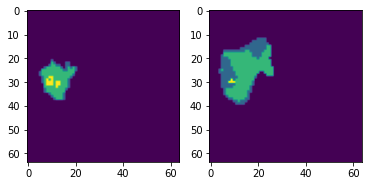

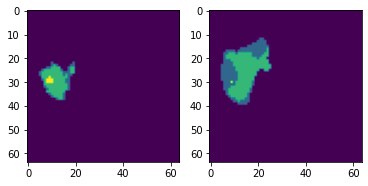

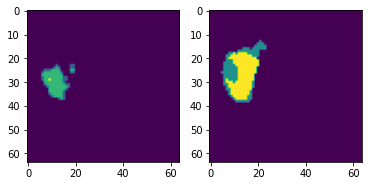

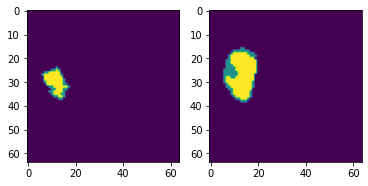

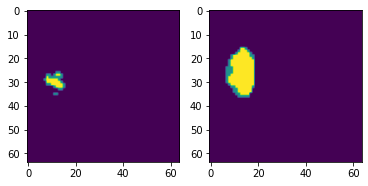

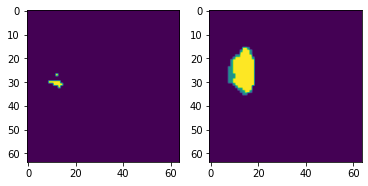

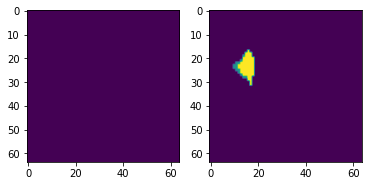

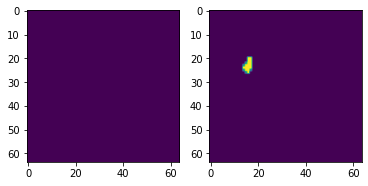

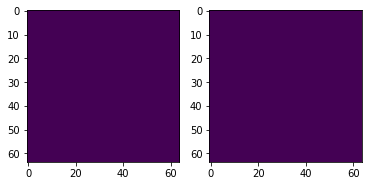

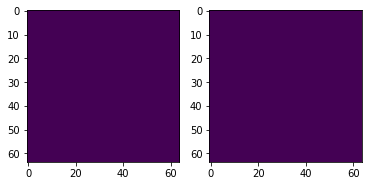

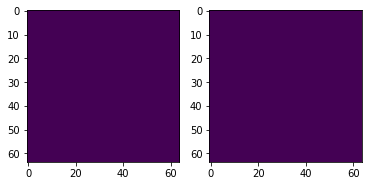

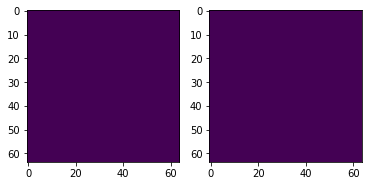

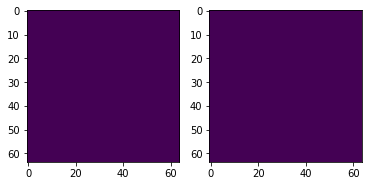

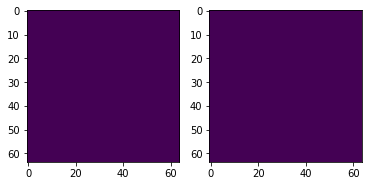

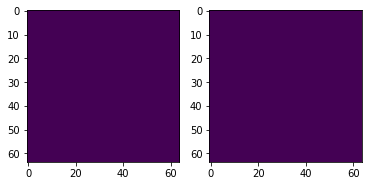

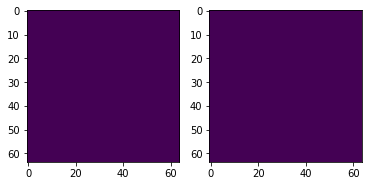

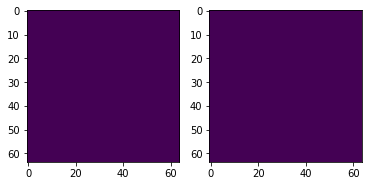

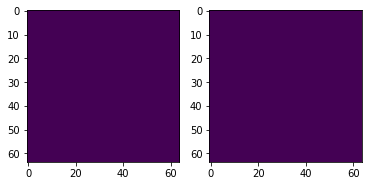

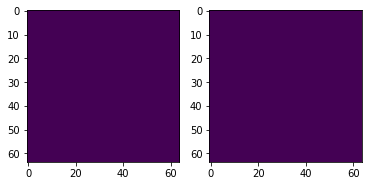

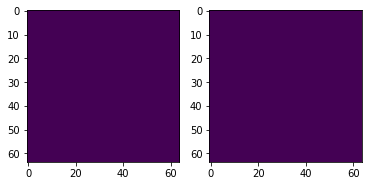

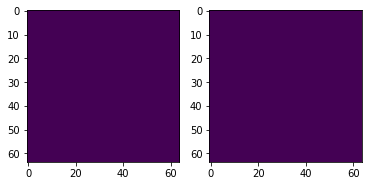

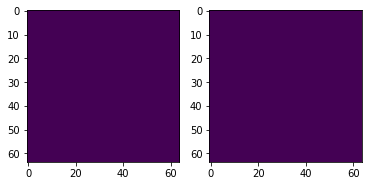

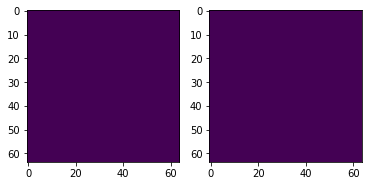

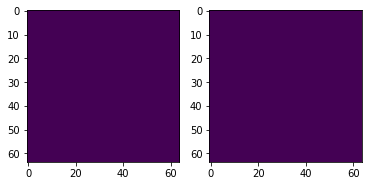

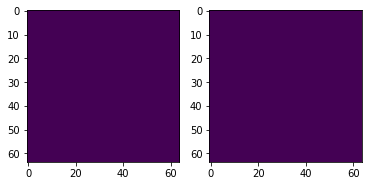

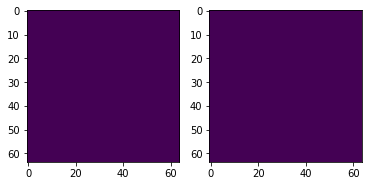

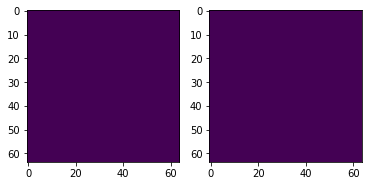

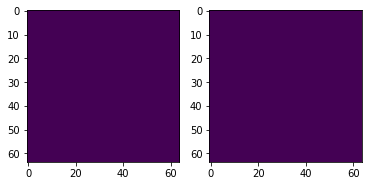

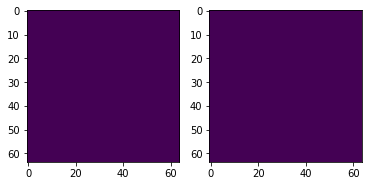

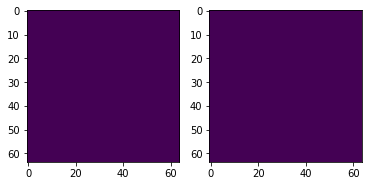

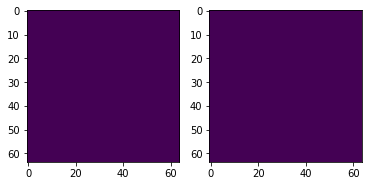

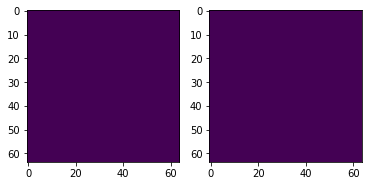

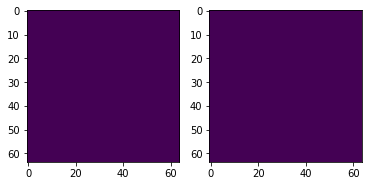

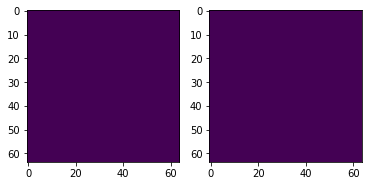

81
231
122
168
87
25
66
89
178
147
61
156
171
29
196
15
23
227
214
116
77
22
101
110
21
103
174
164
189
204
144
135
10
119
123
215
211
142
151
146
159
141
88
98
31
128
228
129
112
18
64
193
82
24
74
40
190
75
11
139
225
163
167
99
202
32
17
117
83
220
97
121
175
233
27
4
9
132
120
47
165
169
94
16
95
91
219
149
210
46
52
96
7
200
218
205
68
3
140
118
152
0
54
143
90
50
60
78
181
49
114
217
126
53
197
148
59
180
80
108
13
39
92
73
34
58
208
41
199
232
187
201
206
65
71
179
1
43
109
37
14
191
93
125
100
182
63
42
107
67
145
2
184
85
104
20
224
154
45
155
161
172
12
230
76
186
221
176
55
84
62
72
207
134
8
127
183
212
30
229
56
44
26
173
137
166
216
195
69
57
38
79
223
185
5
111
133
51
153
35
162
138
113
158
19
194
192
177
150
105
226
136
160
48
86
102
188
130
124
209
106
28
33
131
36
222
6
198
213
170
157
115
203
70
12
43
14
29
13
36
22
6
34
50
11
0
42
46
15
2
32
35
31
39
37
23
45
49
1
44
5
16
47
48
33
4
10
25
17
41
3
18
27
26
20
24
28
30
38
9
8
19
7
21
40
36
11
4
7
33
27
12
37
19
0
43
3

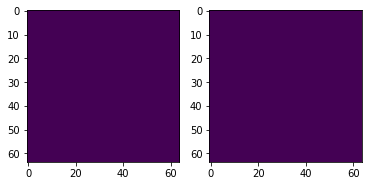

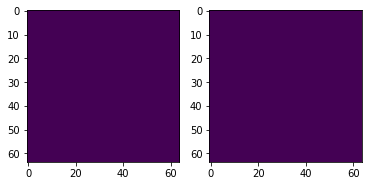

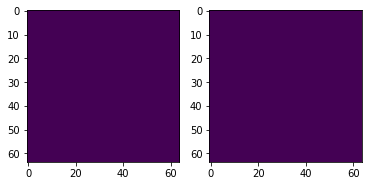

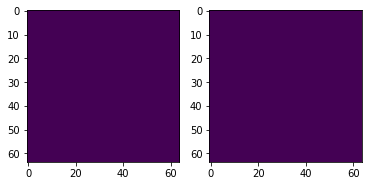

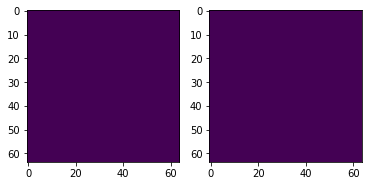

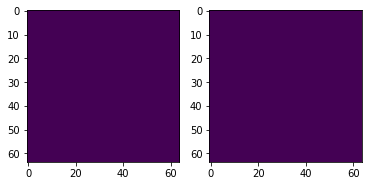

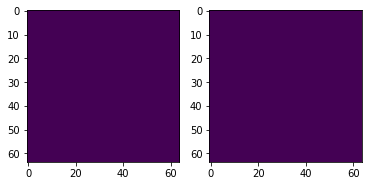

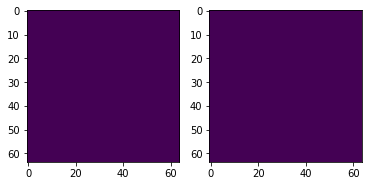

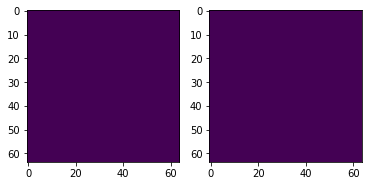

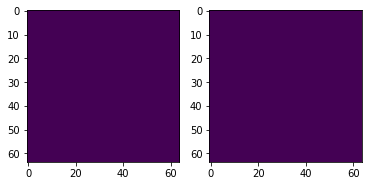

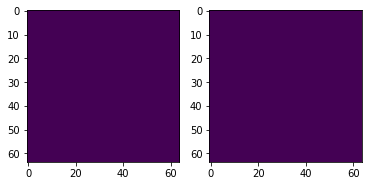

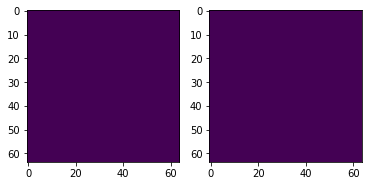

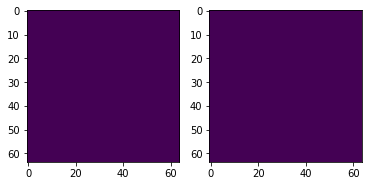

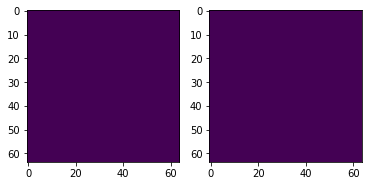

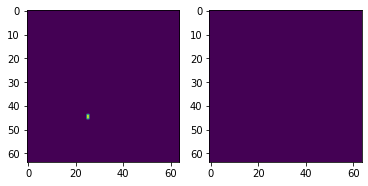

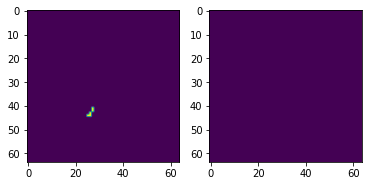

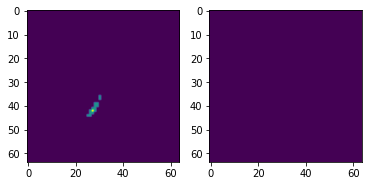

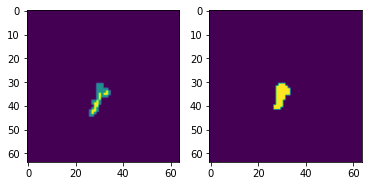

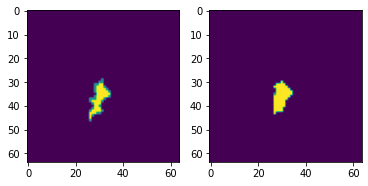

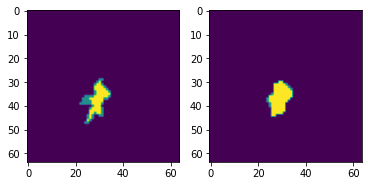

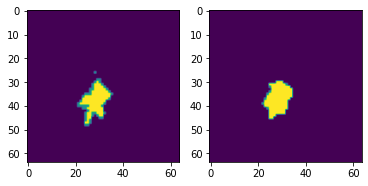

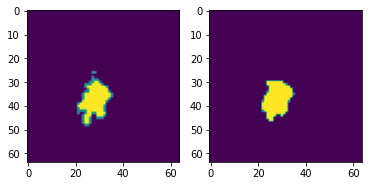

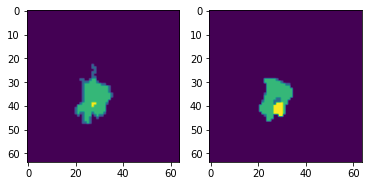

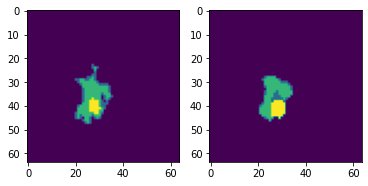

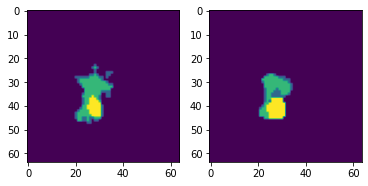

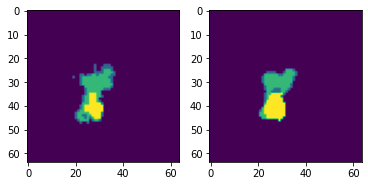

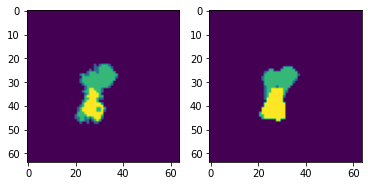

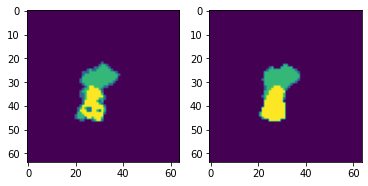

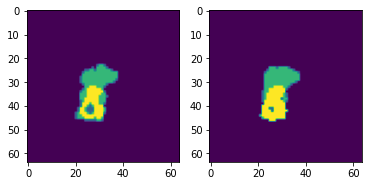

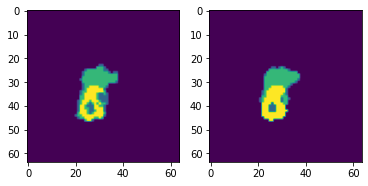

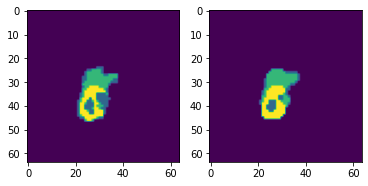

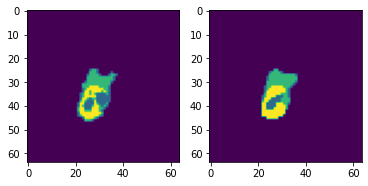

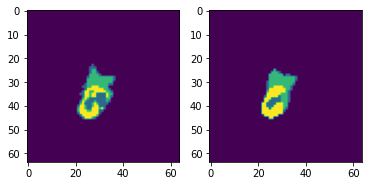

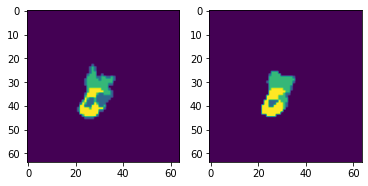

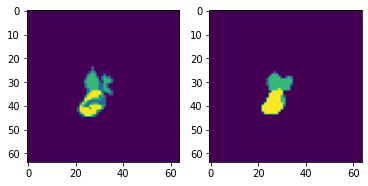

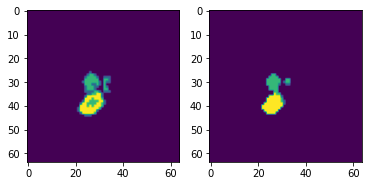

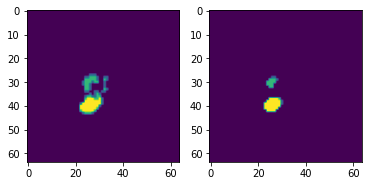

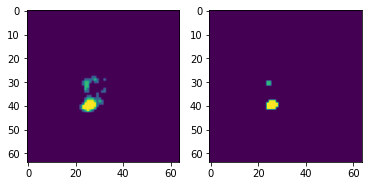

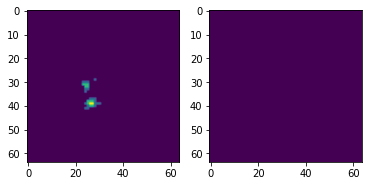

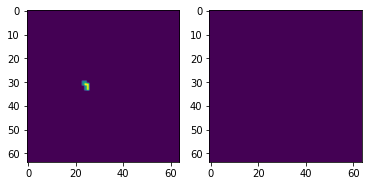

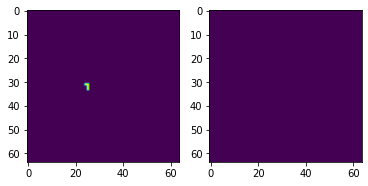

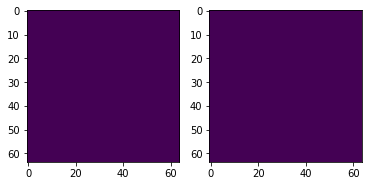

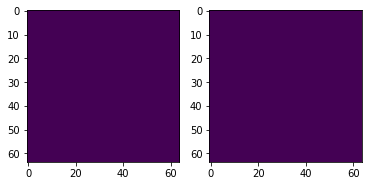

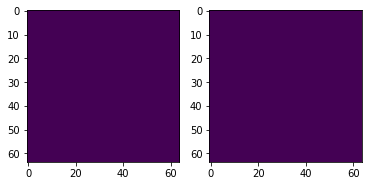

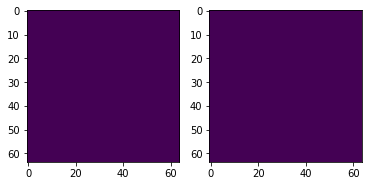

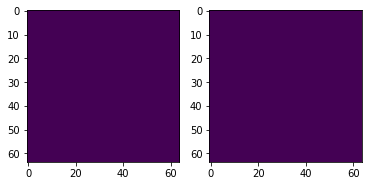

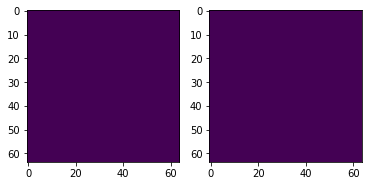

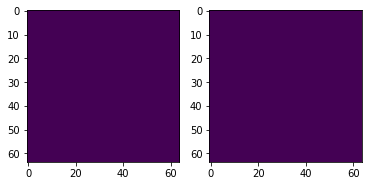

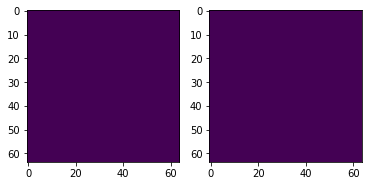

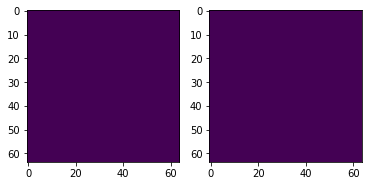

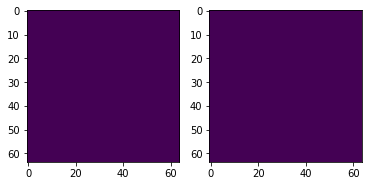

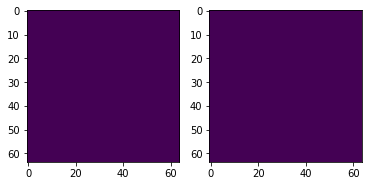

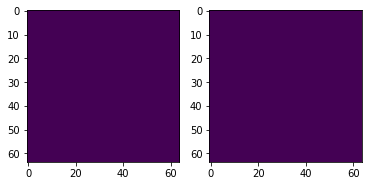

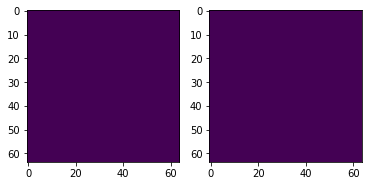

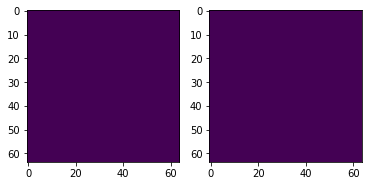

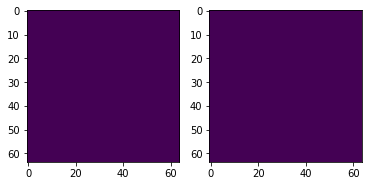

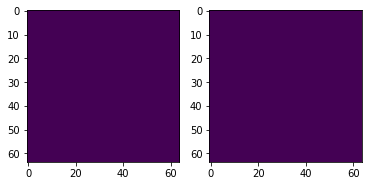

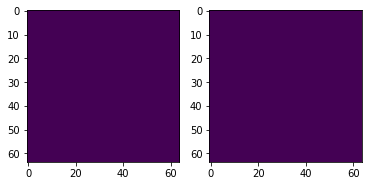

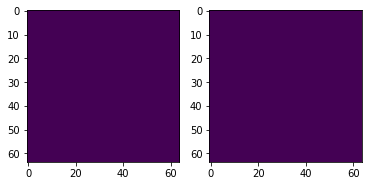

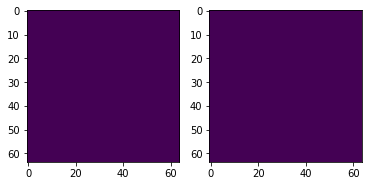

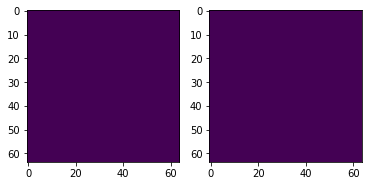

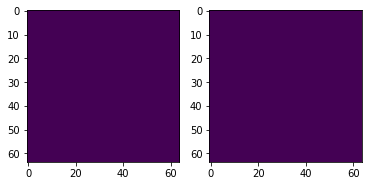

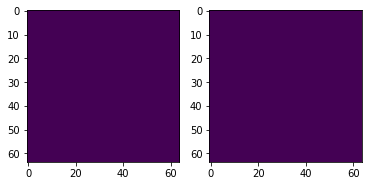

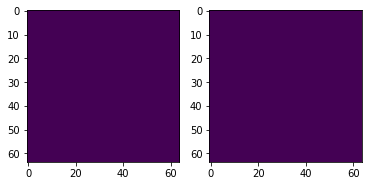

87
160
214
79
22
217
224
60
21
227
88
111
94
39
208
163
125
145
223
100
101
221
166
144
164
56
222
228
155
27
50
38
90
95
33
112
12
187
54
64
138
193
58
123
157
127
48
171
66
167
194
201
179
165
32
205
118
57
169
47
7
121
98
36
68
197
5
9
73
92
190
55
24
105
63
42
215
134
99
143
91
188
49
146
6
80
175
35
114
135
230
75
3
26
96
97
34
11
43
51
209
44
126
2
177
106
212
131
198
207
140
141
89
196
115
199
116
69
84
139
122
71
213
102
232
216
113
148
65
137
170
233
30
229
226
17
159
18
219
142
181
231
192
178
108
16
86
180
23
76
147
150
158
191
183
67
15
162
130
173
153
172
82
103
74
0
136
132
13
45
40
107
161
83
206
81
70
41
85
93
174
218
124
128
72
37
120
156
168
176
195
184
29
220
61
225
151
119
10
133
204
4
152
46
52
186
104
1
202
182
210
19
109
154
77
25
8
129
149
78
185
211
28
20
203
117
200
189
110
31
59
62
14
53
11
48
1
15
40
41
2
35
26
37
22
6
14
39
44
8
23
49
50
46
19
34
7
30
5
43
18
42
24
3
27
45
25
20
31
10
32
33
0
16
4
13
38
47
28
36
21
17
9
29
12
46
18
35
29
23
10
19
22
9
14
38

In [ ]:
image_size = 64

import time
start_time = time.time()



epochs = 40
ep = 1000
batch_size = 2
num_batches = 10


model_name = "Tumor Seg only tumor binary 64 1"

shuffling = True

model = ConvNet5(image_size,image_size,image_size)
model.compile(optimizer = keras.optimizers.Adam(lr=0.00001), loss=tversky_loss, metrics=tf.keras.metrics.MeanIoU(num_classes=4))
#model.compile(optimizer = keras.optimizers.Adam(lr=0.0001), loss=weighted_bce, metrics=['mse'])

n = 0
train_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Train Images " + str(n) + ".h5"
train_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Train Masks " + str(n) + ".h5"
val_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Val Images " + str(n) + ".h5"
val_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Val Masks " + str(n) + ".h5"
test_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Test Images " + str(n) + ".h5"
test_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Test Masks " + str(n) + ".h5"

if not os.path.exists("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/" + model_name):
    os.makedirs("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/" + model_name)

train_gen = DataGen(train_images_path, train_masks_path, batch_size=batch_size, image_size=image_size)
valid_gen = DataGen(val_images_path, val_masks_path, batch_size=batch_size, image_size=image_size)
test_gen = DataGen(test_images_path, test_masks_path, batch_size=batch_size, image_size=image_size)


x, y = train_gen.__getitem__(1)
print("x shape",x.shape)
print(np.min(x))
print("y shape",y.shape)
print(np.min(y))


def train(train_gen, valid_gen, test_gen, model_number):
    print("Training set " + str(i+1) + str(n+1)+" out of " + str(ep) + " sets...")

    train_steps = train_gen.data_size//batch_size
    valid_steps = valid_gen.data_size//batch_size

    model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, shuffle=True)

    ## Save the Weights

    model.save("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/" + model_name + "/Model " + model_number +".h5")

    print('trainted one model in', int((time.time() - start_time)/60), 'minutes and ', int((time.time() - start_time) % 60), 'seconds.')


last_images = 0
for i in range(0,ep):
    for n in range(0, num_batches//3):
        '''start = n*3
        fin = start+3
        if fin>=num_batches:
          fin = num_batches-1
        train_gen,valid_gen,test_gen = get_data(start,fin)'''
        if shuffling:
            train_gen.shuffle_da_set()
            valid_gen.shuffle_da_set()
            test_gen.shuffle_da_set()

        train(train_gen,valid_gen,test_gen, (str(i+1)+str(n+1)))


        ## Dataset for prediction
        if True:#(((i*10)+n)*epochs)/40>last_images:
            last_images += 1
            x, y = test_gen.__getitem__(1)

            print(y.shape)
            print("max:",np.max(y))
            result = model.predict(x)
            print(result.shape)
            print("max:",np.max(result))

            #result = result > 0.5

            r = random.randint(0, len(y)-1)
            gt = np.argmax(y[r], axis=3)
            print(gt.shape)
            print("gt unique:",np.unique(gt))
            pred = np.argmax(result[r], axis=3)
            print(pred.shape)
            print("pred unique:",np.unique(pred))
            for n, image in enumerate(np.argmax(y[r], axis=3)):
                fig = plt.figure()
                #fig.subplots_adjust(hspace=0.4, wspace=0.4)
                ax = fig.add_subplot(1, 2, 1)
                ax.imshow(image)
                ax = fig.add_subplot(1, 2, 2)
                ax.imshow(np.argmax(result[r][n], axis = 2))


                plt.show()
                    
            

(1, 128, 128, 128, 1)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(1, 128, 128, 128, 1)
max: 1.0
max:  0.2751673
(1, 128, 128, 128, 1)
max: 0.2751673


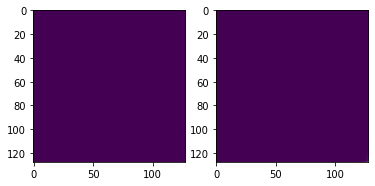

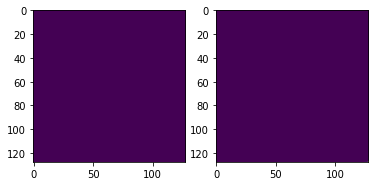

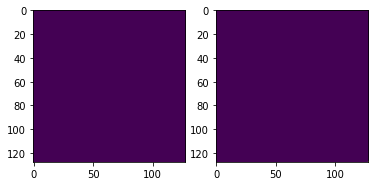

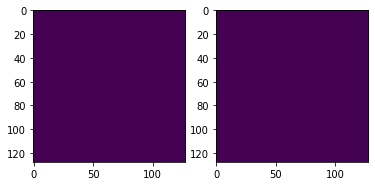

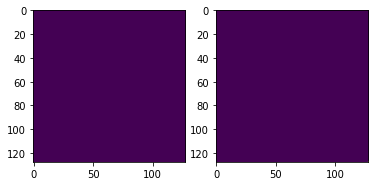

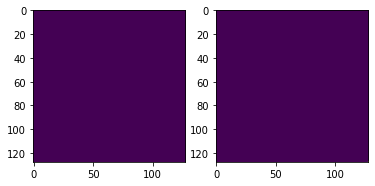

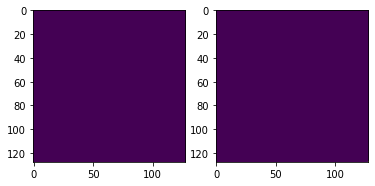

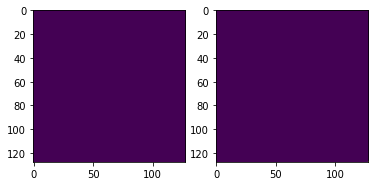

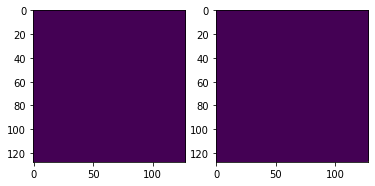

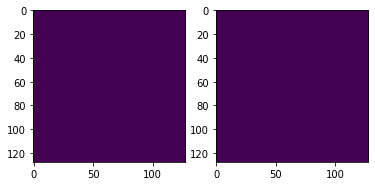

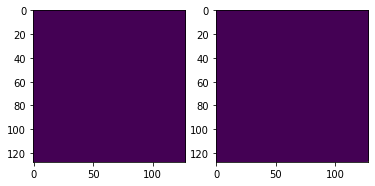

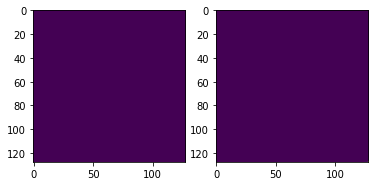

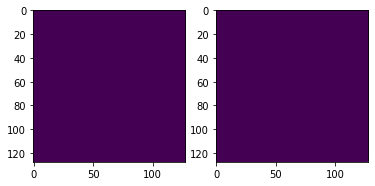

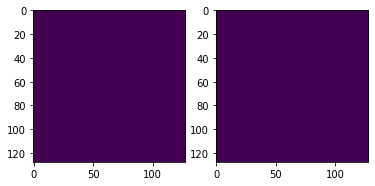

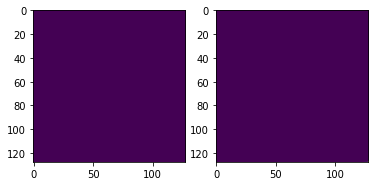

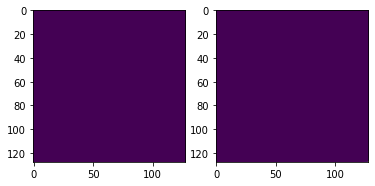

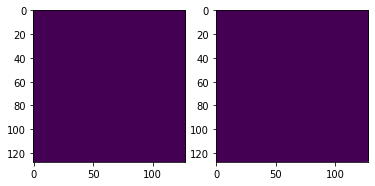

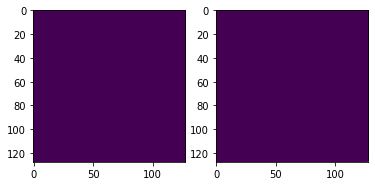

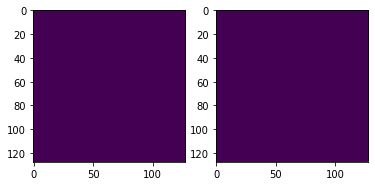

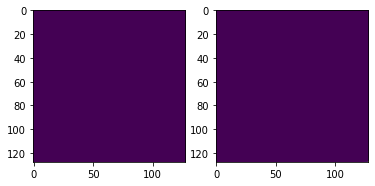

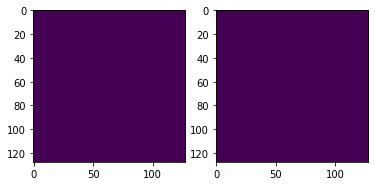

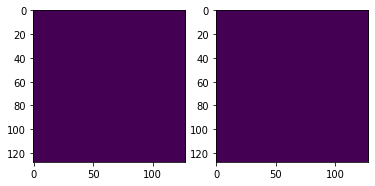

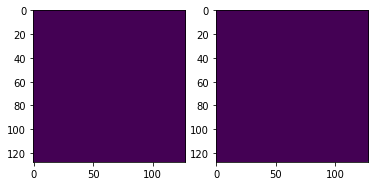

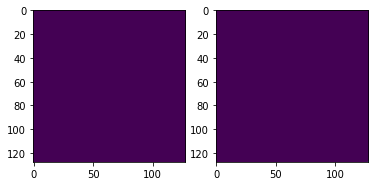

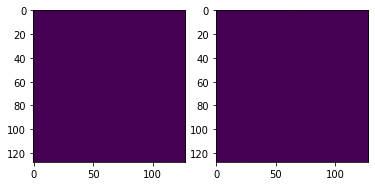

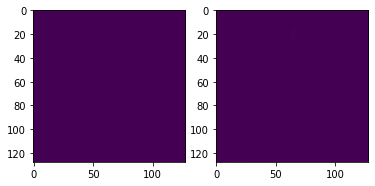

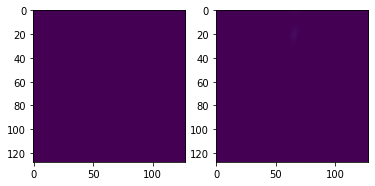

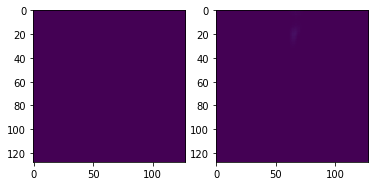

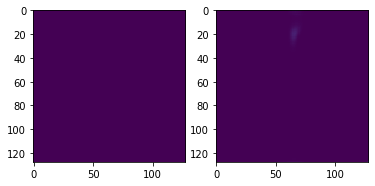

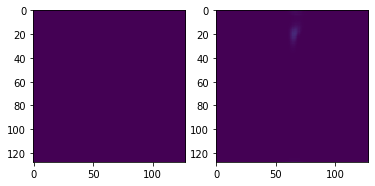

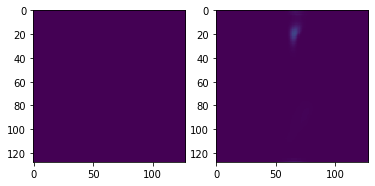

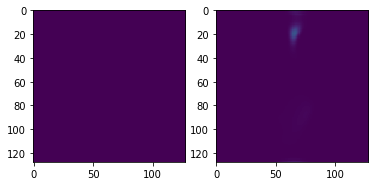

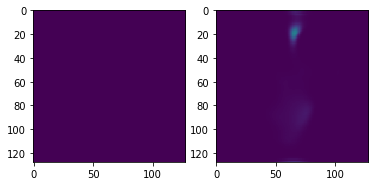

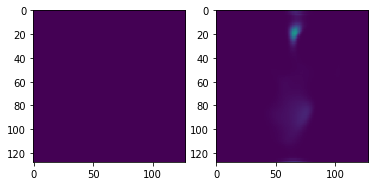

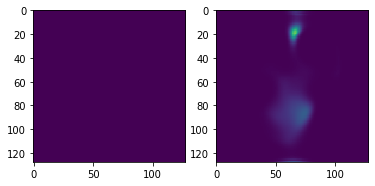

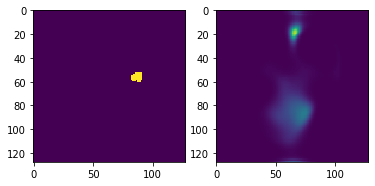

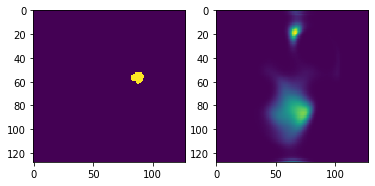

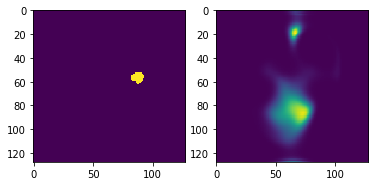

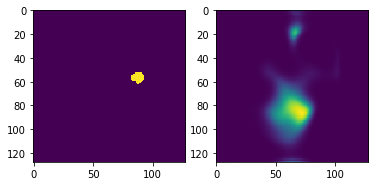

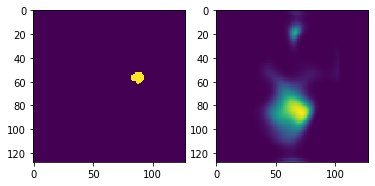

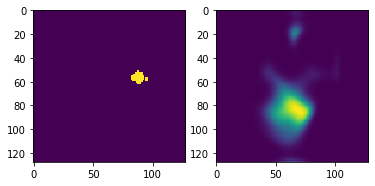

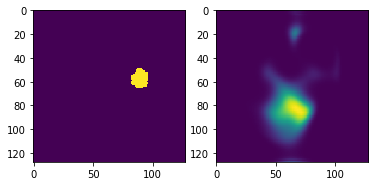

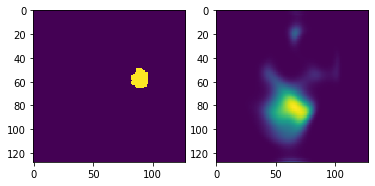

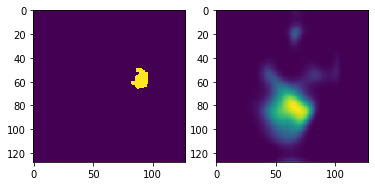

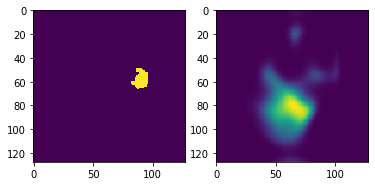

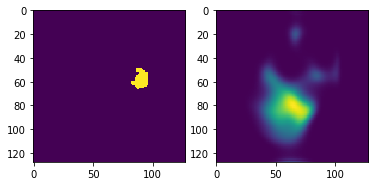

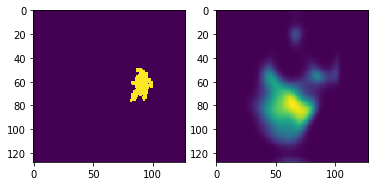

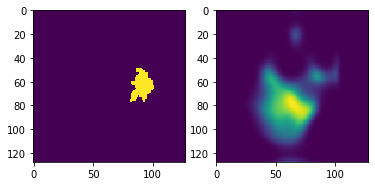

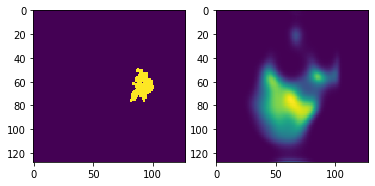

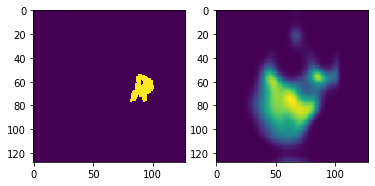

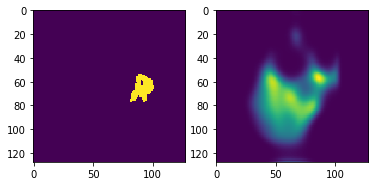

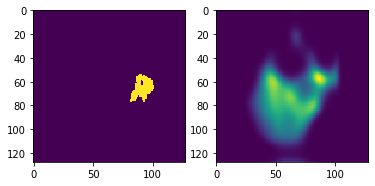

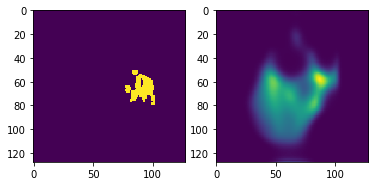

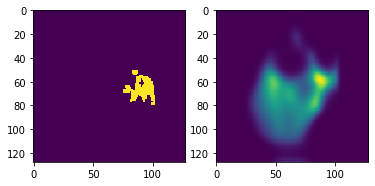

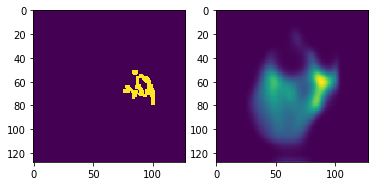

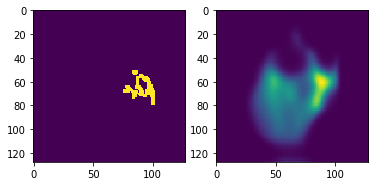

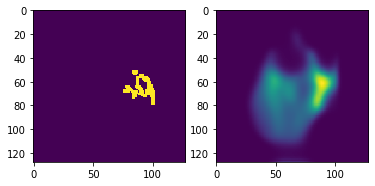

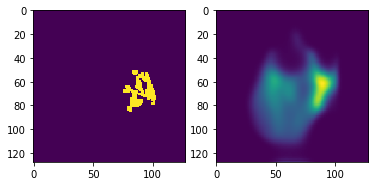

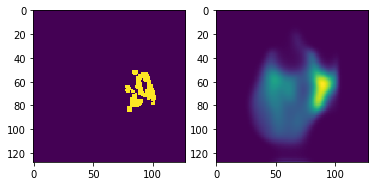

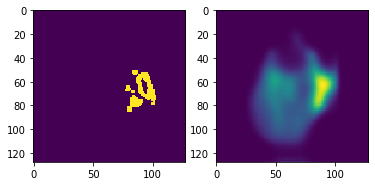

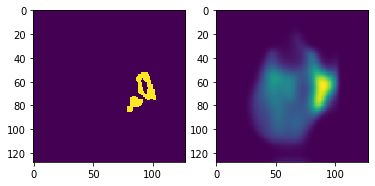

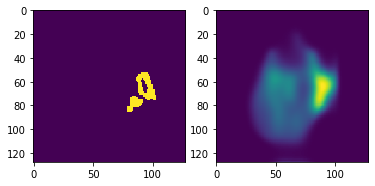

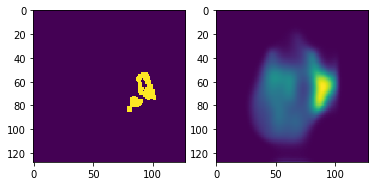

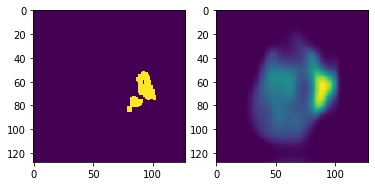

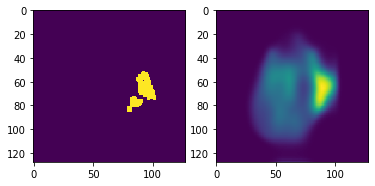

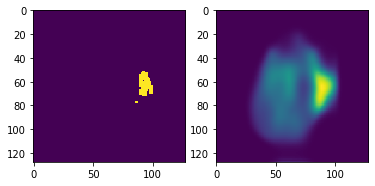

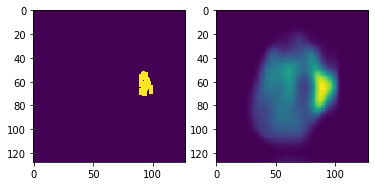

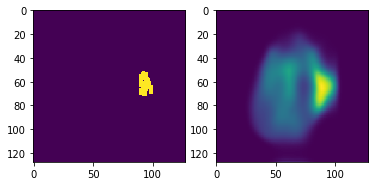

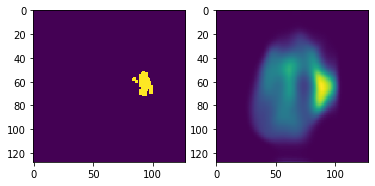

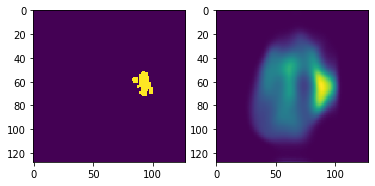

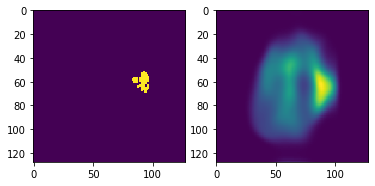

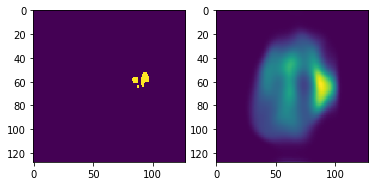

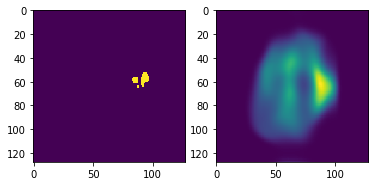

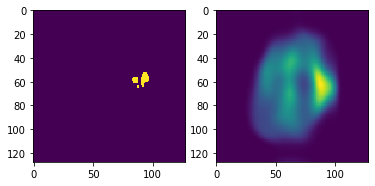

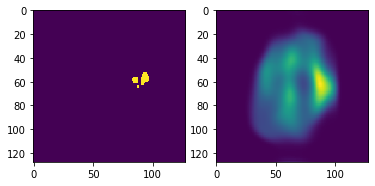

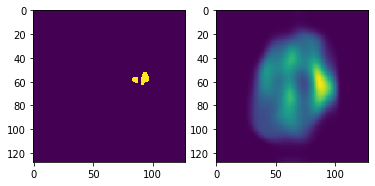

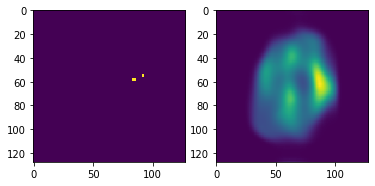

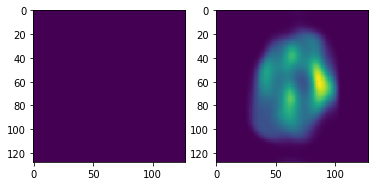

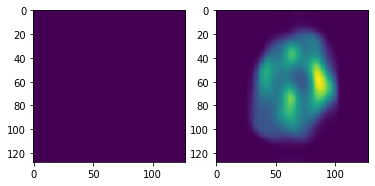

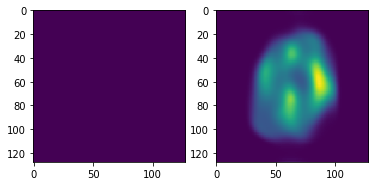

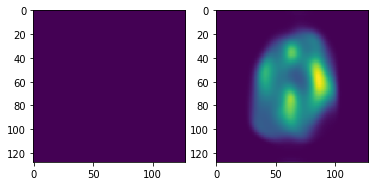

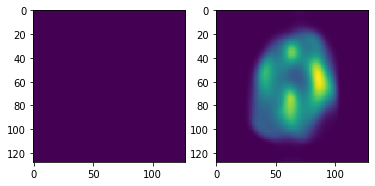

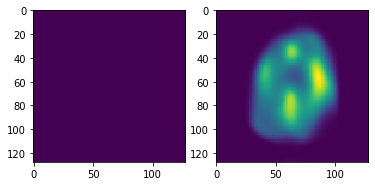

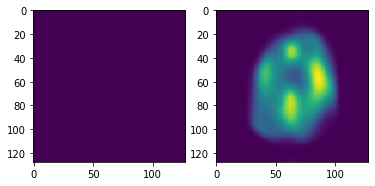

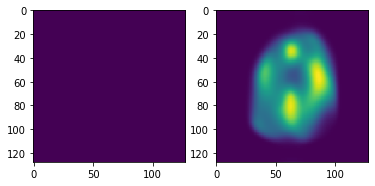

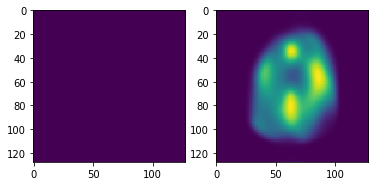

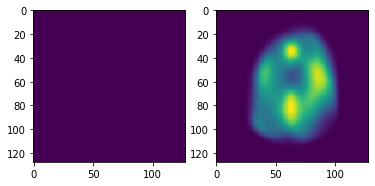

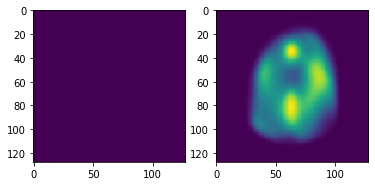

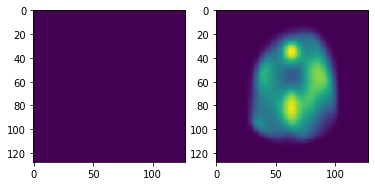

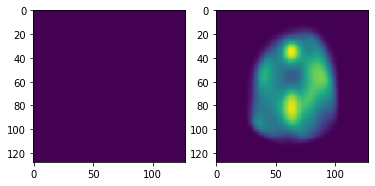

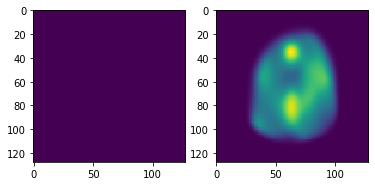

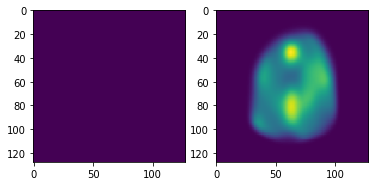

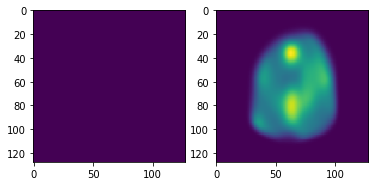

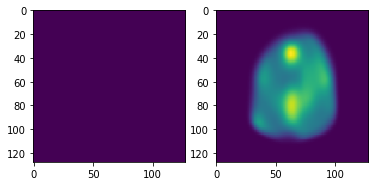

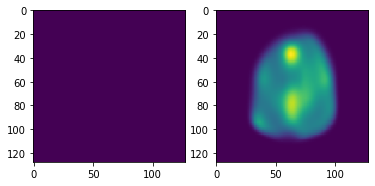

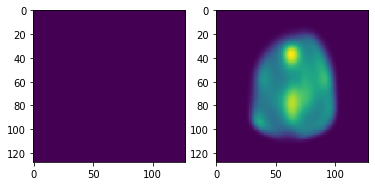

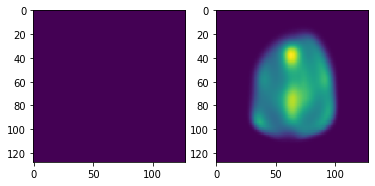

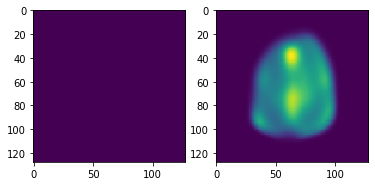

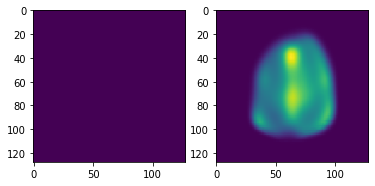

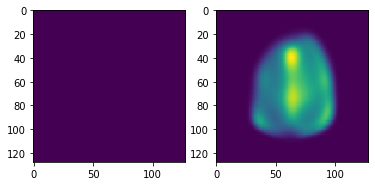

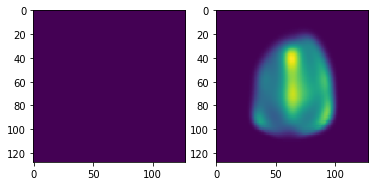

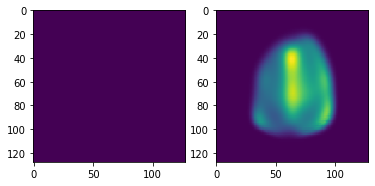

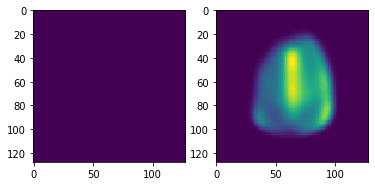

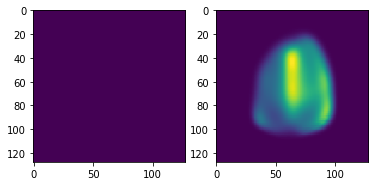

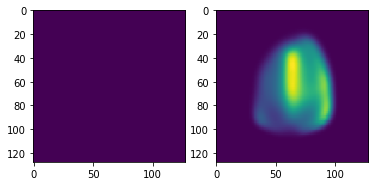

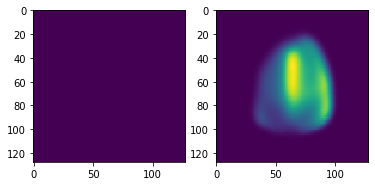

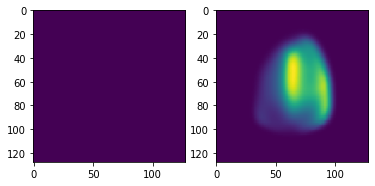

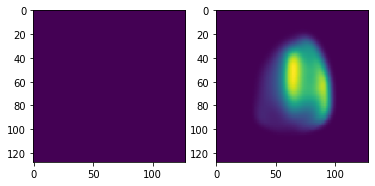

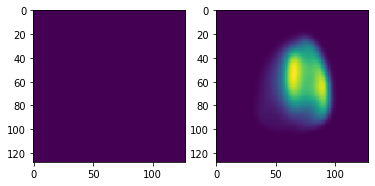

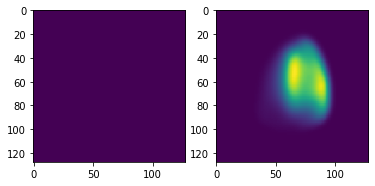

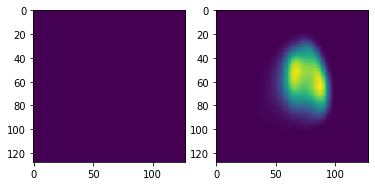

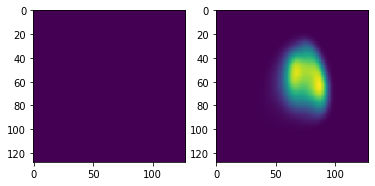

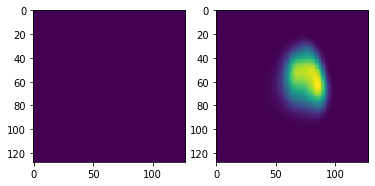

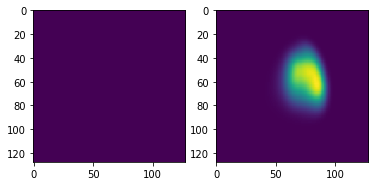

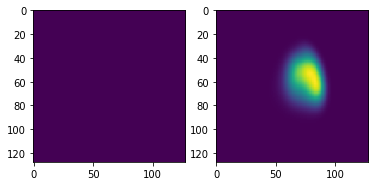

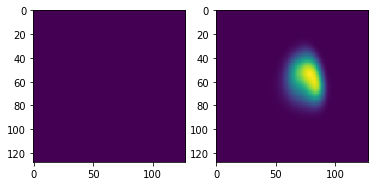

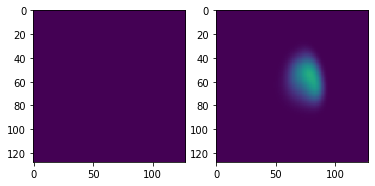

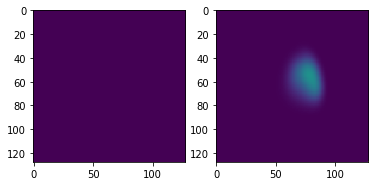

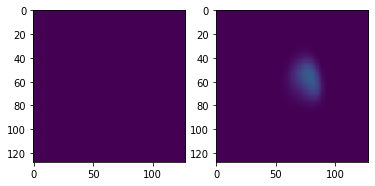

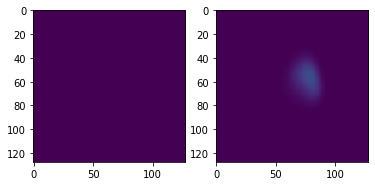

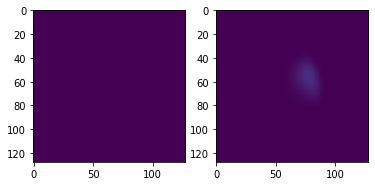

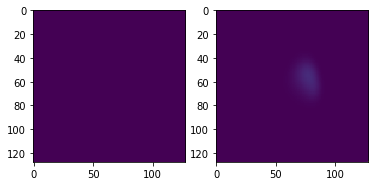

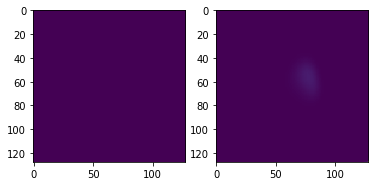

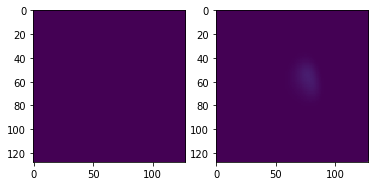

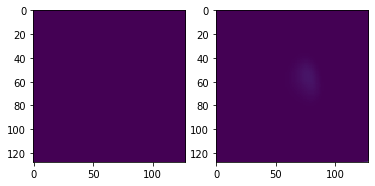

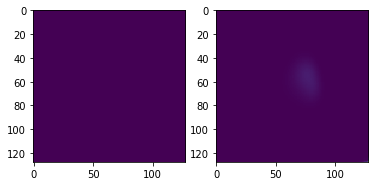

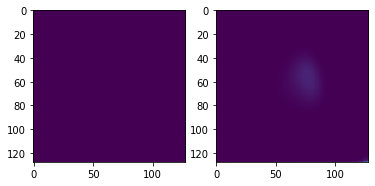

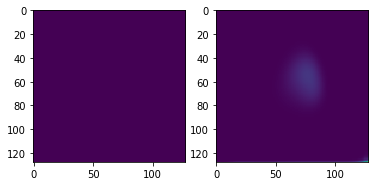

In [ ]:
test_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Separated into 64 datapoint batches for Brain Seg/Test Images 0.h5"
test_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Separated into 64 datapoint batches for Brain Seg/Test Masks 0.h5"

batch_size = 1
image_size = 128

test_gen = DataGen(test_images_path, test_masks_path, batch_size=batch_size, image_size=image_size)

x, y = test_gen.get_array(4)
print(x.shape)



#model = keras.models.load_model("/content/drive/My Drive/Tumor Segmentation Project/Trained Models/Segmented Brain -> Segmented Tumor/Model 1 (Tumor Seg Model 2) precise but only center")
#model = keras.models.load_model("/content/drive/My Drive/Tumor Segmentation Project/Trained Models/Segmented Brain -> Segmented Tumor/Model 2 (Tumor Seg 7) Trained with model 1 and higlights entire but not precise")

model = keras.models.load_model("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/Brain Seg Model 8/Model 34")

asdf = x.copy()
print(y.shape)
print("max:",np.max(y))
result = model.predict(x)
print("max: ", np.max(result))
print(result.shape)
print("max:",np.max(result))
x[result < 0.5*(np.max(result))] = 0
asdf[y == 0] = 0

r = 0

for n, image_ in enumerate(y[r]):
    fig = plt.figure()
    #fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.squeeze(y[r][n], axis = 2))
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(result[r][n], axis = 2))


    plt.show()

INITING
INITING
INITING
x shape (1, 64, 64, 64, 3)
0.0
y shape (1, 64, 64, 64, 4)
0.0
189
83
140
58
136
2
197
27
25
85
176
178
43
151
163
0
67
209
132
54
228
44
49
190
45
90
102
51
195
204
205
24
39
48
37
166
167
147
111
22
8
26
158
107
6
162
106
52
3
149
113
36
109
220
233
137
210
118
232
214
21
105
1
59
217
218
154
142
60
202
70
64
77
161
56
120
135
170
28
19
57
98
65
94
128
74
188
40
215
168
20
139
30
143
88
187
10
184
213
164
69
146
175
171
78
5
194
117
15
134
62
177
211
200
16
165
156
89
169
72
114
7
207
196
122
81
185
32
63
66
115
152
100
112
11
191
121
42
125
71
186
219
208
76
224
226
116
193
159
104
55
138
84
181
225
31
108
86
150
221
155
179
124
12
96
148
130
198
222
229
127
101
227
119
123
103
212
29
53
183
126
144
223
141
9
180
4
75
61
23
199
97
201
18
174
133
172
46
99
206
182
203
91
110
92
80
79
131
192
41
93
50
34
14
33
47
68
35
95
160
129
38
82
216
230
87
73
153
13
231
17
157
173
145
39
17
18
48
36
13
24
49
47
26
32
23
25
0
12
28
14
30
44
2
16
15
37
21
6
42
3
38
29
46
33

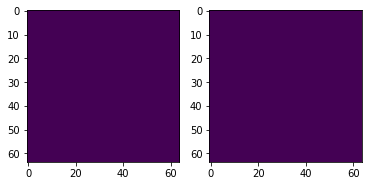

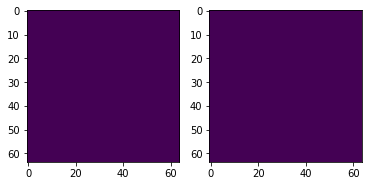

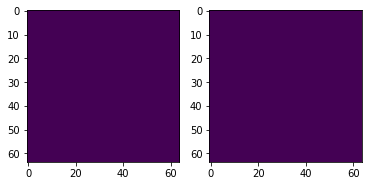

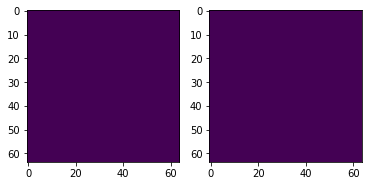

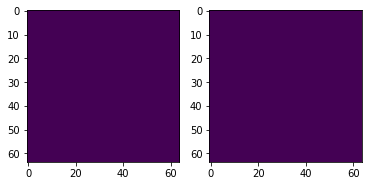

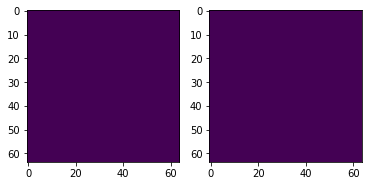

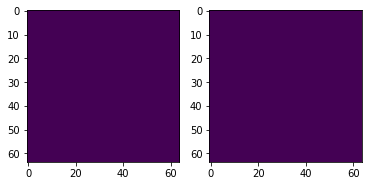

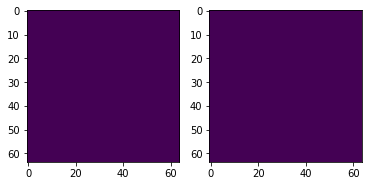

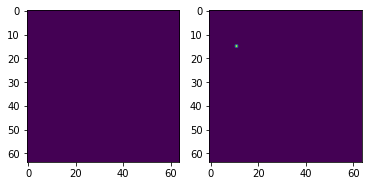

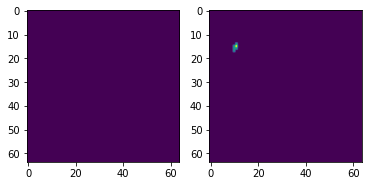

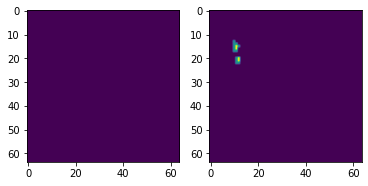

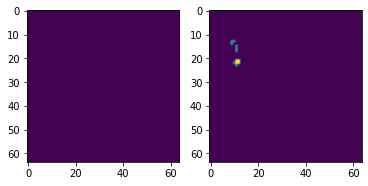

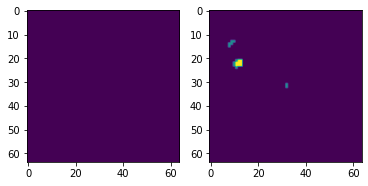

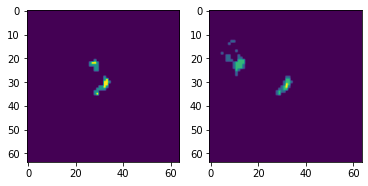

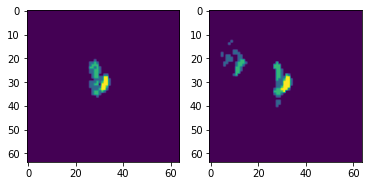

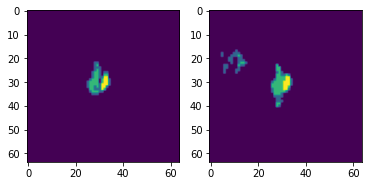

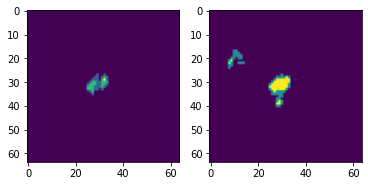

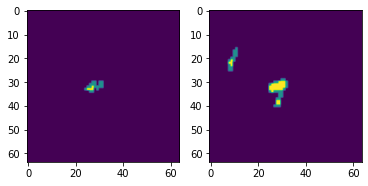

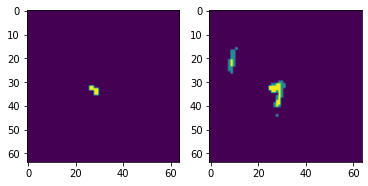

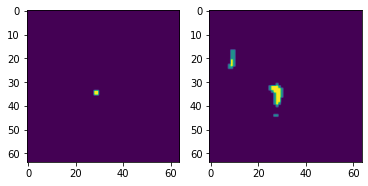

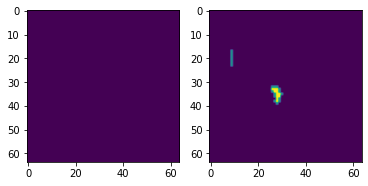

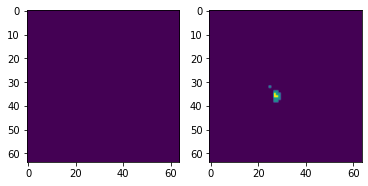

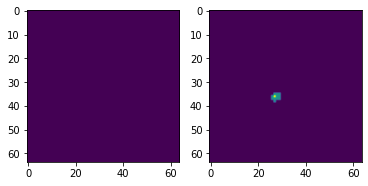

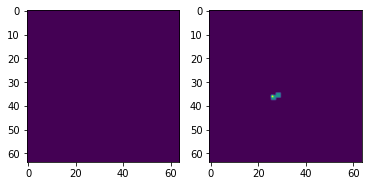

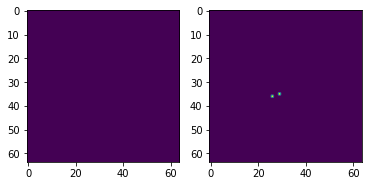

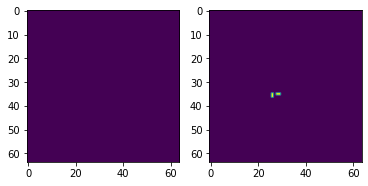

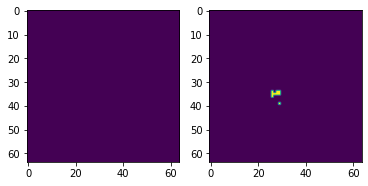

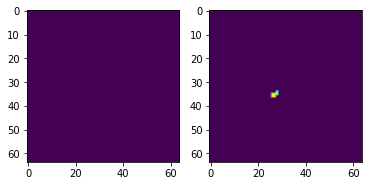

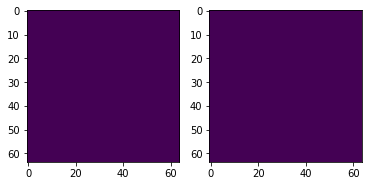

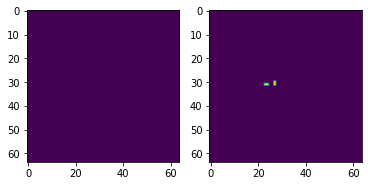

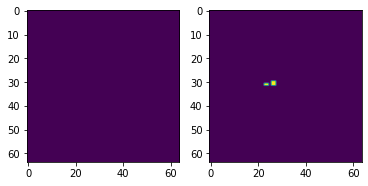

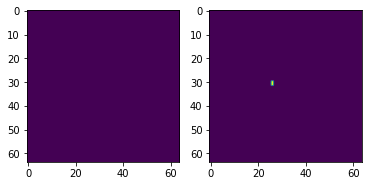

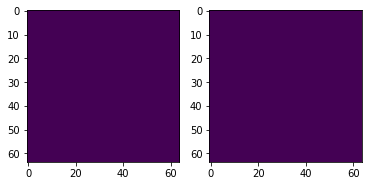

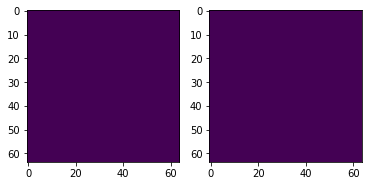

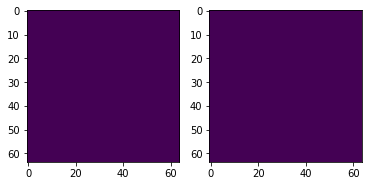

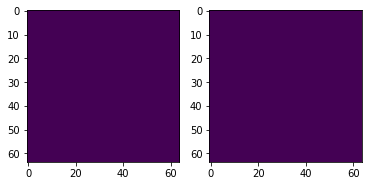

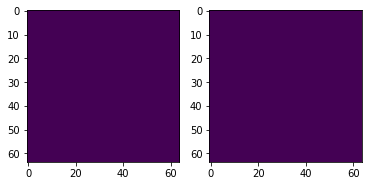

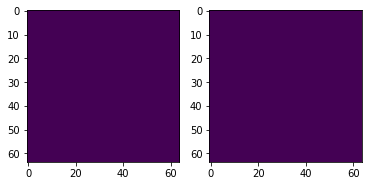

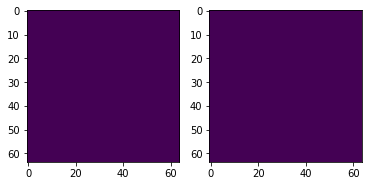

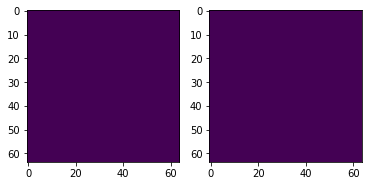

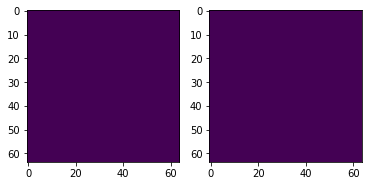

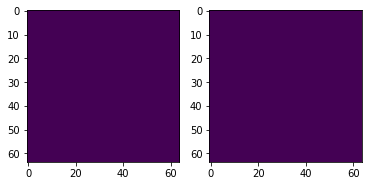

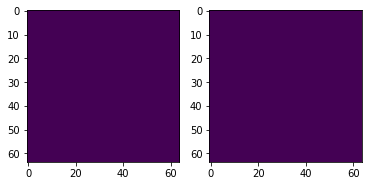

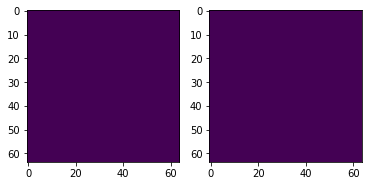

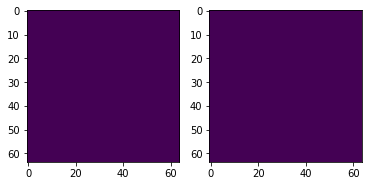

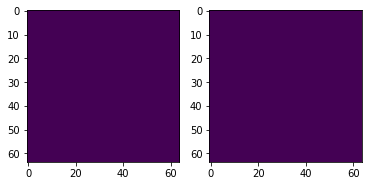

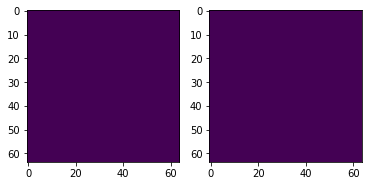

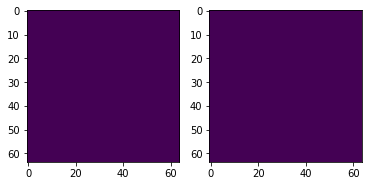

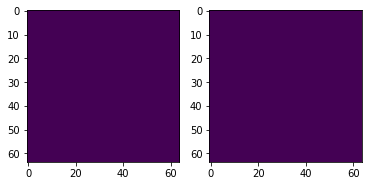

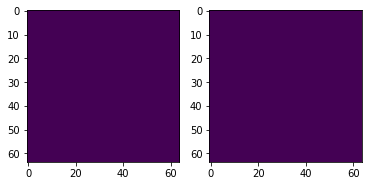

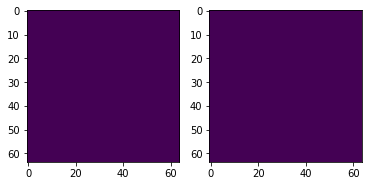

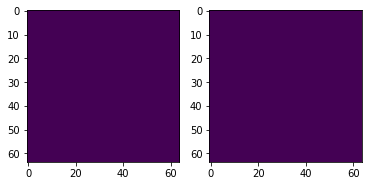

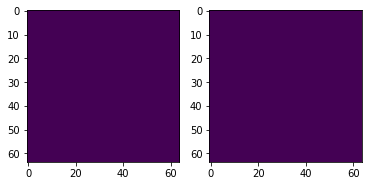

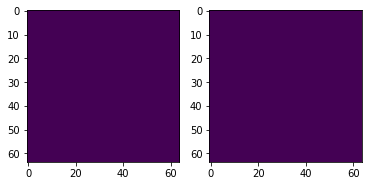

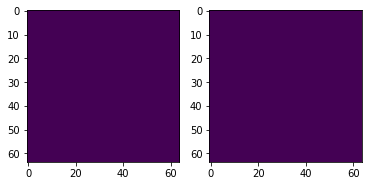

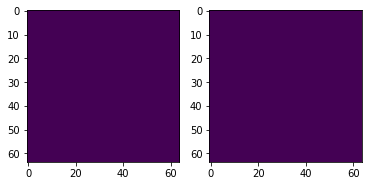

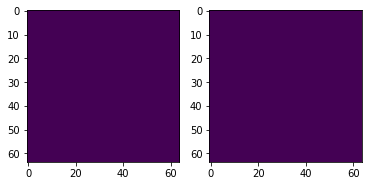

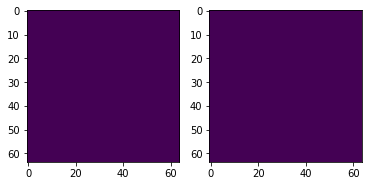

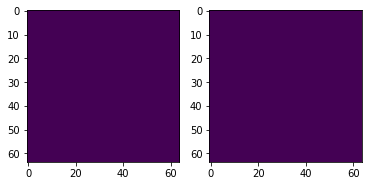

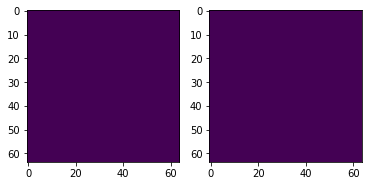

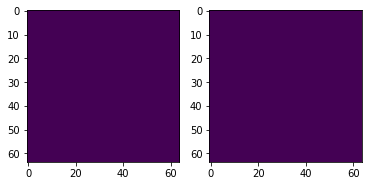

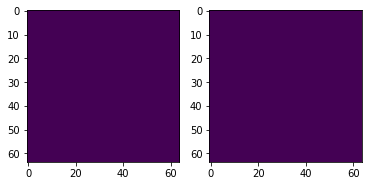

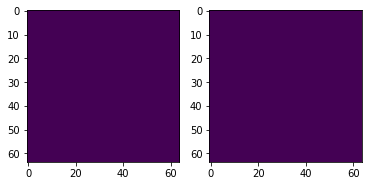

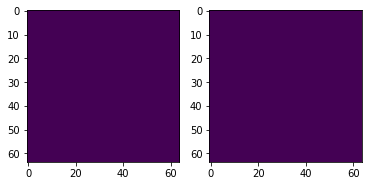

5
218
147
208
0
189
196
33
127
106
143
142
119
179
134
150
136
225
156
226
84
76
70
216
79
163
43
26
39
14
78
22
139
103
118
128
201
183
15
121
192
219
129
133
148
91
21
104
221
6
233
162
58
215
160
116
44
185
49
8
3
124
191
112
207
80
182
93
42
72
52
138
122
1
177
56
55
66
16
31
167
164
210
67
175
200
68
23
114
197
217
113
71
105
178
40
146
111
19
140
176
214
46
186
88
9
123
30
7
203
131
82
100
223
190
50
171
230
75
102
18
11
149
81
37
94
180
165
229
12
184
87
172
110
145
169
25
47
92
41
60
90
151
155
212
69
141
188
194
4
227
125
62
109
144
59
211
220
206
168
13
198
51
95
97
24
117
98
28
120
199
204
222
193
130
89
38
20
54
174
73
154
64
157
10
48
74
232
57
63
153
126
17
195
77
45
61
65
158
83
213
107
35
161
135
108
231
29
205
152
159
202
101
85
32
27
170
166
86
99
53
173
137
36
96
209
2
34
187
224
115
181
228
132
11
12
27
14
16
37
41
5
48
3
38
25
4
49
43
46
17
7
20
39
26
24
29
1
8
36
34
13
0
42
31
50
6
18
32
10
33
28
21
15
30
19
45
47
9
35
2
23
44
40
22
45
47
11
22
14
42
36
28
2
9
13


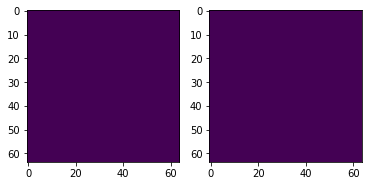

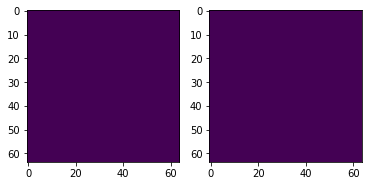

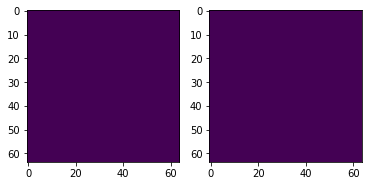

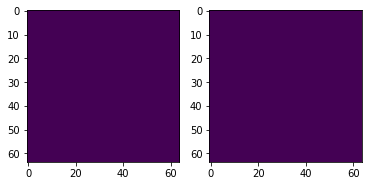

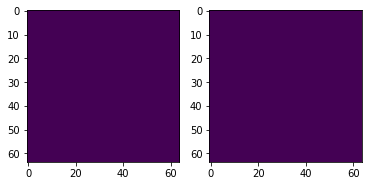

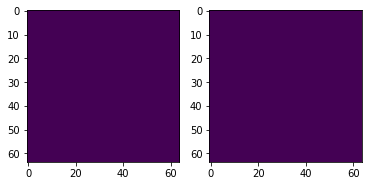

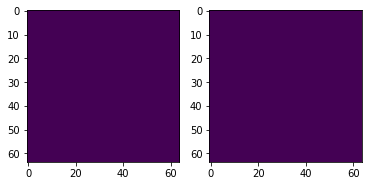

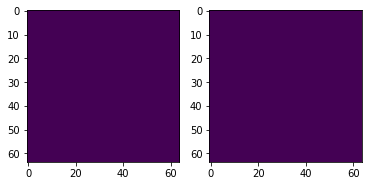

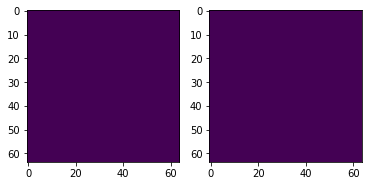

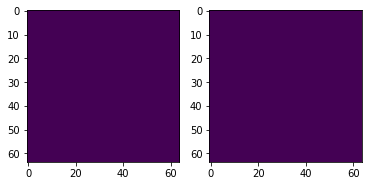

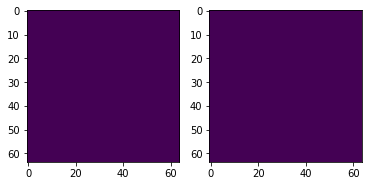

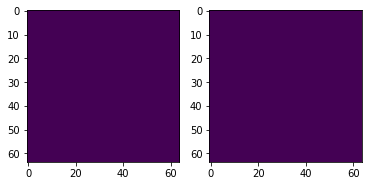

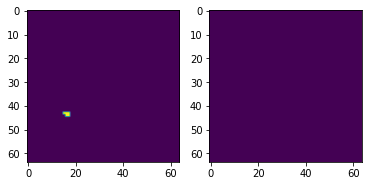

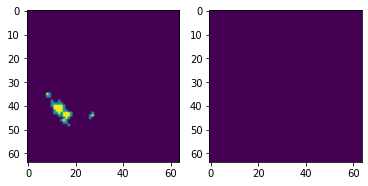

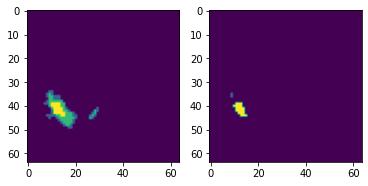

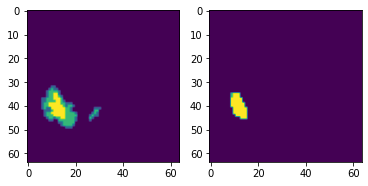

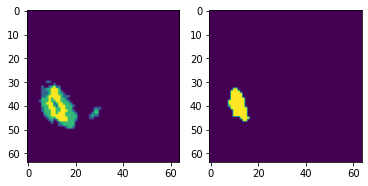

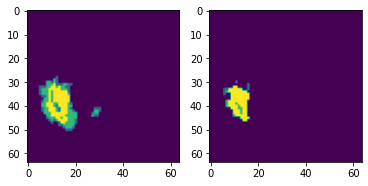

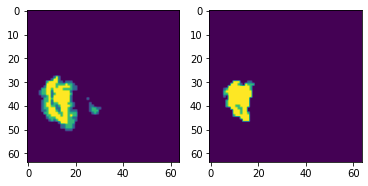

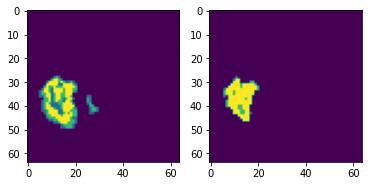

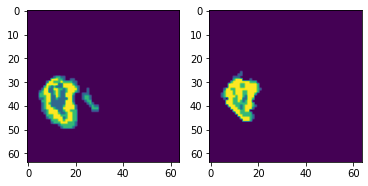

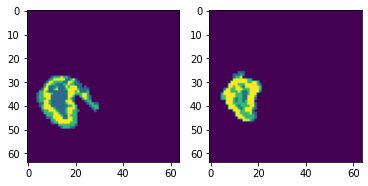

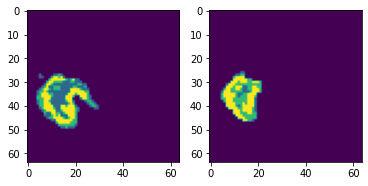

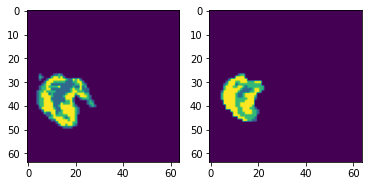

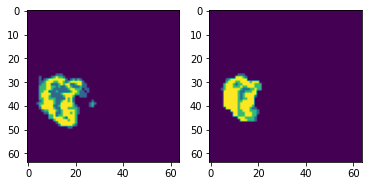

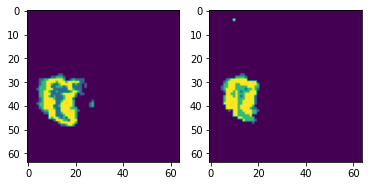

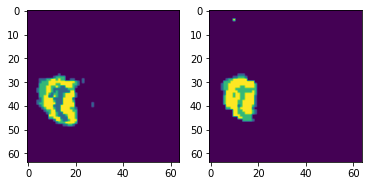

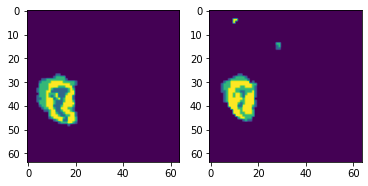

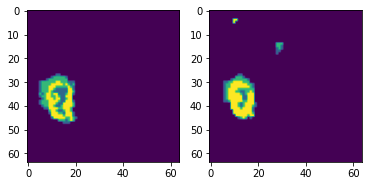

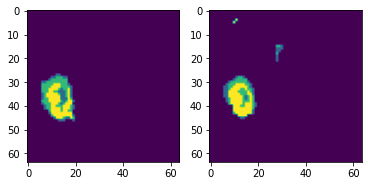

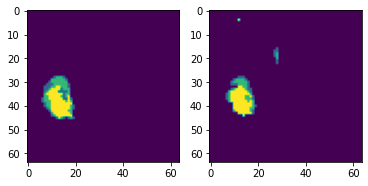

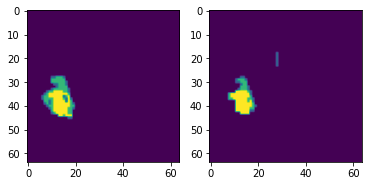

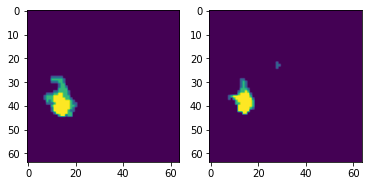

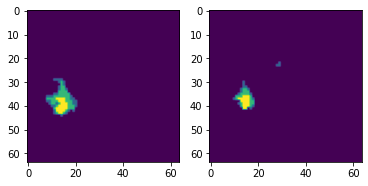

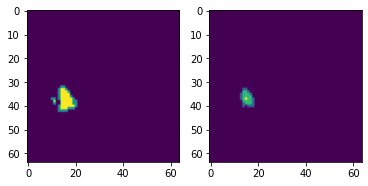

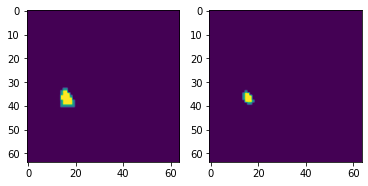

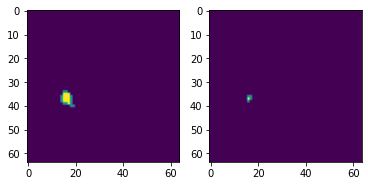

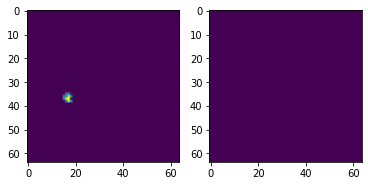

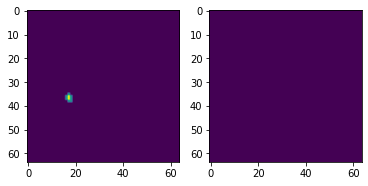

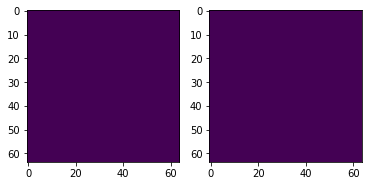

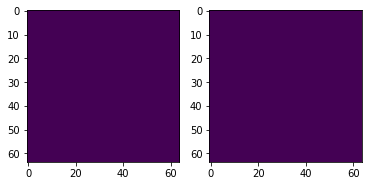

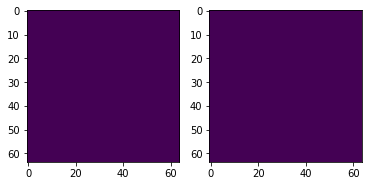

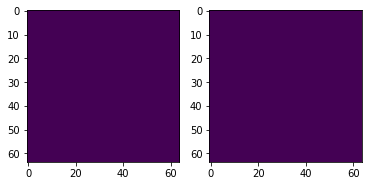

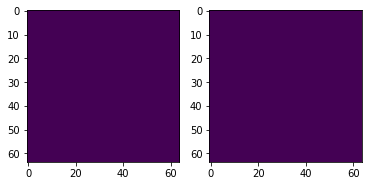

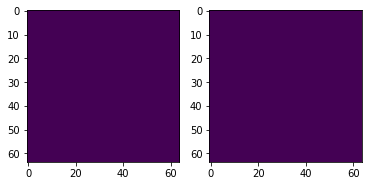

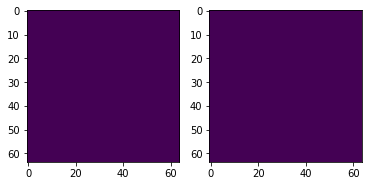

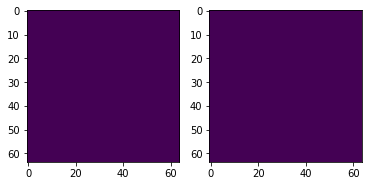

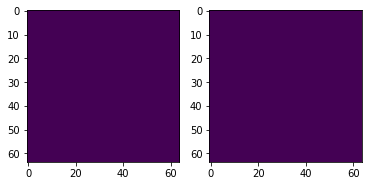

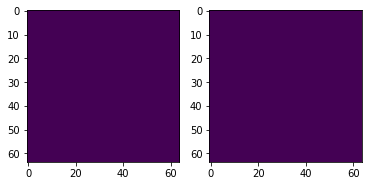

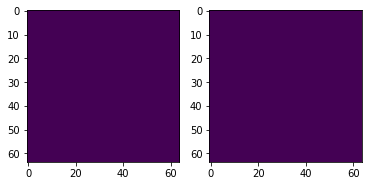

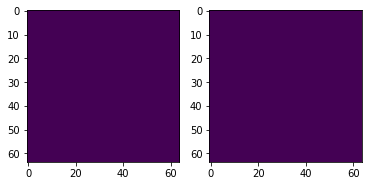

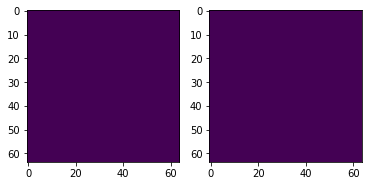

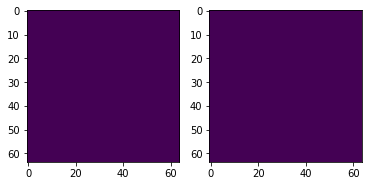

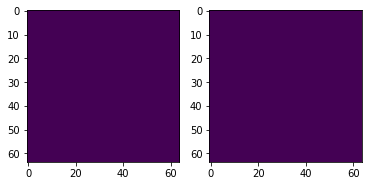

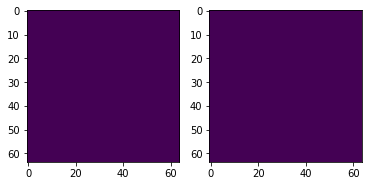

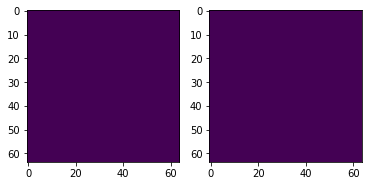

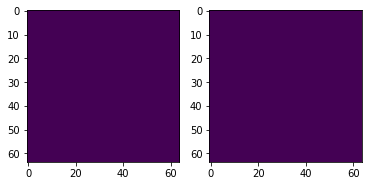

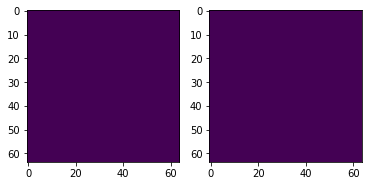

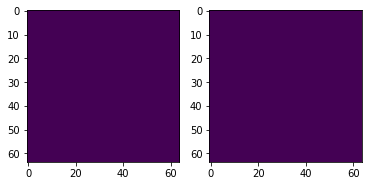

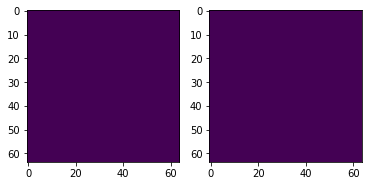

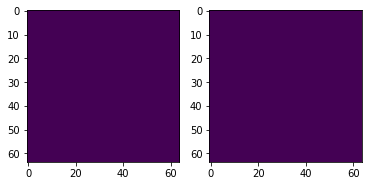

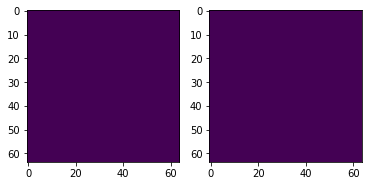

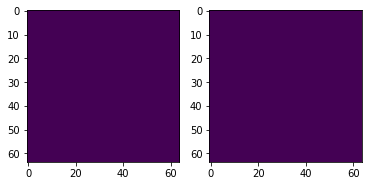

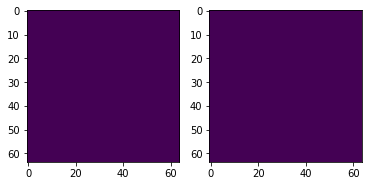

160
213
92
186
184
100
165
27
196
5
210
49
162
0
183
102
42
150
32
227
33
168
140
180
30
63
200
224
172
138
181
29
188
233
10
93
64
109
45
137
179
35
15
203
206
53
128
77
189
89
37
219
204
121
66
129
116
76
41
221
175
153
58
228
14
134
61
55
207
154
201
110
199
114
218
163
158
209
170
126
166
91
95
104
122
50
69
229
225
133
97
73
176
47
71
65
40
52
178
105
164
185
149
1
211
9
161
59
39
24
217
214
208
67
232
148
99
182
136
157
16
159
74
192
43
17
28
187
3
125
79
85
84
57
6
103
124
215
18
98
7
151
155
75
38
118
4
120
177
11
127
131
96
70
56
113
220
106
145
173
26
230
90
141
144
2
34
191
231
31
193
111
123
226
60
83
169
25
101
194
143
86
48
46
80
21
23
119
117
62
87
222
223
198
88
132
190
174
152
139
156
115
78
72
205
13
212
112
142
216
81
135
147
171
146
12
197
130
107
51
22
19
20
54
202
36
108
94
195
167
8
44
68
82
42
27
23
40
5
39
10
3
46
48
32
12
18
7
47
19
29
43
38
25
17
26
1
24
15
8
45
14
16
35
34
33
20
50
6
22
37
4
49
31
44
41
36
0
2
11
9
21
28
30
13
2
29
22
13
39
45
43
35
44
47
17

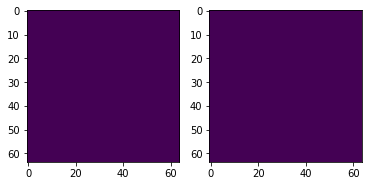

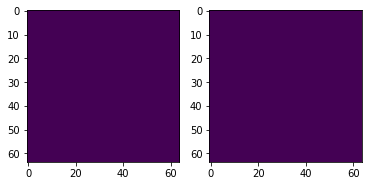

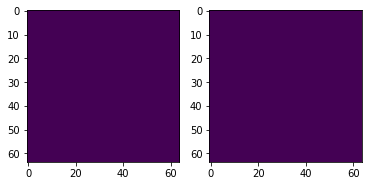

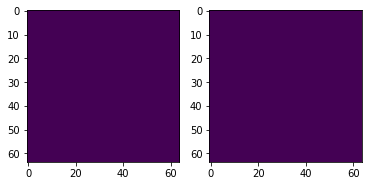

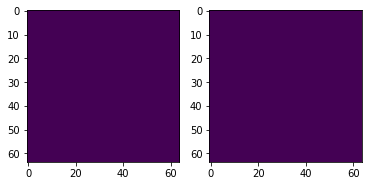

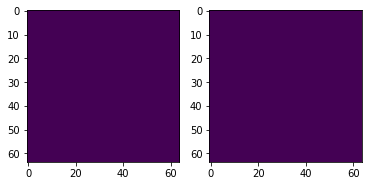

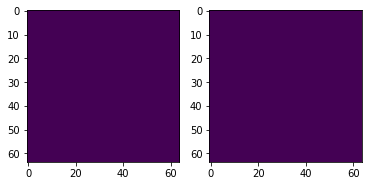

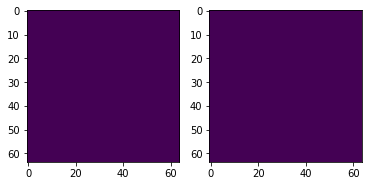

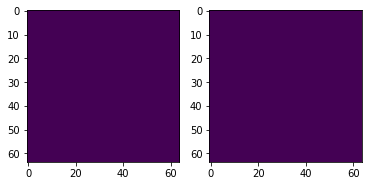

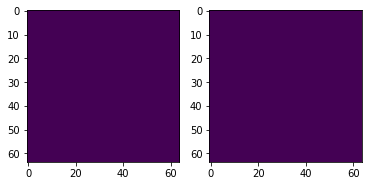

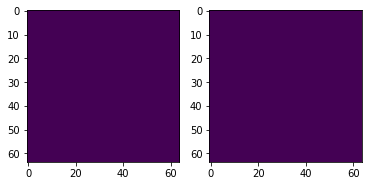

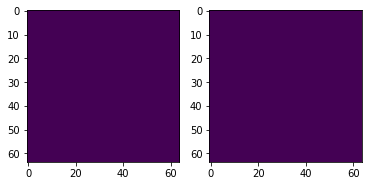

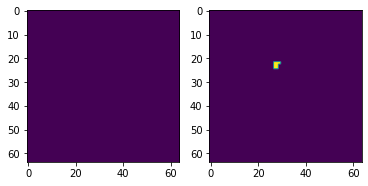

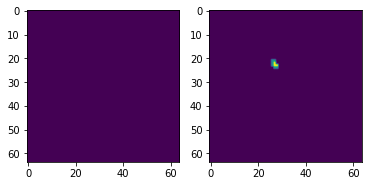

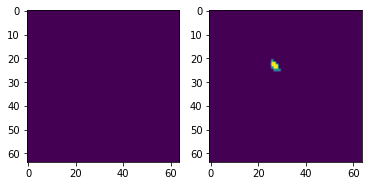

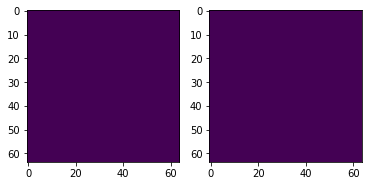

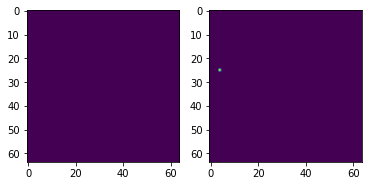

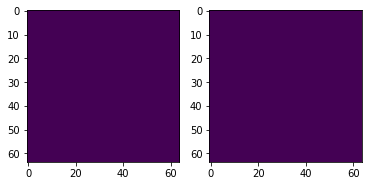

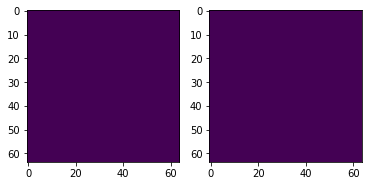

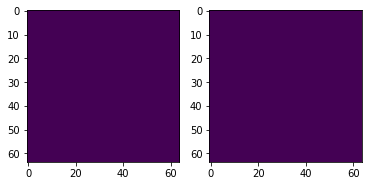

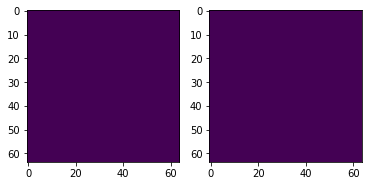

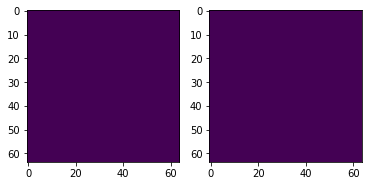

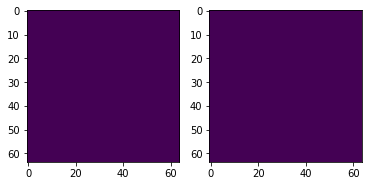

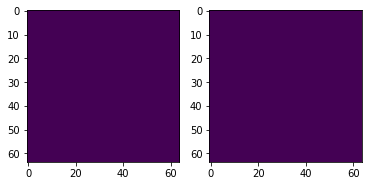

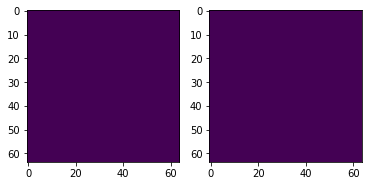

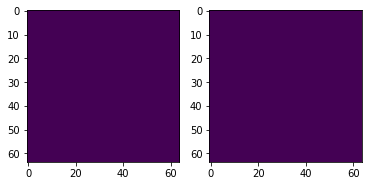

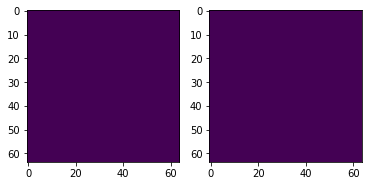

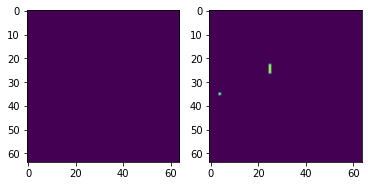

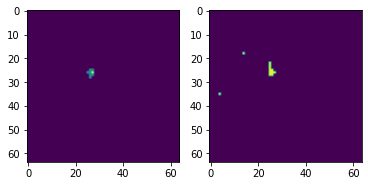

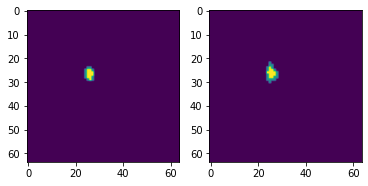

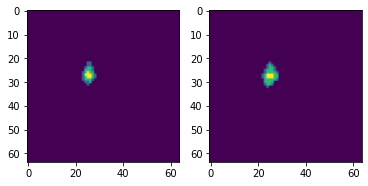

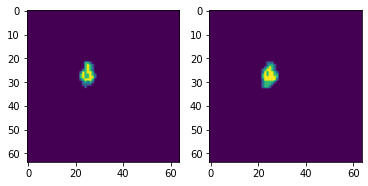

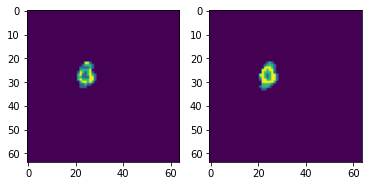

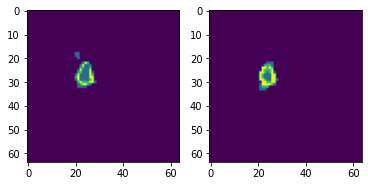

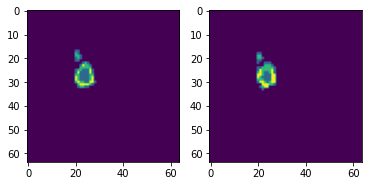

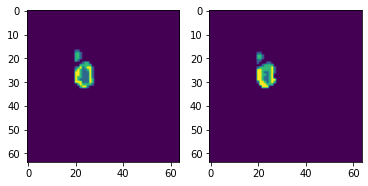

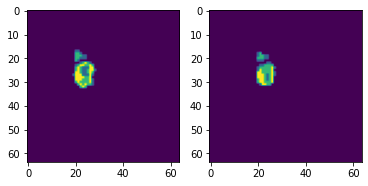

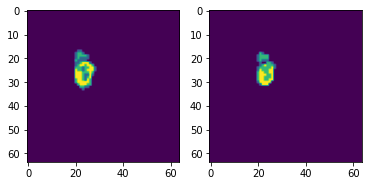

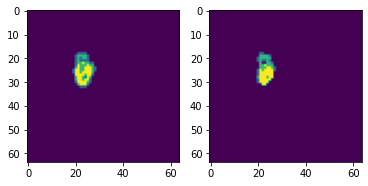

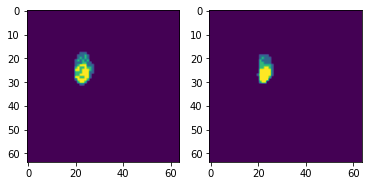

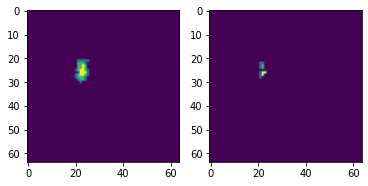

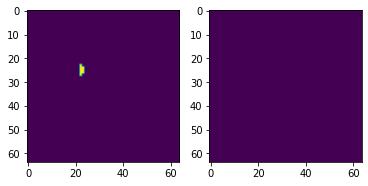

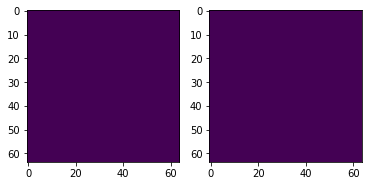

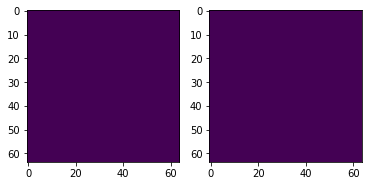

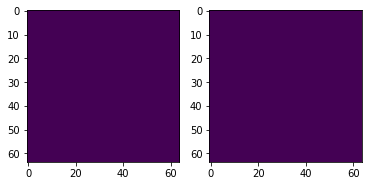

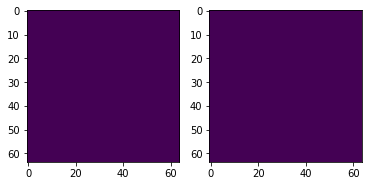

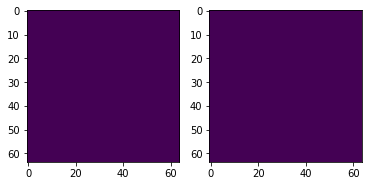

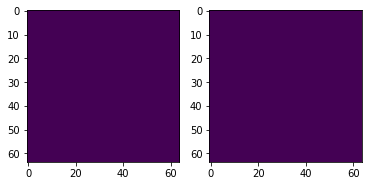

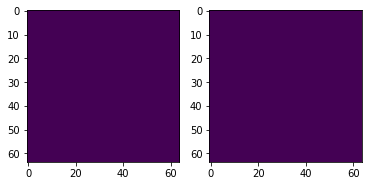

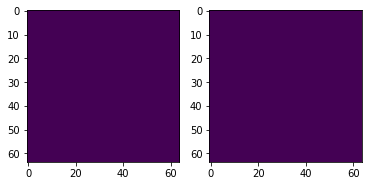

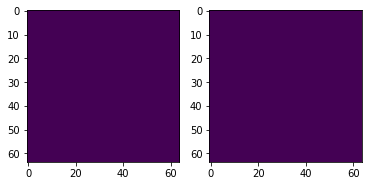

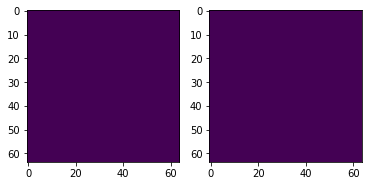

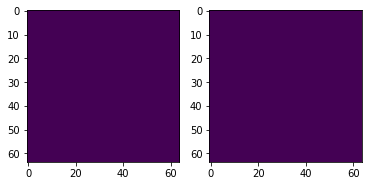

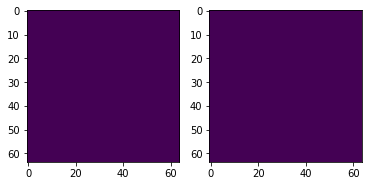

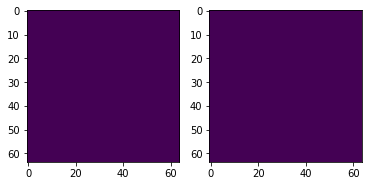

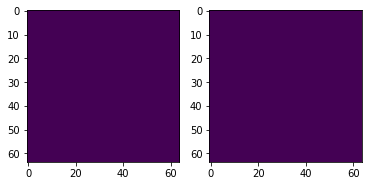

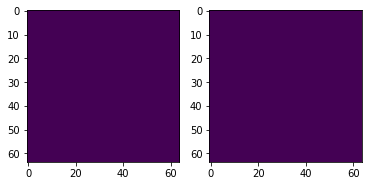

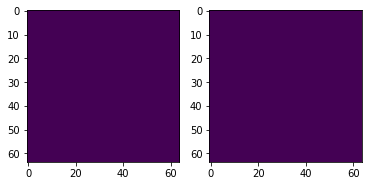

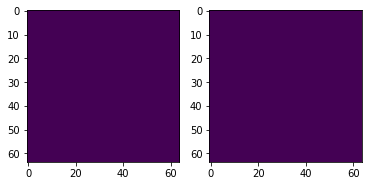

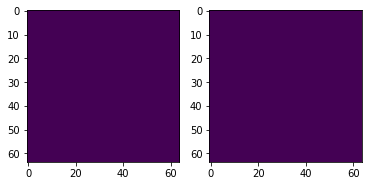

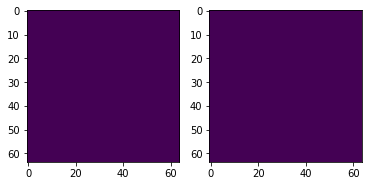

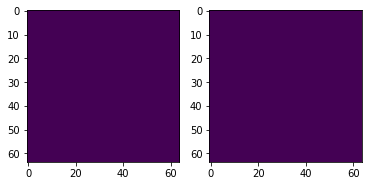

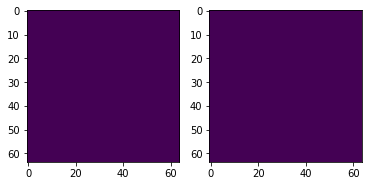

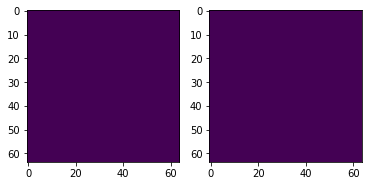

3
101
194
215
6
46
93
141
25
147
15
125
127
1
67
65
10
36
193
63
22
191
227
220
48
44
102
198
62
163
155
33
52
159
60
160
201
83
9
211
189
106
31
117
72
23
202
35
129
99
148
131
185
94
149
89
75
123
98
177
92
134
197
55
210
187
122
174
27
88
225
78
214
233
108
84
17
157
85
130
59
18
203
45
69
114
5
57
146
107
222
171
79
112
86
26
165
105
178
226
111
137
139
58
8
29
205
16
144
121
74
14
231
7
145
213
190
96
12
20
156
4
183
229
38
68
181
41
77
223
24
169
49
161
126
184
180
196
28
199
175
42
39
158
11
70
80
115
138
204
173
216
219
116
192
212
91
221
81
170
128
37
166
200
164
73
13
135
120
140
47
228
186
118
133
100
168
151
154
54
56
87
110
188
232
30
206
195
34
95
217
218
32
182
50
176
19
104
152
53
162
0
208
113
64
132
172
21
40
2
209
109
76
71
61
167
43
224
142
179
103
230
143
82
90
119
153
66
97
51
207
124
150
136
32
48
40
42
19
10
15
45
50
34
31
20
37
1
22
17
6
23
29
14
0
2
44
4
9
8
35
18
25
11
27
16
43
24
49
46
36
26
33
5
38
7
21
47
39
3
41
12
28
30
13
38
25
46
11
28
31
26
35
0
40
18

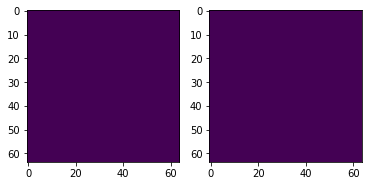

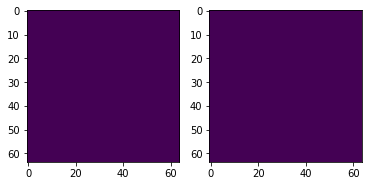

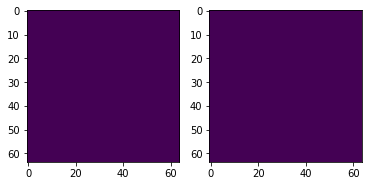

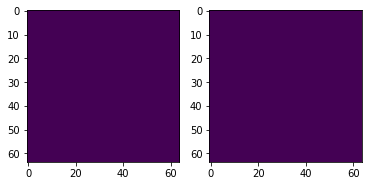

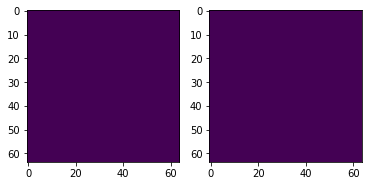

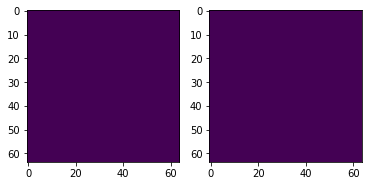

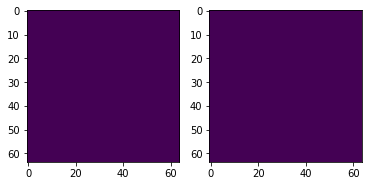

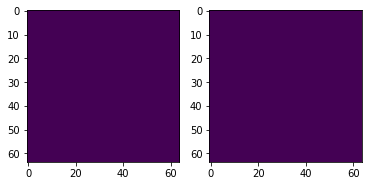

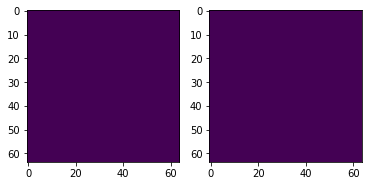

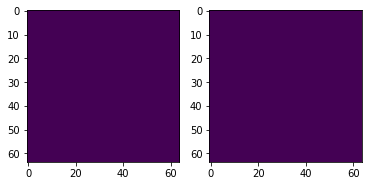

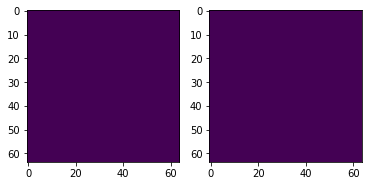

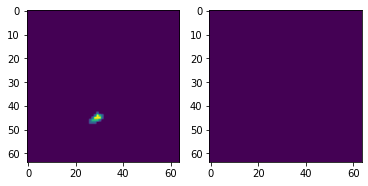

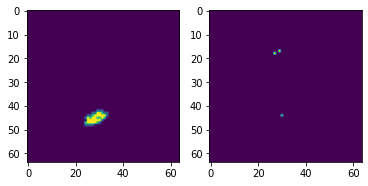

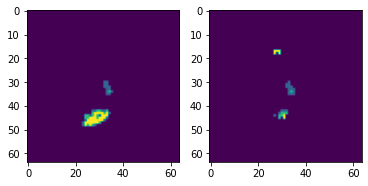

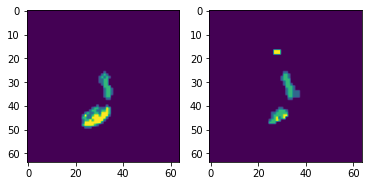

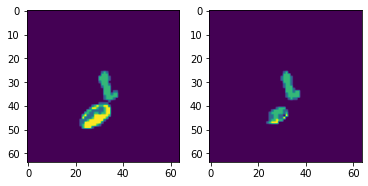

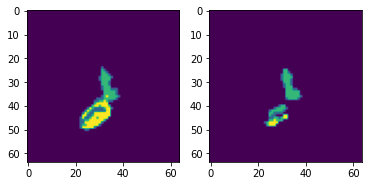

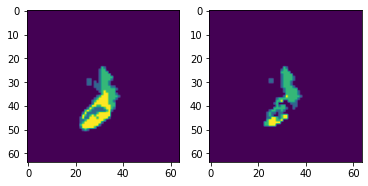

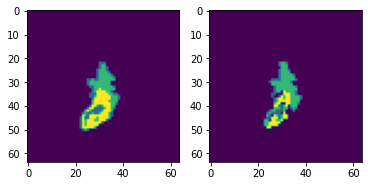

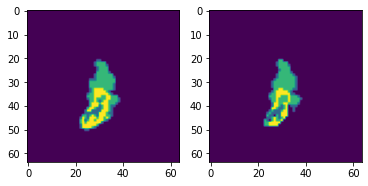

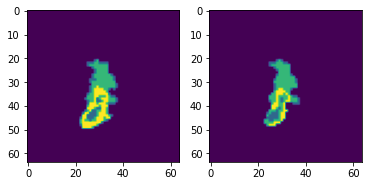

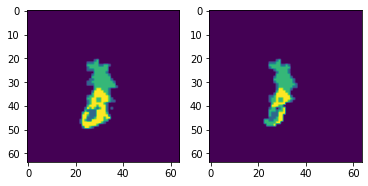

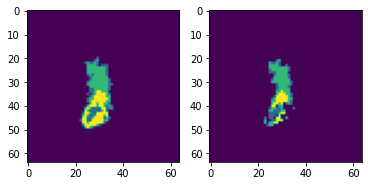

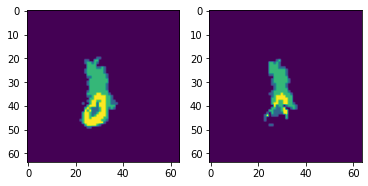

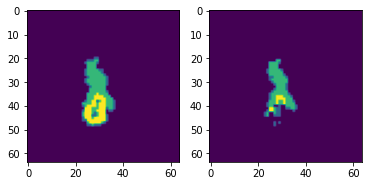

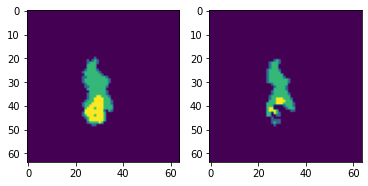

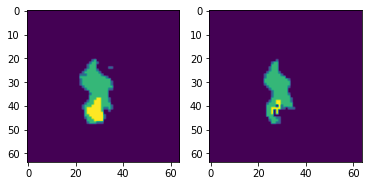

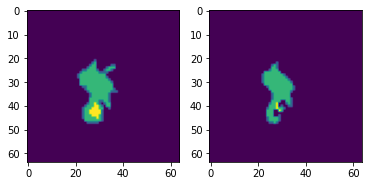

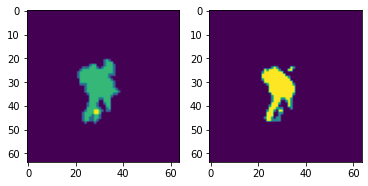

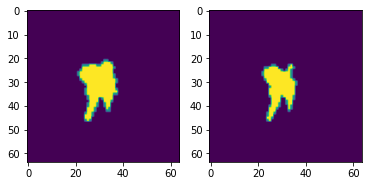

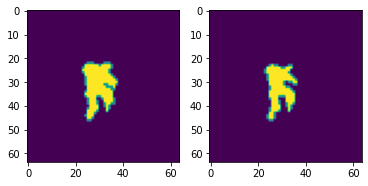

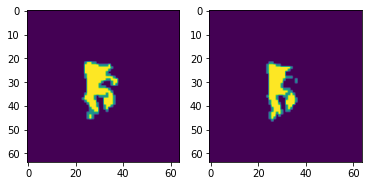

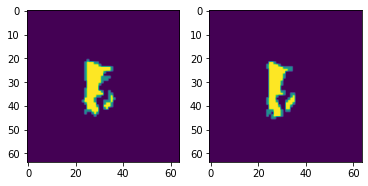

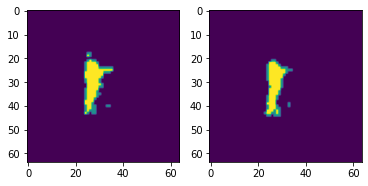

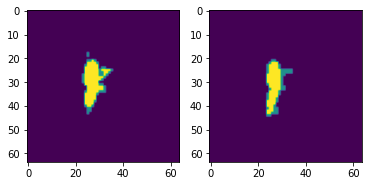

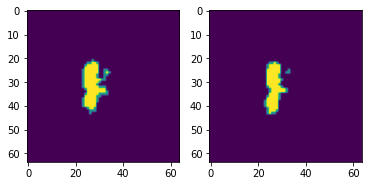

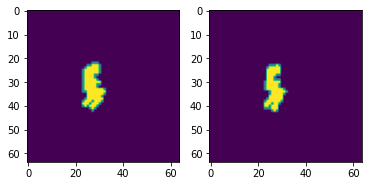

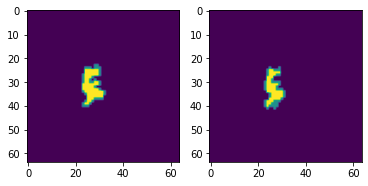

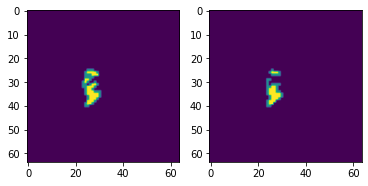

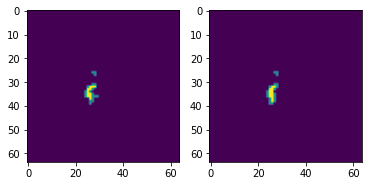

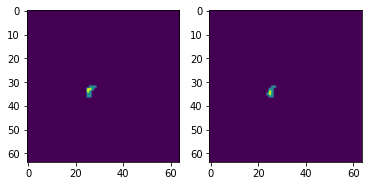

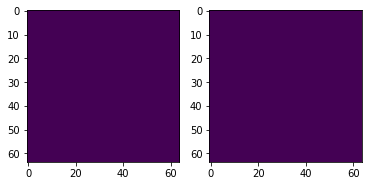

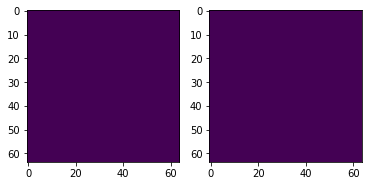

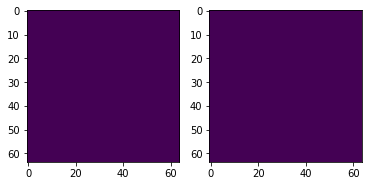

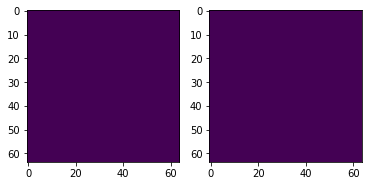

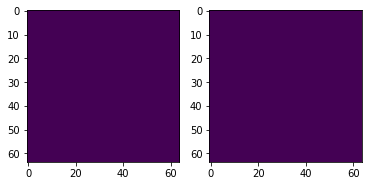

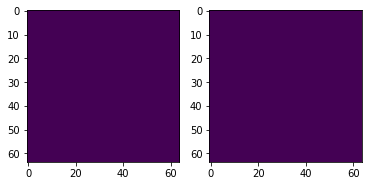

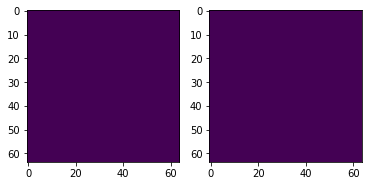

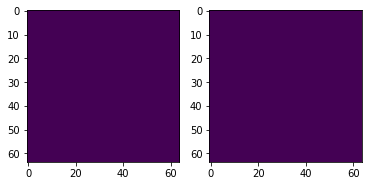

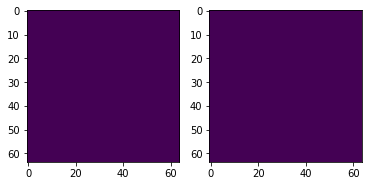

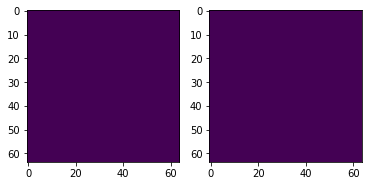

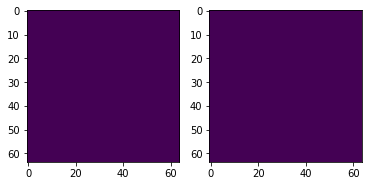

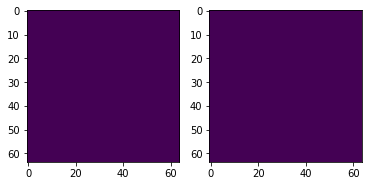

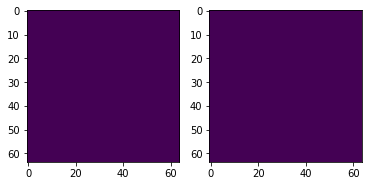

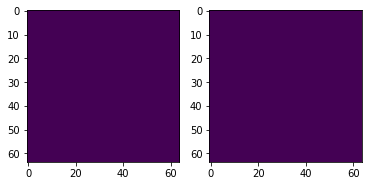

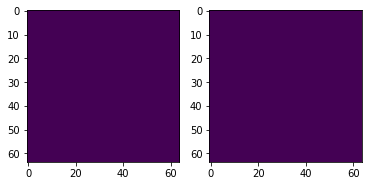

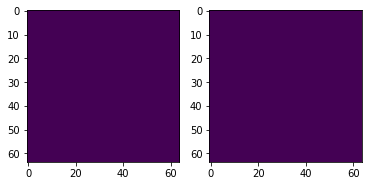

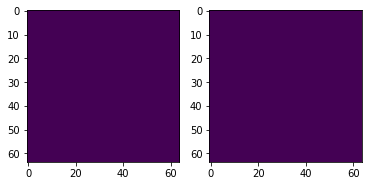

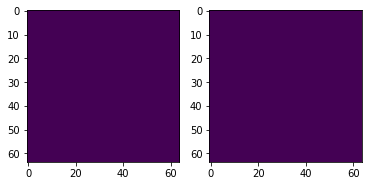

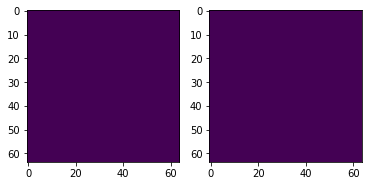

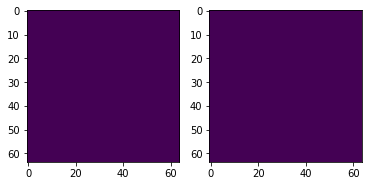

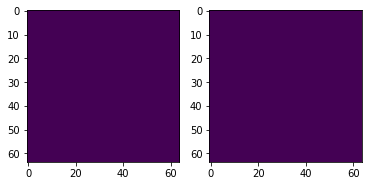

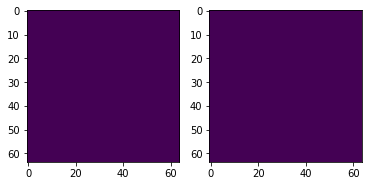

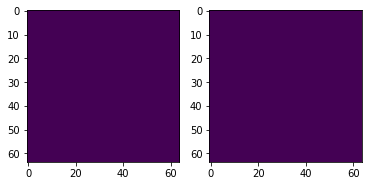

89
19
175
176
153
134
223
26
117
100
209
25
15
113
171
162
74
146
76
115
51
60
18
99
199
128
32
184
103
137
93
85
44
108
219
228
66
231
54
82
119
129
206
172
52
198
183
138
77
102
17
55
75
79
107
72
221
47
187
186
37
156
87
29
232
189
49
160
188
182
122
127
147
218
104
106
145
226
180
140
155
214
192
159
227
42
105
24
125
20
10
67
38
210
27
230
177
6
149
203
73
168
81
98
97
88
1
65
62
213
8
91
142
11
201
178
16
109
118
58
166
110
35
64
120
56
130
13
84
216
23
141
161
164
139
173
3
157
63
111
61
57
34
86
70
116
136
2
28
69
212
220
133
224
90
95
215
94
101
217
190
5
150
45
194
195
174
31
158
197
9
12
46
205
21
7
191
78
169
92
50
170
179
112
33
204
40
4
154
144
233
48
96
124
126
202
71
185
211
121
196
68
83
229
151
143
225
0
208
43
41
22
14
148
59
165
80
163
181
207
193
167
200
36
222
135
123
152
132
131
39
53
30
114
48
49
41
0
16
45
30
47
4
8
33
22
25
38
37
46
42
2
11
31
10
7
28
21
32
13
50
29
18
9
14
39
36
34
19
15
20
1
26
17
6
3
24
5
23
44
35
40
27
12
43
18
33
32
34
46
23
43
11
31
47
1

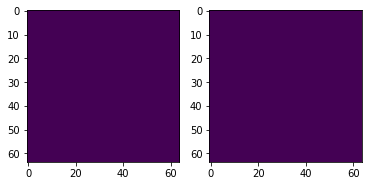

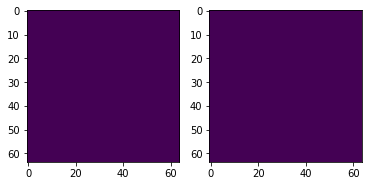

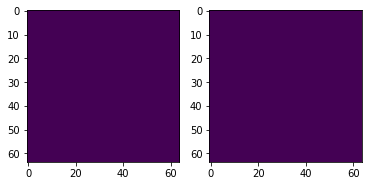

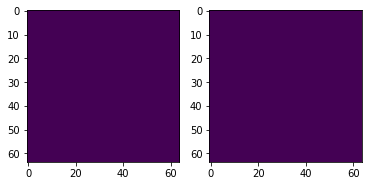

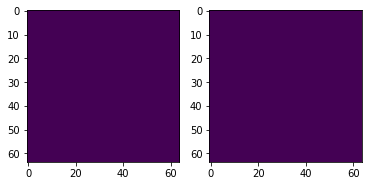

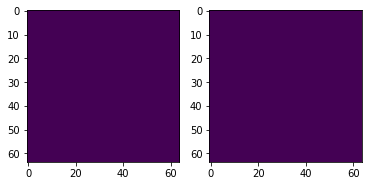

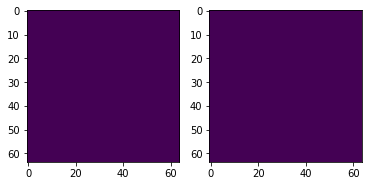

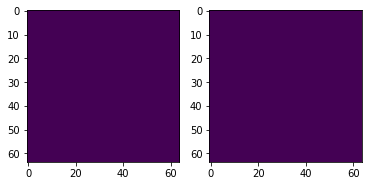

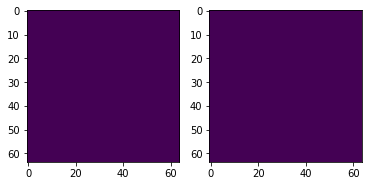

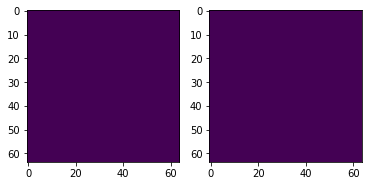

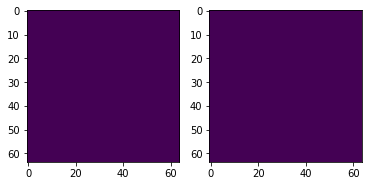

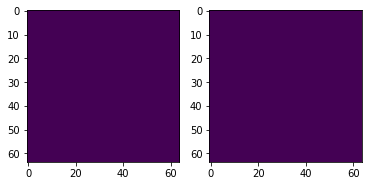

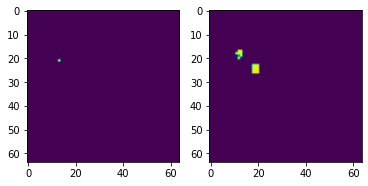

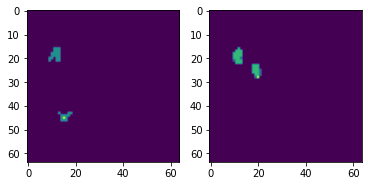

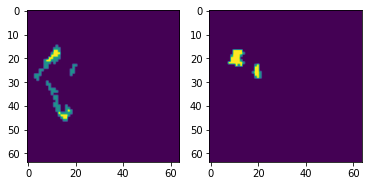

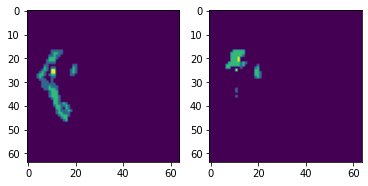

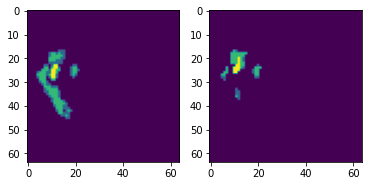

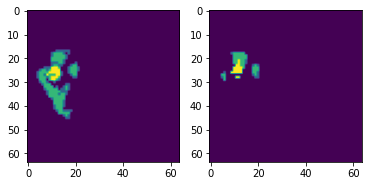

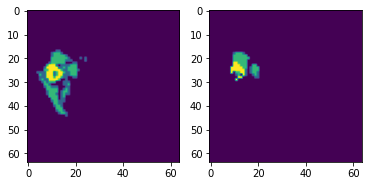

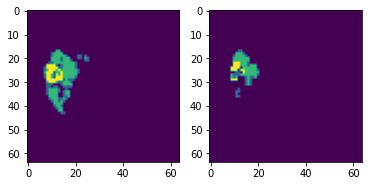

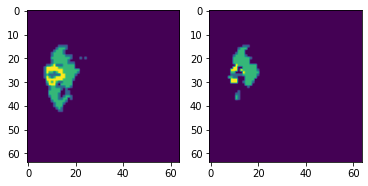

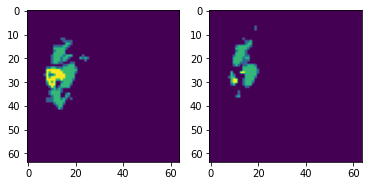

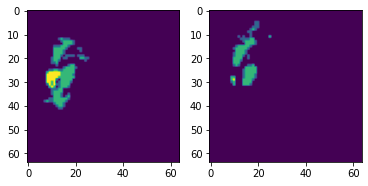

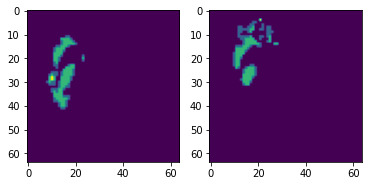

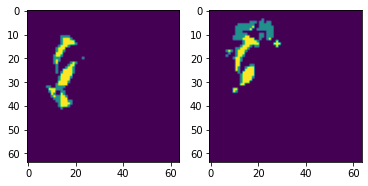

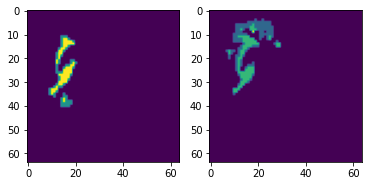

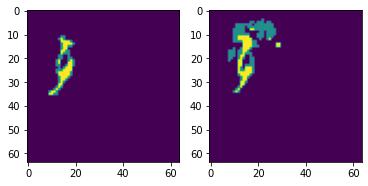

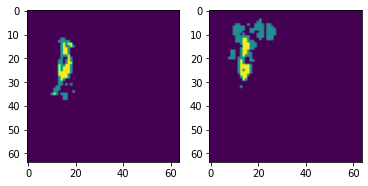

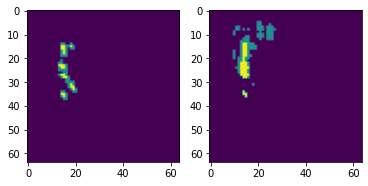

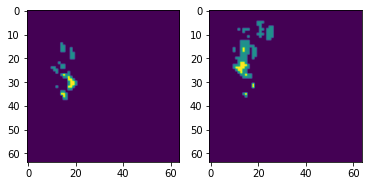

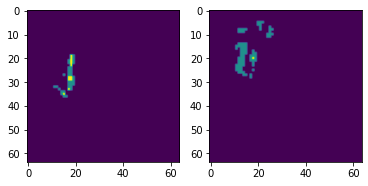

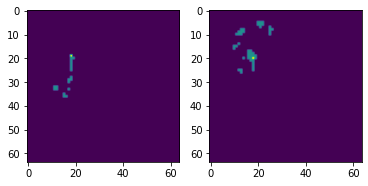

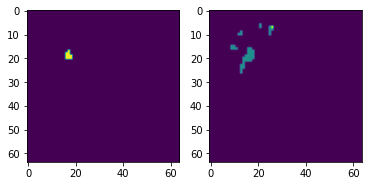

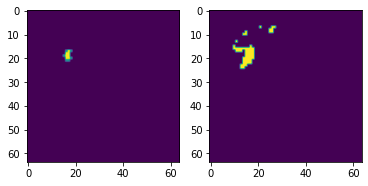

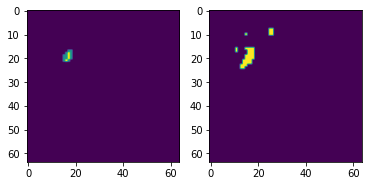

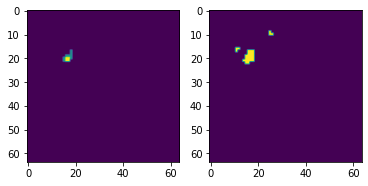

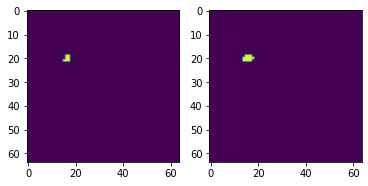

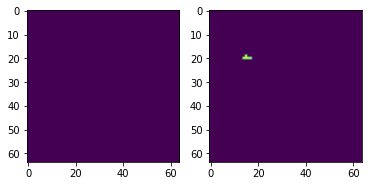

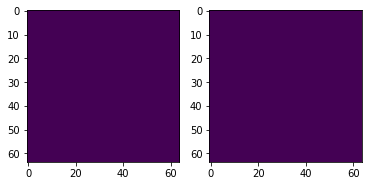

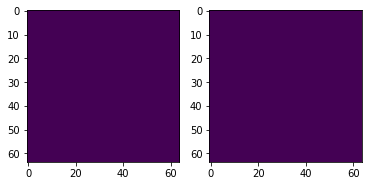

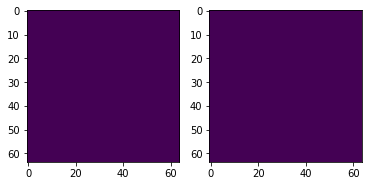

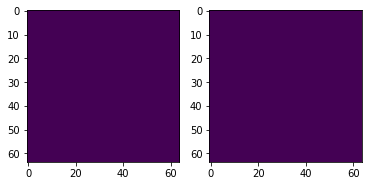

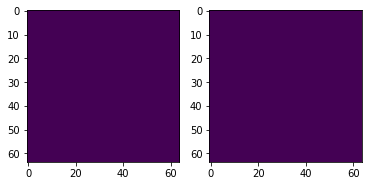

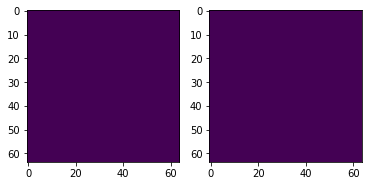

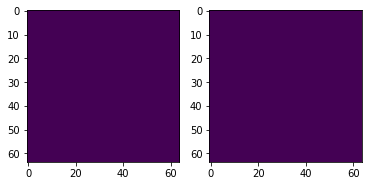

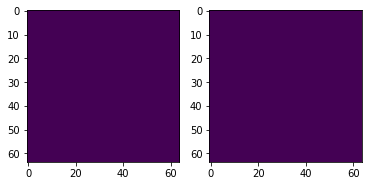

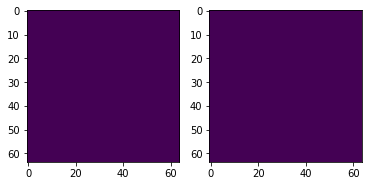

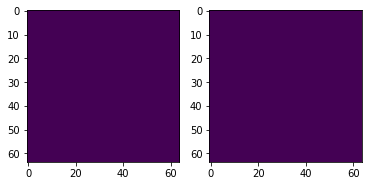

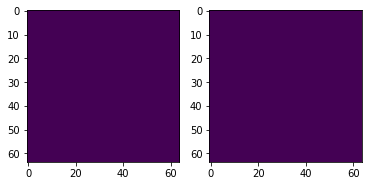

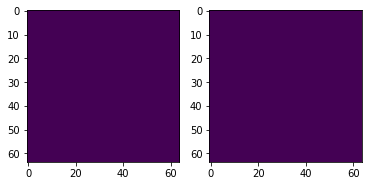

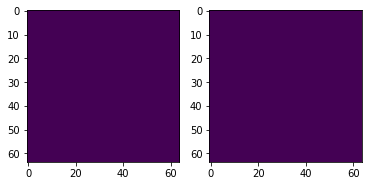

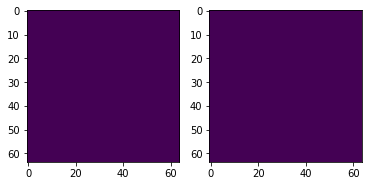

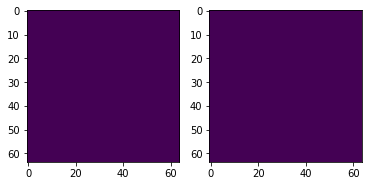

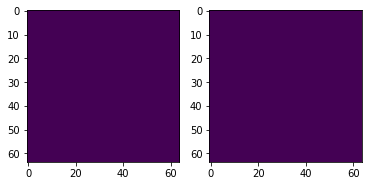

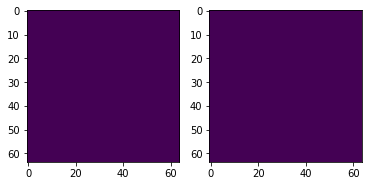

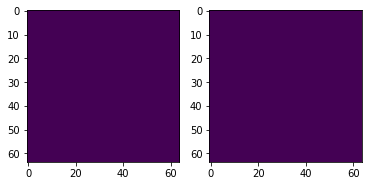

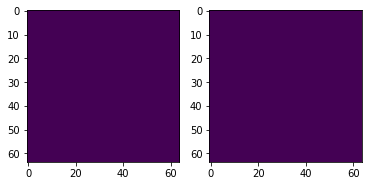

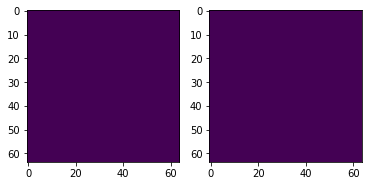

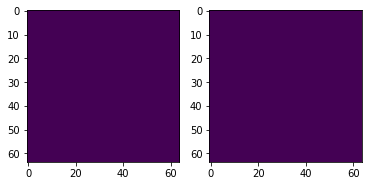

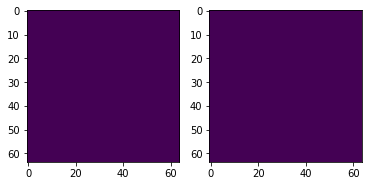

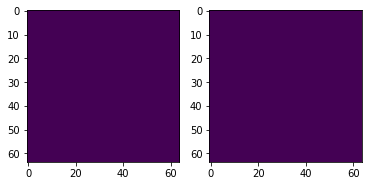

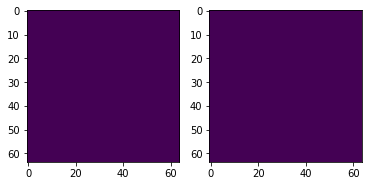

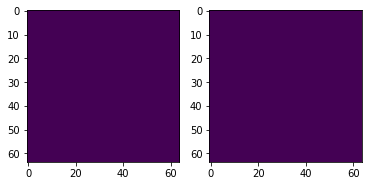

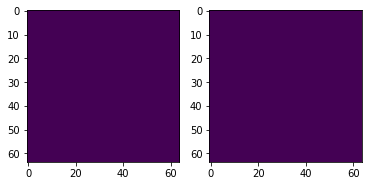

193
74
55
192
4
180
80
92
201
218
26
211
38
19
6
142
2
71
204
199
124
163
53
167
188
154
233
125
39
132
229
7
208
11
113
112
65
203
216
23
213
161
185
10
85
181
70
93
82
88
95
48
84
17
12
58
170
184
42
223
77
110
187
173
119
226
73
162
59
126
68
44
86
176
103
217
149
96
164
22
51
198
105
63
177
118
195
225
106
156
90
15
172
46
111
98
135
60
182
91
109
62
37
138
117
143
78
107
202
178
49
212
61
146
231
35
100
97
29
166
120
189
1
129
214
145
191
36
20
209
18
232
220
50
79
207
89
33
24
183
205
157
197
57
69
153
16
200
9
30
144
87
175
160
215
104
148
171
221
122
83
116
45
94
0
158
41
165
40
54
150
134
114
206
25
43
121
127
151
64
139
28
190
76
81
219
186
228
21
230
3
66
123
8
210
140
75
159
169
196
137
108
115
131
174
222
47
67
14
152
52
155
72
101
179
13
136
168
141
194
133
34
102
27
99
5
32
128
147
224
56
227
130
31
32
9
43
25
20
21
38
28
4
39
1
13
12
3
33
18
42
17
16
10
19
8
50
44
45
5
36
22
15
48
40
23
6
0
11
47
49
29
30
41
14
7
31
35
26
27
46
34
24
2
37
16
38
9
1
31
46
18
13
44
49
48


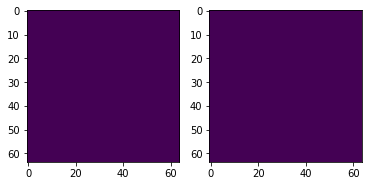

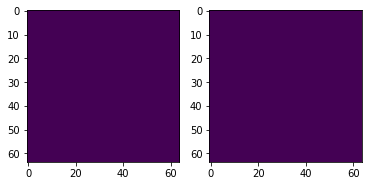

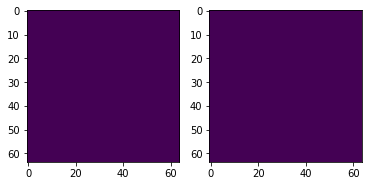

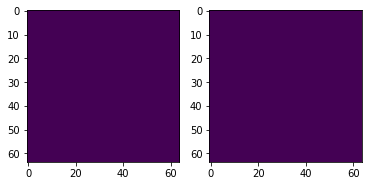

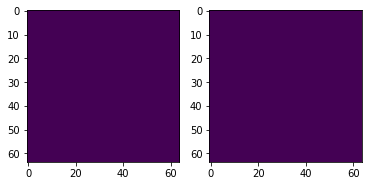

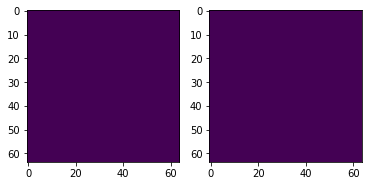

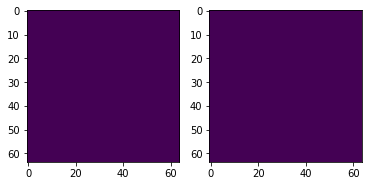

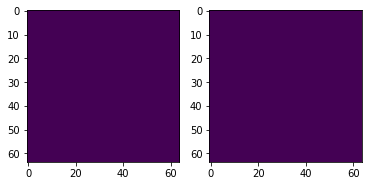

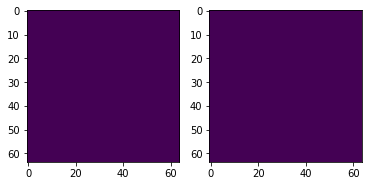

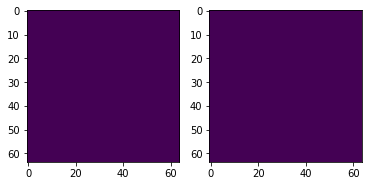

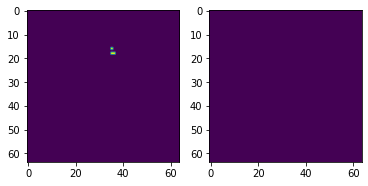

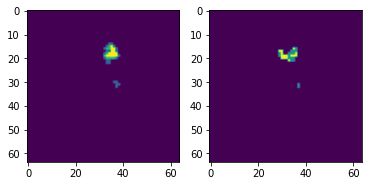

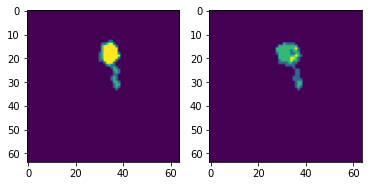

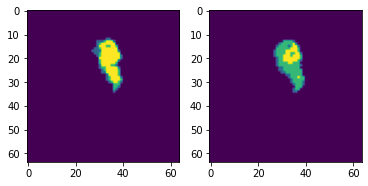

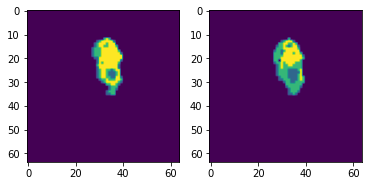

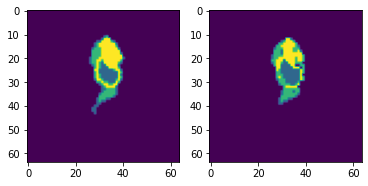

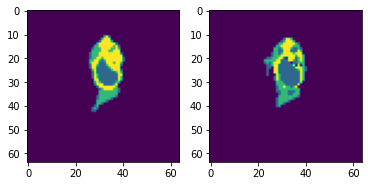

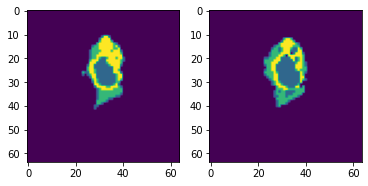

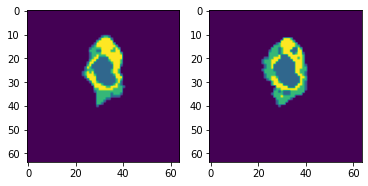

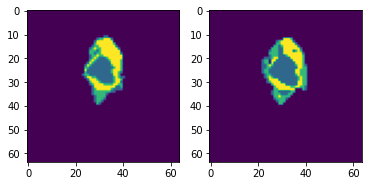

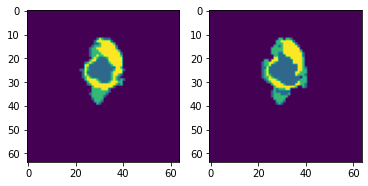

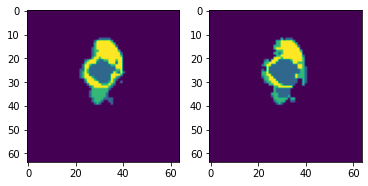

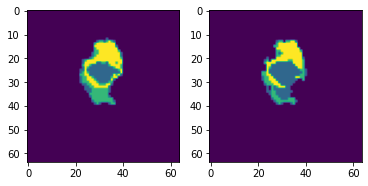

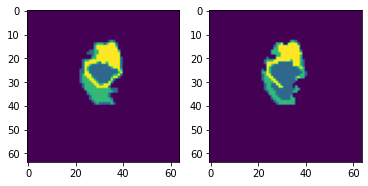

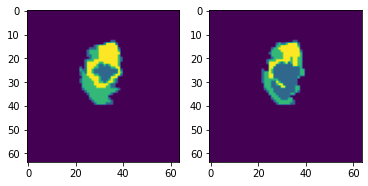

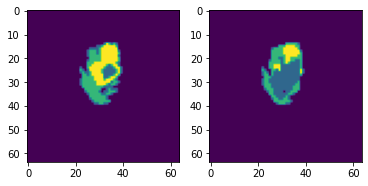

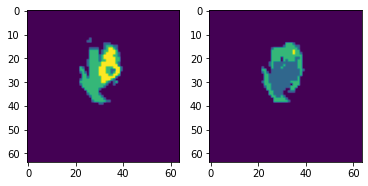

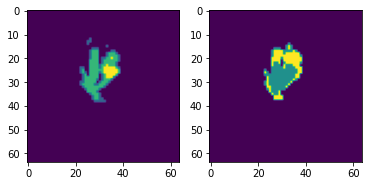

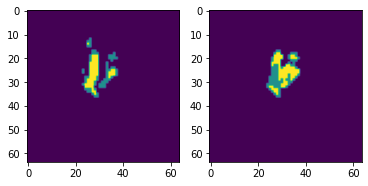

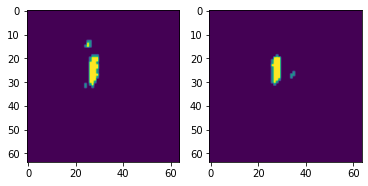

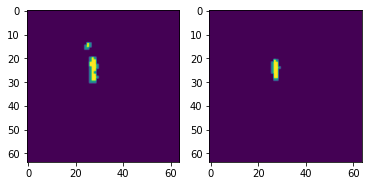

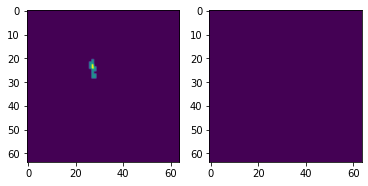

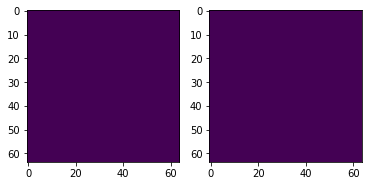

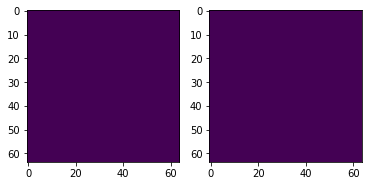

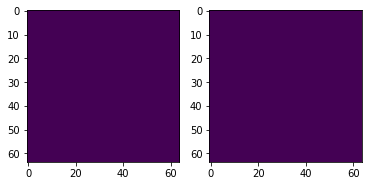

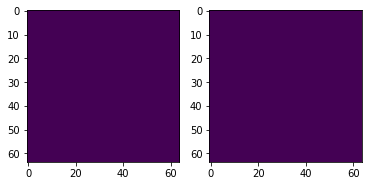

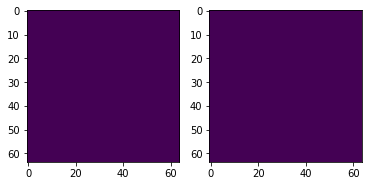

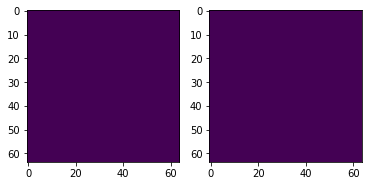

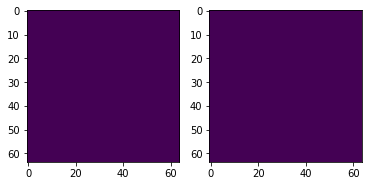

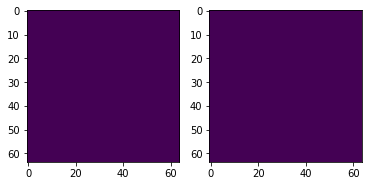

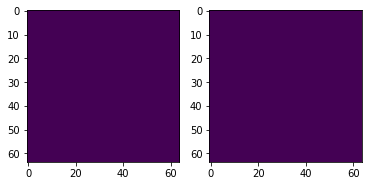

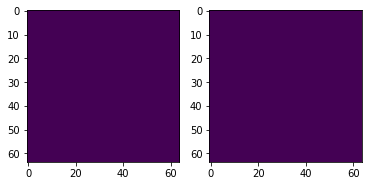

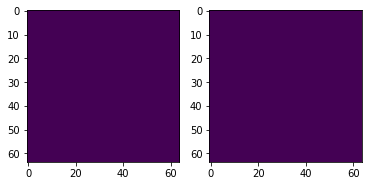

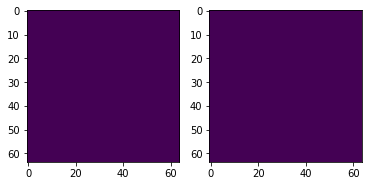

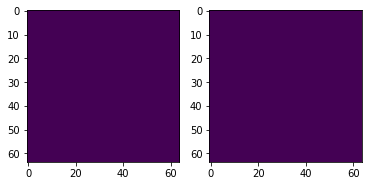

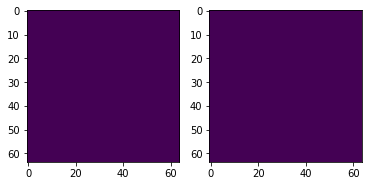

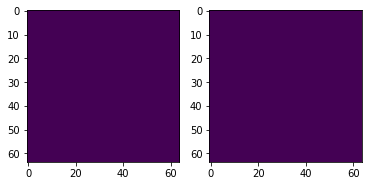

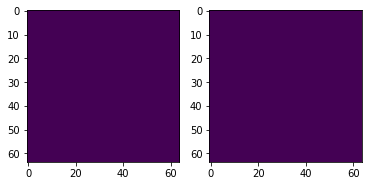

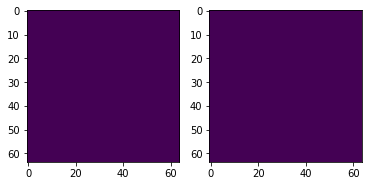

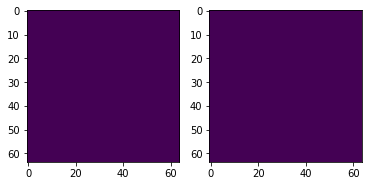

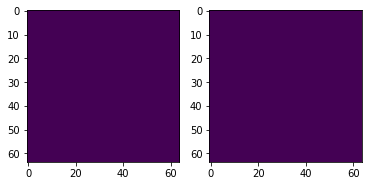

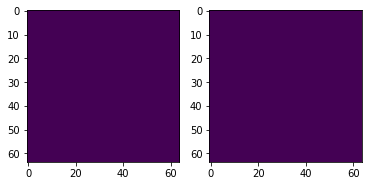

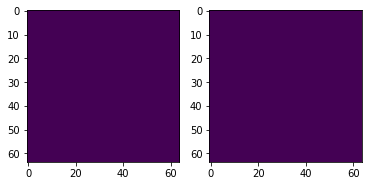

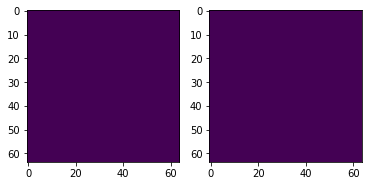

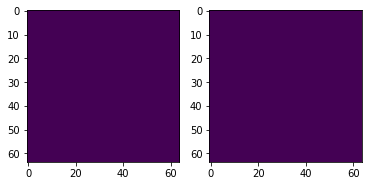

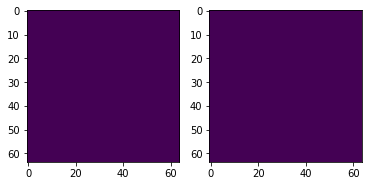

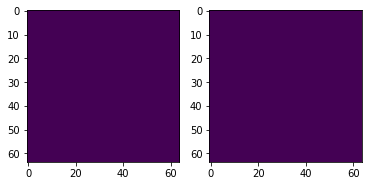

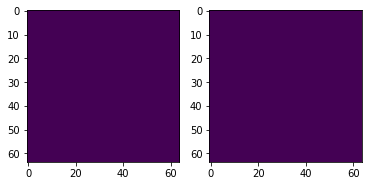

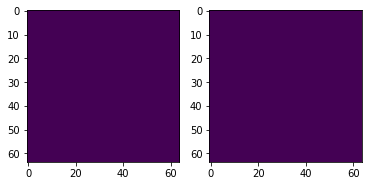

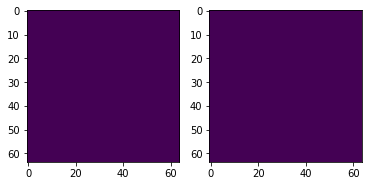

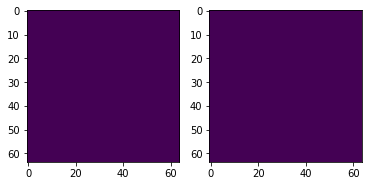

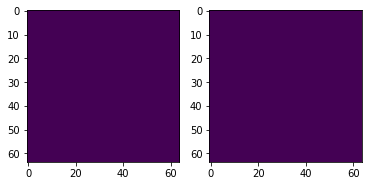

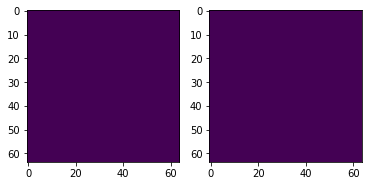

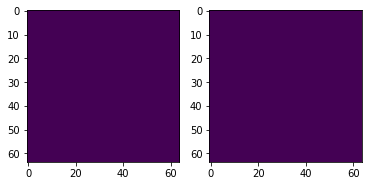

145
118
162
198
135
19
14
74
194
63
77
85
37
20
207
24
45
82
65
107
35
127
1
148
208
222
205
226
4
138
178
108
49
36
91
52
120
230
56
228
26
190
224
53
76
9
133
150
68
197
59
157
233
80
50
213
64
106
160
103
114
167
172
218
156
69
96
104
43
201
175
170
58
81
184
159
147
200
62
61
109
119
0
48
55
163
231
199
3
209
90
166
11
182
39
191
153
25
116
102
78
86
152
155
94
75
73
129
146
47
124
115
70
87
22
30
27
40
21
151
180
13
217
123
210
144
206
38
7
8
188
34
134
83
31
143
28
32
101
185
154
99
5
203
98
202
121
66
186
12
88
2
72
23
60
16
112
140
44
33
214
130
192
189
204
187
105
232
177
67
117
165
227
169
220
79
71
193
168
176
196
110
111
225
161
46
132
216
125
126
41
84
136
97
183
15
18
171
139
212
158
131
195
92
6
141
10
100
113
174
51
93
42
179
173
223
89
137
95
128
181
57
29
149
54
229
221
219
164
17
122
215
211
142
22
40
18
26
14
2
49
1
28
21
17
9
30
34
0
37
11
4
20
39
27
3
35
16
42
36
44
24
15
50
33
48
13
10
23
5
38
41
45
29
7
43
25
6
47
32
31
46
19
12
8
47
10
22
46
9
36
21
7
32
18
24


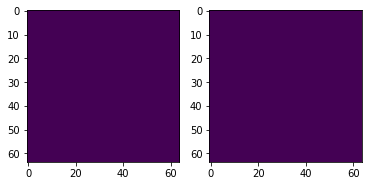

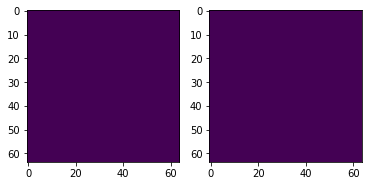

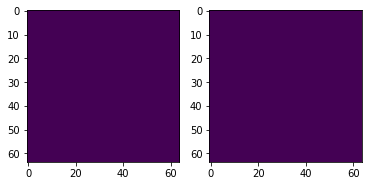

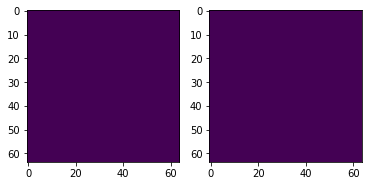

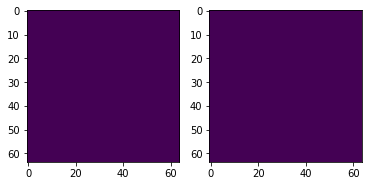

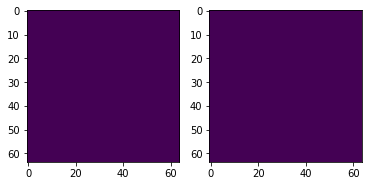

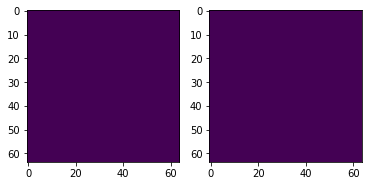

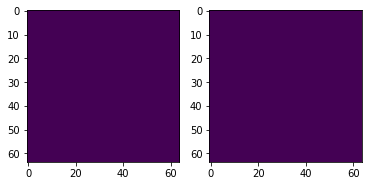

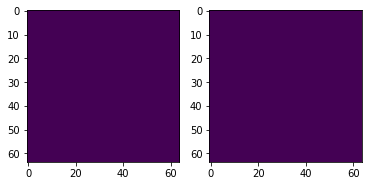

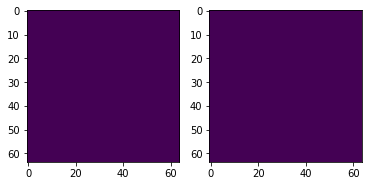

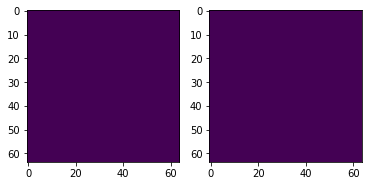

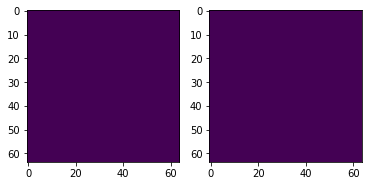

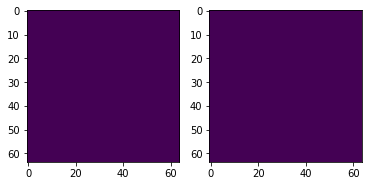

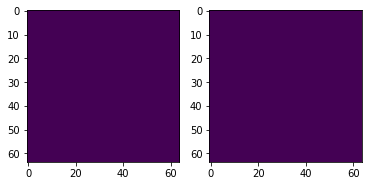

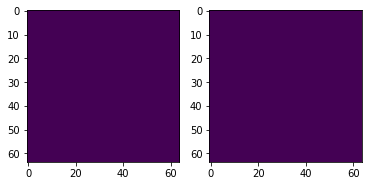

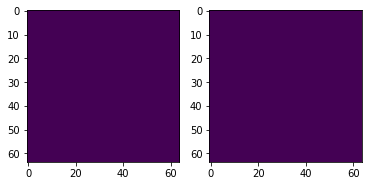

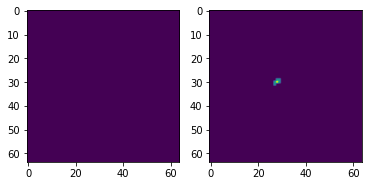

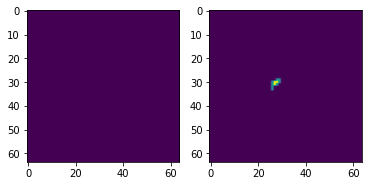

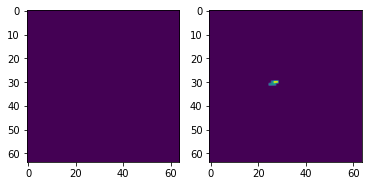

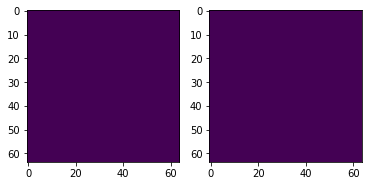

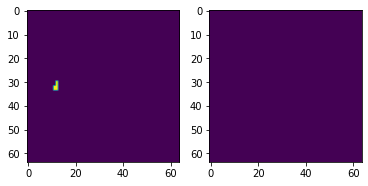

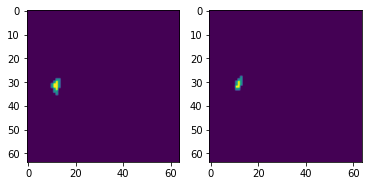

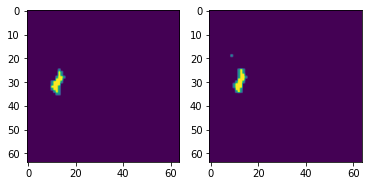

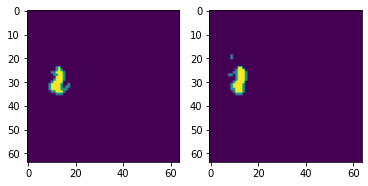

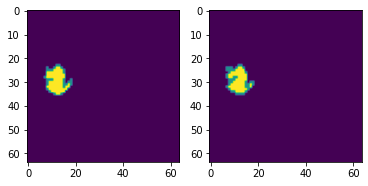

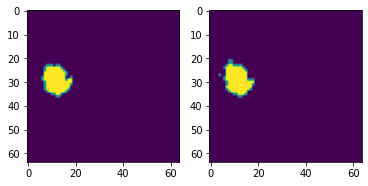

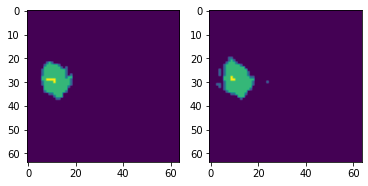

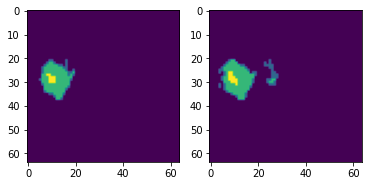

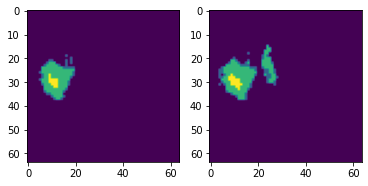

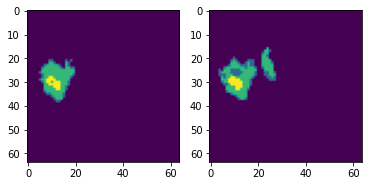

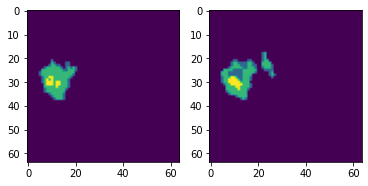

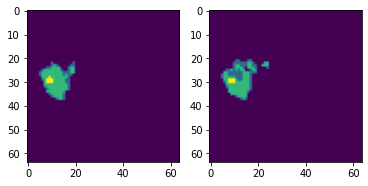

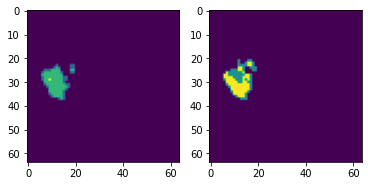

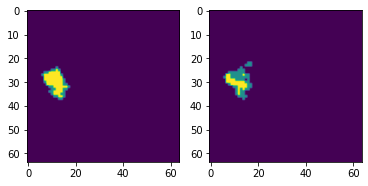

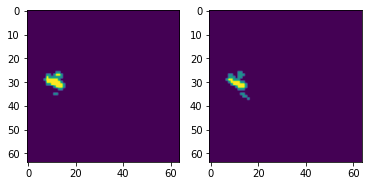

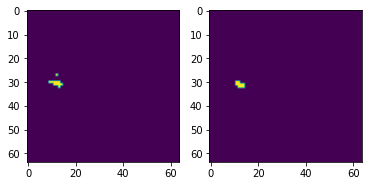

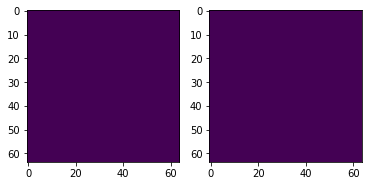

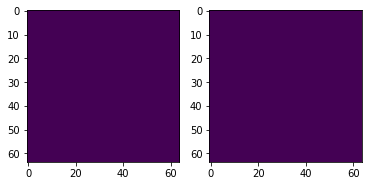

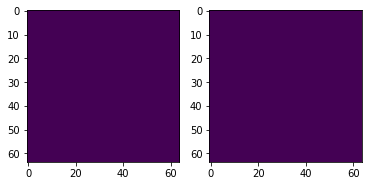

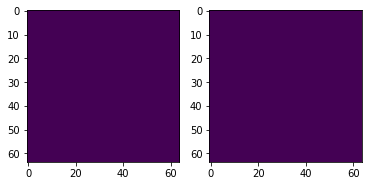

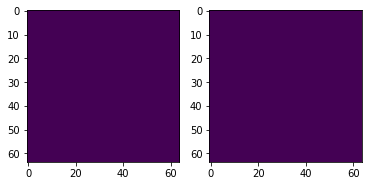

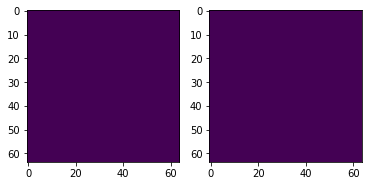

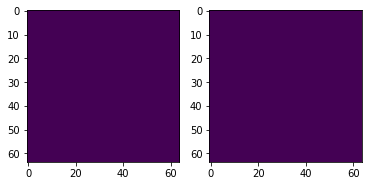

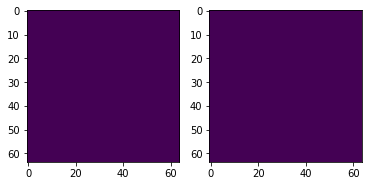

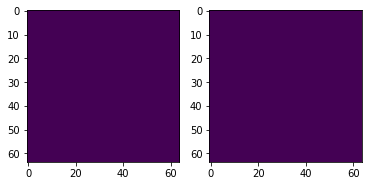

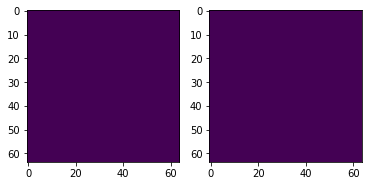

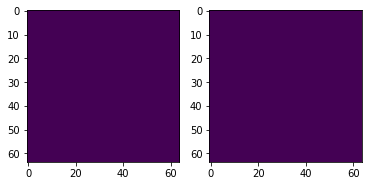

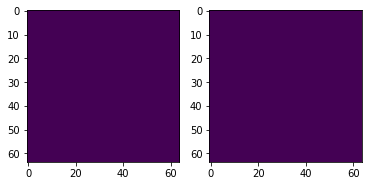

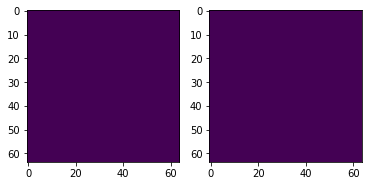

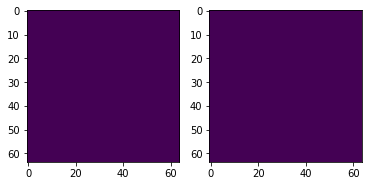

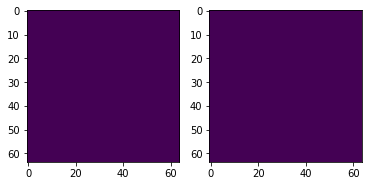

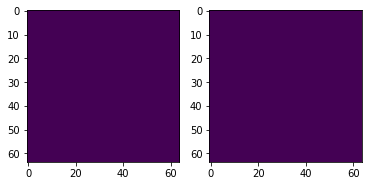

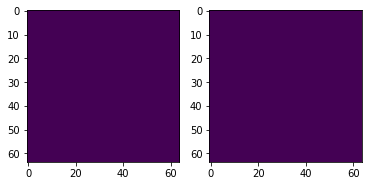

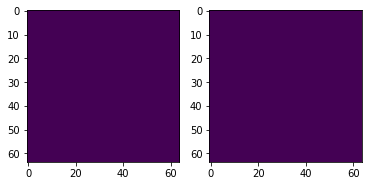

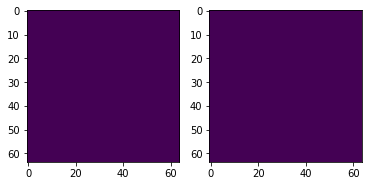

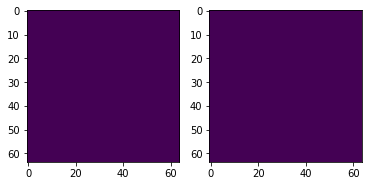

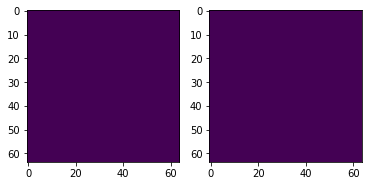

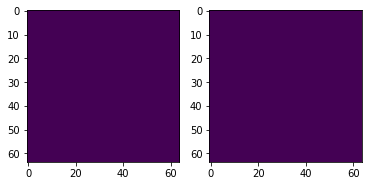

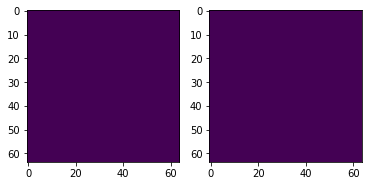

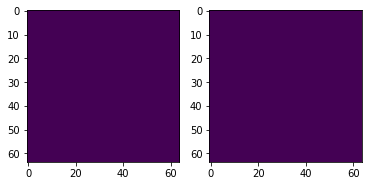

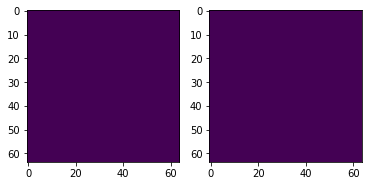

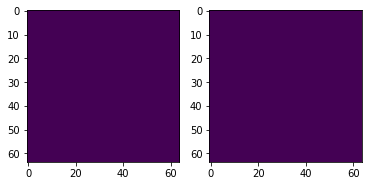

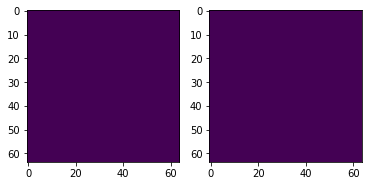

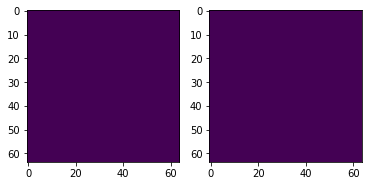

80
40
214
101
52
230
47
65
92
118
175
6
20
106
213
61
231
74
228
31
73
155
112
113
203
177
144
180
54
199
46
24
126
197
142
100
25
164
198
204
45
93
7
114
36
218
210
68
156
41
182
96
94
60
120
88
217
188
174
137
211
226
0
27
35
48
19
140
129
4
53
151
127
171
220
26
161
134
123
223
82
3
172
43
44
98
32
176
9
232
181
37
108
215
130
133
71
75
69
62
149
2
81
23
160
165
56
162
169
115
29
146
145
1
147
91
152
8
170
90
109
224
158
87
138
219
21
77
95
39
191
76
51
194
167
184
86
119
102
125
107
104
85
205
30
22
229
179
99
136
11
139
163
186
207
105
128
70
124
201
225
15
216
79
110
143
168
49
116
72
50
89
131
17
185
16
178
55
64
57
122
13
148
34
157
208
227
212
189
202
187
132
33
97
222
135
83
14
166
206
5
121
183
117
10
153
196
209
159
111
193
38
141
192
150
190
59
195
63
233
12
66
28
18
58
67
84
173
221
200
103
154
42
78
41
38
42
23
35
21
7
27
18
40
16
20
45
0
43
39
37
4
50
13
30
29
25
2
9
44
48
36
8
31
28
3
24
34
5
6
17
47
19
32
11
10
46
1
22
49
12
26
14
15
33
39
41
38
43
33
47
9
35
26
31
21

In [ ]:
model = keras.models.load_model("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/Tumor Seg only tumor binary 64 1/Model 111.h5",compile = False)
model.compile(optimizer = keras.optimizers.Adam(lr=0.00001), loss=tversky_loss, metrics=tf.keras.metrics.MeanIoU(num_classes=4))

start_batch = 0

model_name = "Tumor Seg only tumor binary 64 1"


image_size = 128

import time
start_time = time.time()

shuffling = True


epochs = 40
ep = 100
batch_size = 1
num_batches = 3

n = 0
train_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Train Images " + str(n) + ".h5"
train_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Train Masks " + str(n) + ".h5"
val_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Val Images " + str(n) + ".h5"
val_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Val Masks " + str(n) + ".h5"
test_images_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Test Images " + str(n) + ".h5"
test_masks_path = "/content/drive/My Drive/Tumor Segmentation Project/Data/Seperate into 64 datapoint batches for Tumor Seg semantic 64/Test Masks " + str(n) + ".h5"

if not os.path.exists("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/" + model_name):
    os.mkdir("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/" + model_name)

train_gen = DataGen(train_images_path, train_masks_path, batch_size=batch_size, image_size=image_size)
valid_gen = DataGen(val_images_path, val_masks_path, batch_size=batch_size, image_size=image_size)
test_gen = DataGen(test_images_path, test_masks_path, batch_size=batch_size, image_size=image_size)


x, y = train_gen.__getitem__(1)
print("x shape",x.shape)
print(np.min(x))
print("y shape",y.shape)
print(np.min(y))


def train(train_gen, valid_gen, test_gen, model_number):
    print("Training set " + str(i+1) + str(n+1)+" out of " + str(ep) + " sets...")

    train_steps = train_gen.data_size//batch_size
    valid_steps = valid_gen.data_size//batch_size

    model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, shuffle=True)

    ## Save the Weights

    model.save("/content/drive/My Drive/Tumor Segmentation Project/Saved Models (Not good models)/" + model_name + "/Model " + model_number +".h5")

    print('trainted one model in', int((time.time() - start_time)/60), 'minutes and ', int((time.time() - start_time) % 60), 'seconds.')


last_images = 0
for i in range(0,ep):
    for n in range(0, num_batches//3):
        '''start = n*3
        fin = start+3
        if fin>=num_batches:
          fin = num_batches-1
        train_gen,valid_gen,test_gen = get_data(start,fin)'''
        if shuffling:
            train_gen.shuffle_da_set()
            valid_gen.shuffle_da_set()
            test_gen.shuffle_da_set()

        train(train_gen,valid_gen,test_gen, (str(i+1)+str(n+1)))


        ## Dataset for prediction
        if True:#(((i*10)+n)*epochs)/40>last_images:
            last_images += 1
            x, y = test_gen.__getitem__(1)

            print(y.shape)
            print("max:",np.max(y))
            result = model.predict(x)
            print(result.shape)
            print("max:",np.max(result))

            #result = result > 0.5

            r = random.randint(0, len(y)-1)
            gt = np.argmax(y[r], axis=3)
            print(gt.shape)
            print("gt unique:",np.unique(gt))
            pred = np.argmax(result[r], axis=3)
            print(pred.shape)
            print("pred unique:",np.unique(pred))
            for n, image in enumerate(np.argmax(y[r], axis=3)):
                fig = plt.figure()
                #fig.subplots_adjust(hspace=0.4, wspace=0.4)
                ax = fig.add_subplot(1, 2, 1)
                ax.imshow(image)
                ax = fig.add_subplot(1, 2, 2)
                ax.imshow(np.argmax(result[r][n], axis = 2))


                plt.show()
                    
                        
        
